# Data Completeness Check Queries

To evaluate the dataset’s completeness and key data availability, we run a series of queries (via Pandas). These checks help identify missing information or under-represented data that might impact analysis. Below are important checks and queries for each:
we check:
1. Lab Results Frequency (Normal vs. Abnormal)
2. Anxiety-Related Prescription Entries
3. Referral Data Completeness (Mental Health)
4. ICD Code Coverage (SSD and Related Conditions)
5. ICD Code Coverage (SSD and Related Conditions)
    - Missing values per table
    - Records per patient
    - Time coverage consistency
    - Free-Text Data Availability

## Check #1: Lab Results Frequency (Normal vs. Abnormal)

In [2]:
import os
import pandas as pd

# ----------------------------------------------------------------------
# 1) SETUP: Define the data path and load each CSV into a DataFrame
# ----------------------------------------------------------------------
data_path = r"C:\Users\ProjectC4M\Documents\CPCSSN Datasets Care4Mind\New Extraction Feb 2025\prepared_data"

# Adjust filenames as necessary if they differ
file_map = {
    'Lab': 'Lab_prepared.csv',
    'Medication': 'Medication_prepared.csv',
    'Referral': 'Referral_prepared.csv',
    'EncounterDiagnosis': 'EncounterDiagnosis_prepared.csv',
    'Encounter': 'Encounter_prepared.csv',
    'FamilyHistory': 'FamilyHistory_prepared.csv',
    'HealthCondition': 'HealthCondition_prepared.csv',
    'MedicalProcedure': 'MedicalProcedure_prepared.csv',
    'Patient': 'Patient_prepared.csv',
    'PatientDemographic': 'PatientDemographic_prepared.csv',
    'PatientDemographicMerged': 'PatientDemographic_merged_prepared.csv',
    'RiskFactor': 'RiskFactor_prepared.csv'
}

dfs = {}
for table_name, csv_file in file_map.items():
    full_path = os.path.join(data_path, csv_file)
    if os.path.exists(full_path):
        df = pd.read_csv(full_path, low_memory=False)
        dfs[table_name] = df
        print(f"Loaded {table_name} -> {csv_file} with shape {df.shape}")
    else:
        print(f"WARNING: {csv_file} not found in {data_path} - skipping.")

# For convenience, define variables for commonly used DataFrames
lab_df = dfs.get('Lab')
med_df = dfs.get('Medication')
ref_df = dfs.get('Referral')
encdiag_df = dfs.get('EncounterDiagnosis')
patient_df = dfs.get('Patient')  


Loaded Lab -> Lab_prepared.csv with shape (8528807, 22)
Loaded Medication -> Medication_prepared.csv with shape (7706628, 27)
Loaded Referral -> Referral_prepared.csv with shape (1141061, 12)
Loaded EncounterDiagnosis -> EncounterDiagnosis_prepared.csv with shape (12471764, 14)
Loaded Encounter -> Encounter_prepared.csv with shape (11577739, 11)
Loaded FamilyHistory -> FamilyHistory_prepared.csv with shape (325202, 20)
Loaded HealthCondition -> HealthCondition_prepared.csv with shape (2571583, 16)
Loaded MedicalProcedure -> MedicalProcedure_prepared.csv with shape (1203002, 10)
Loaded Patient -> Patient_prepared.csv with shape (352161, 6)
Loaded PatientDemographic -> PatientDemographic_prepared.csv with shape (352220, 15)
Loaded PatientDemographicMerged -> PatientDemographic_merged_prepared.csv with shape (352220, 22)
Loaded RiskFactor -> RiskFactor_prepared.csv with shape (603298, 25)


### there are 8.5 mil rows in the lab table. 
For SSD experiment 1, it’s crucial to see if normal/negative lab results are recorded or if the data skews toward abnormal findings. A high count of normal results indicates comprehensive lab capture (not just abnormal ones). lets see

- How many TestResult_calc entries are numeric vs. non-numeric.
- Missingness in key columns (TestResult_calc, UpperNormal, LowerNormal, NormalRange, Name_calc).
- How many rows have both UpperNormal and LowerNormal present.
- A quick look at the top lab test names in Name_calc.

the script below tries to classify labs as “Normal” vs. “Abnormal” using the existing columns LowerNormal and UpperNormal (if available). It then counts how many results fall into each category. 

In [3]:
# ----------------------------------------------------------------------
# 2) LAB RESULTS FREQUENCY CHECK (Normal vs. Abnormal)
# ----------------------------------------------------------------------
if lab_df is not None:
    print("\n--- [Lab] Detailed Completeness and Normal Range Checks ---")

    # 1) Check how many 'TestResult_calc' are numeric vs non-numeric
    #    We'll try to convert to float; non-convertible entries become NaN
    test_result_numeric = pd.to_numeric(lab_df['TestResult_calc'], errors='coerce')
    numeric_count = test_result_numeric.notna().sum()
    total_count = len(lab_df)
    print(f"Total lab records: {total_count}")
    print(f"Numeric TestResult_calc: {numeric_count} ({numeric_count/total_count:.2%})")
    print(f"Non-numeric or missing TestResult_calc: {total_count - numeric_count} "
          f"({(total_count - numeric_count)/total_count:.2%})")

    # 2) Missingness in key columns
    columns_of_interest = ['TestResult_calc','UpperNormal','LowerNormal','NormalRange','Name_calc']
    for col in columns_of_interest:
        if col in lab_df.columns:
            missing = lab_df[col].isna().sum()
            print(f"{col} missing: {missing} out of {total_count} "
                  f"({missing/total_count:.2%})")
        else:
            print(f"[WARNING] Column '{col}' not found in lab_df")

    # 3) How many rows have both UpperNormal and LowerNormal present?
    if 'UpperNormal' in lab_df.columns and 'LowerNormal' in lab_df.columns:
        valid_range_mask = lab_df['UpperNormal'].notna() & lab_df['LowerNormal'].notna()
        print(f"Rows with both UpperNormal & LowerNormal not null: "
              f"{valid_range_mask.sum()} / {total_count} "
              f"({valid_range_mask.sum()/total_count:.2%})")

    # 4) Quick peek at top 10 lab test names in Name_calc
    if 'Name_calc' in lab_df.columns:
        print("\nTop 10 lab test names (Name_calc):")
        print(lab_df['Name_calc'].value_counts().head(10))



--- [Lab] Detailed Completeness and Normal Range Checks ---
Total lab records: 8528807
Numeric TestResult_calc: 4304804 (50.47%)
Non-numeric or missing TestResult_calc: 4224003 (49.53%)
TestResult_calc missing: 4176975 out of 8528807 (48.97%)
UpperNormal missing: 7169473 out of 8528807 (84.06%)
LowerNormal missing: 7249880 out of 8528807 (85.00%)
NormalRange missing: 3556624 out of 8528807 (41.70%)
Name_calc missing: 4028598 out of 8528807 (47.24%)
Rows with both UpperNormal & LowerNormal not null: 1219699 / 8528807 (14.30%)

Top 10 lab test names (Name_calc):
Name_calc
TOTAL CHOLESTEROL                 711481
HDL                               710700
LDL                               704991
TRIGLYCERIDES                     688773
FASTING GLUCOSE                   646306
HBA1C                             449108
GFR                               197833
INR                               173373
URINE ALBUMIN CREATININE RATIO    124056
MICROALBUMIN                       85715
Name: count,

### Rows with Both UpperNormal & LowerNormal: ~14.3% of rows.

    That is about 1.22 million lab records.
    So only that subset can be easily labeled “within range” vs. “out of range” if we trust the provided upper/lower values.

### could we use top 10 labs to define normal vs. abnormal manually for specific/selected labs? (option B or C below)

### Key Takeaways for “Repeated Negative Labs” Analysis

    No Simple “Normal vs. Abnormal” Flag. The dataset does not natively store a large proportion of straightforward normal/abnormal indicators. Only 14% of rows have both UpperNormal and LowerNormal.

    - Option A (broader approach): Use the ~14% subset where UpperNormal and LowerNormal are populated. can we straightforwardly label those results as normal/abnormal by checking if LowerNormal ≤ TestResult_calc ≤ UpperNormal.
        Pro: Automated, minimal guesswork.
        Con: we lose ~86% of lab data.

    - Option B: Define our own normal ranges for tests that have numeric results + a known name (e.g., “HbA1c <5.7% is normal,” “LDL <3.0 mmol/L is normal,” etc.).
        Pro: we can potentially recapture a larger portion of the data for well-known labs.
        Con: This requires domain knowledge and might not apply to all tests, especially if the dataset uses nonstandard units or if Name_calc is missing.

    - Option C: Focus on a single or few consistently coded tests (like HbA1c, Fasting Glucose, TSH if available) where normal cutoffs are widely recognized and the data coverage is good.
        Pro: Simpler, more reliable approach. Good coverage for certain tests.
        Con: Limits “repeated negative labs” to a small set of lab types rather than all labs.

## Testing Option A the  “broader approach” using the 14% of lab rows that have both UpperNormal and LowerNormal values.

- Label each lab as “normal” or “abnormal” using the provided UpperNormal/LowerNormal values.
- Filter the data to only include rows where both UpperNormal and LowerNormal are available.
- Aggregate by Patient_ID to count the number of “normal” lab results per patient.
- Count how many patients have ≥3 normal labs within the overall dataset (we may later add a timeframe filter if needed).

In [4]:
# Step 2b: Label labs as normal vs. abnormal using UpperNormal and LowerNormal

# First, create a mask for rows where both UpperNormal and LowerNormal are not null
valid_range_mask = lab_df['UpperNormal'].notna() & lab_df['LowerNormal'].notna()

# Create a new DataFrame for rows with valid normal range data
lab_valid = lab_df[valid_range_mask].copy()

# Ensure TestResult_calc, UpperNormal, and LowerNormal are numeric for comparison
lab_valid['TestResult_calc'] = pd.to_numeric(lab_valid['TestResult_calc'], errors='coerce')
lab_valid['UpperNormal'] = pd.to_numeric(lab_valid['UpperNormal'], errors='coerce')
lab_valid['LowerNormal'] = pd.to_numeric(lab_valid['LowerNormal'], errors='coerce')

# Label as normal if the test result falls within the normal range, else abnormal
lab_valid['is_normal'] = (
    (lab_valid['TestResult_calc'] >= lab_valid['LowerNormal']) & 
    (lab_valid['TestResult_calc'] <= lab_valid['UpperNormal'])
)

# Quick check: What is the distribution of normal vs abnormal in this subset?
print("\nDistribution of is_normal in lab_valid:")
print(lab_valid['is_normal'].value_counts(dropna=False))

# ----------------------------------------------------------------------
# Evaluate the volume: Count how many "normal" labs each patient has
# ----------------------------------------------------------------------
# We'll group by Patient_ID and count the number of labs labeled as normal.
normal_counts = lab_valid[lab_valid['is_normal']].groupby('Patient_ID').size().reset_index(name='normal_lab_count')

# Check the overall distribution of normal_lab_count
print("\nDistribution of normal lab counts per patient (for records with valid ranges):")
print(normal_counts['normal_lab_count'].describe())

# Determine how many patients have >=3 normal lab results
patients_with_3plus = normal_counts[normal_counts['normal_lab_count'] >= 3]
num_patients_3plus = patients_with_3plus['Patient_ID'].nunique()
total_patients_in_valid = lab_valid['Patient_ID'].nunique()

print(f"\nNumber of patients with ≥3 normal labs: {num_patients_3plus} out of {total_patients_in_valid} "
      f"({num_patients_3plus/total_patients_in_valid:.2%})")



Distribution of is_normal in lab_valid:
is_normal
False    735882
True     483817
Name: count, dtype: int64

Distribution of normal lab counts per patient (for records with valid ranges):
count    63399.000000
mean         7.631303
std          7.854361
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        196.000000
Name: normal_lab_count, dtype: float64

Number of patients with ≥3 normal labs: 46326 out of 69242 (66.90%)


### Filter Lab Data by Timeframe

we may either select a fixed calendar period or, ideally, define an index date for each patient and count only labs in the preceding 12 months.

##### using patient-specific 12‑month window. since patients have varying entry and exit times in the system. This method defines an index date for each patient (here, using the most recent lab date available) and then counts the normal labs in the 12 months preceding that index date.

In [7]:
import pandas as pd
from dateutil.relativedelta import relativedelta

# Ensure 'PerformedDate' is a datetime
lab_valid['PerformedDate'] = pd.to_datetime(lab_valid['PerformedDate'], errors='coerce')

# Step 1: Define an index date for each patient (using the most recent lab date)
patient_index_dates = lab_valid.groupby('Patient_ID')['PerformedDate'].max().reset_index(name='index_date')

# Merge the index date back into lab_valid
lab_valid = lab_valid.merge(patient_index_dates, on='Patient_ID', how='left')

# Step 2: For each lab, check if its date is within 12 months before the patient’s index date
lab_valid['within_12m'] = lab_valid.apply(
    lambda row: (row['PerformedDate'] >= (row['index_date'] - relativedelta(months=12))) and 
                (row['PerformedDate'] <= row['index_date']),
    axis=1
)

# Filter for labs within the 12-month window
lab_relative = lab_valid[lab_valid['within_12m']].copy()

# Step 3: Group by Patient_ID and count the number of labs labeled as normal in that window
normal_counts_relative = lab_relative[lab_relative['is_normal']].groupby('Patient_ID').size().reset_index(name='normal_lab_count')

# Display descriptive statistics for normal lab counts in the 12-month window
print("\nDistribution of normal lab counts per patient (relative 12-month window):")
print(normal_counts_relative['normal_lab_count'].describe())

# Step 4: Count how many patients have ≥3 normal labs in their 12-month window
patients_with_3plus_relative = normal_counts_relative[normal_counts_relative['normal_lab_count'] >= 3]
num_patients_3plus_relative = patients_with_3plus_relative['Patient_ID'].nunique()
total_patients_relative = lab_relative['Patient_ID'].nunique()

print(f"\nNumber of patients with ≥3 normal labs (relative 12-month window): {num_patients_3plus_relative} out of {total_patients_relative} "
      f"({num_patients_3plus_relative/total_patients_relative:.2%})")



Distribution of normal lab counts per patient (relative 12-month window):
count    55347.000000
mean         2.796972
std          2.011843
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        113.000000
Name: normal_lab_count, dtype: float64

Number of patients with ≥3 normal labs (relative 12-month window): 26035 out of 69242 (37.60%)


Below is a structured summary of our findings from the relative 12‑month window analysis:

---

### Summary of Findings

| **Metric**                                         | **Value**                   | **Interpretation**                                                 |
|----------------------------------------------------|-----------------------------|--------------------------------------------------------------------|
| **Total Patients (with valid lab data)**           | 69,242                      | Patients with at least one lab record in the 12‑month window.      |
| **Mean number of normal labs per patient**         | 2.80                        | On average, patients have ~2.8 normal lab results in their window. |
| **Median number of normal labs per patient**       | 2                           | Half of the patients have 2 or fewer normal lab results.           |
| **Interquartile Range**                            | 1 (25th percentile) to 4 (75th percentile) | Most patients have between 1 and 4 normal labs.  |
| **Maximum number of normal labs per patient**      | 113                         | There is high variability in the number of normal labs.            |
| **Patients with ≥3 normal labs**                   | 26,035                      | This is 37.6% of patients in the cohort.                           |

---

### Detailed Analysis

- **Cohort Definition:**  
  We defined each patient's index date as the most recent lab date, and then computed the number of normal labs within the 12 months preceding that date. This personalized, patient‐specific timeframe aligns with clinical practice and allows us to capture each patient's recent lab history.

- **Volume Check:**  
  Our analysis shows that 37.6% of patients (26,035 out of 69,242) have three or more normal lab results within their 12‑month window. This subgroup is substantial and can be used to investigate whether repeated “negative” lab results (as a proxy for reassurance) are associated with increased SSD severity and future healthcare utilization.

- **Data Completeness Considerations:**  
  It is important to note that our analysis is based on approximately 14% of lab records that contain both UpperNormal and LowerNormal values. As a result, while our findings are robust for this subset, they might not represent the entire lab dataset. We must document this limitation and consider potential biases in our causal analyses.

- **Clinical and Methodological Relevance:**  
  The use of a relative 12‑month window is clinically more relevant than imposing an arbitrary calendar year, as it accounts for individual patient trajectories. This approach enhances the validity of our hypothesis testing regarding the impact of repeated normal labs on SSD severity.

---

### Next Steps

1. **Sensitivity Analysis:**  
   We will compare the characteristics of patients with and without complete lab reference data to assess potential biases.

2. **Refinement of Lab Definitions:**  
   For key tests (e.g., HbA1c, fasting glucose), we might consider applying domain-specific normal ranges to broaden our data coverage if needed.

3. **Integration into the Causal Model:**  
   We will incorporate the “repeated negative labs” metric into our causal mediation analysis to explore its effect on SSD severity and subsequent healthcare utilization.

---

This structured summary will be documented in our thesis methodology section, where we clearly justify our approach and acknowledge data limitations. 



## Overall Data Completeness Check Plan - Progress

1. **Lab Results Frequency (Normal vs. Abnormal):**  
   - **What We’ve Done:**  
     - We checked numeric vs. non‑numeric entries in `TestResult_calc`.  
     - We examined missingness in key fields: `TestResult_calc`, `UpperNormal`, `LowerNormal`, `NormalRange`, and `Name_calc`.  
     - We noted that only about 14% of rows have both `UpperNormal` and `LowerNormal`, which we can use to automatically label tests as “Normal” or “Abnormal.”  
     - We implemented a patient‑specific 12‑month window to count “normal” lab results per patient and found that 37.6% of patients (26,035 out of 69,242) have ≥3 normal labs.  
   - **Next Consideration for Labs:**  
     - We may later consider domain-specific cutoffs (Option B/C) for frequently used tests (like HbA1c, fasting glucose) to include more data if needed.

2. **Anxiety-Related Prescription Entries:**  
   - **Plan:**  
     - Next, we will check the Medication table for prescriptions of common anxiety medications.  
     - We’ll search for names such as SERTRALINE, ESCITALOPRAM, DIAZEPAM, etc., using a case-insensitive matching approach.  
     - We will examine the frequency of these medications and note any missing data.
     
3. **Referral Data Completeness (Mental Health):**  
   - **Plan:**  
     - We will assess the Referral table to identify records related to mental health (e.g., psychiatry, counseling).  
     - We’ll check key fields (e.g., referral reason, referral date) for missingness and determine the count of mental health referrals.

4. **ICD Code Coverage (SSD and Related Conditions):**  
   - **Plan:**  
     - We will examine the EncounterDiagnosis (or Diagnosis) table for ICD codes corresponding to somatic symptom disorders, somatoform disorders, and anxiety-related conditions.  
     - We’ll check the frequency and distribution of these codes and count how many patients have at least one such diagnosis.

5. **General Missingness & Cross-Table Checks:**  
   - **Plan:**  
     - We’ll run a general missingness check across tables to identify any major gaps (e.g., many patients with no lab or medication data).  
     - We will also verify consistency across linked tables (e.g., ensure that each Patient_ID appears in the Patient table).

6. **Free-Text Data Availability:**  
   - **Plan:**  
     - We will scan each table for potential free-text columns by reviewing object-type columns and their average string lengths.  
     - We will then sample entries from those columns to determine if they can be used for NLP analysis.


In [ ]:
# further investigation

# ## MEdical History check for each patient
#   (if a patient has a documented chronic illness or upcoming surgery, 
#   frequent labs align with that and do not indicate SSD. )
# upcoming surgery (as a lab test reason?)
# comorbodoities?
#  context and intent behind lab tests? (clear medical rationale?)
# doctor-shopping behavior? 

# To avoid mislabeling, guidelines suggest confirming that 
# all appropriate investigations for any plausible diseases 
# have been done before attributing symptoms to SSD (Somatic Symptom Disorder - StatPearls - NCBI Bookshelf). 
# In summary, physicians differentiate SSD from justified testing by verifying 
# whether the frequency of tests matches a medical necessity 
# (e.g. following evidence-based screening or treatment protocols). 
# If tests are frequent and largely patient-driven without clinical indications – 
# especially if multiple specialists and ER visits are involved – SSD becomes a 
# more likely explanation than routine care.

# https://www.ncbi.nlm.nih.gov/books/NBK532253/#:~:text=people.,particularly%20panic%2C%20generalized%20anxiety%2C%20and



# Check #2 Anxiety-Related Prescription Entries

## improved script

Analysis execution started: 2025-02-28 19:32:46

 ANXIETY MEDICATION ANALYSIS: DSM-5 CRITERION ALIGNMENT 

This analysis examines anxiety medication patterns to identify
patients with persistent health anxiety as defined in DSM-5 criteria.
--------------------------------------------------------------------------------
Medication table shape: (7706628, 36) rows x columns

Examining medication data columns to identify medication names...

Using 'Name_calc' column for medication identification.
Missing values in Name_calc: 315680 records (4.10%)

Identifying anxiety medications in the dataset...

Anxiety Medication Usage By Class:
--------------------------------------------------
  • SSRIs: 287,035 prescriptions (3.7% of all medications)
  • SNRIs: 136,360 prescriptions (1.8% of all medications)
  • Benzodiazepines: 246,362 prescriptions (3.2% of all medications)
  • Other Anxiolytics: 37,577 prescriptions (0.5% of all medications)
  • TCAs for Anxiety: 80,666 prescriptions (1.0% of all

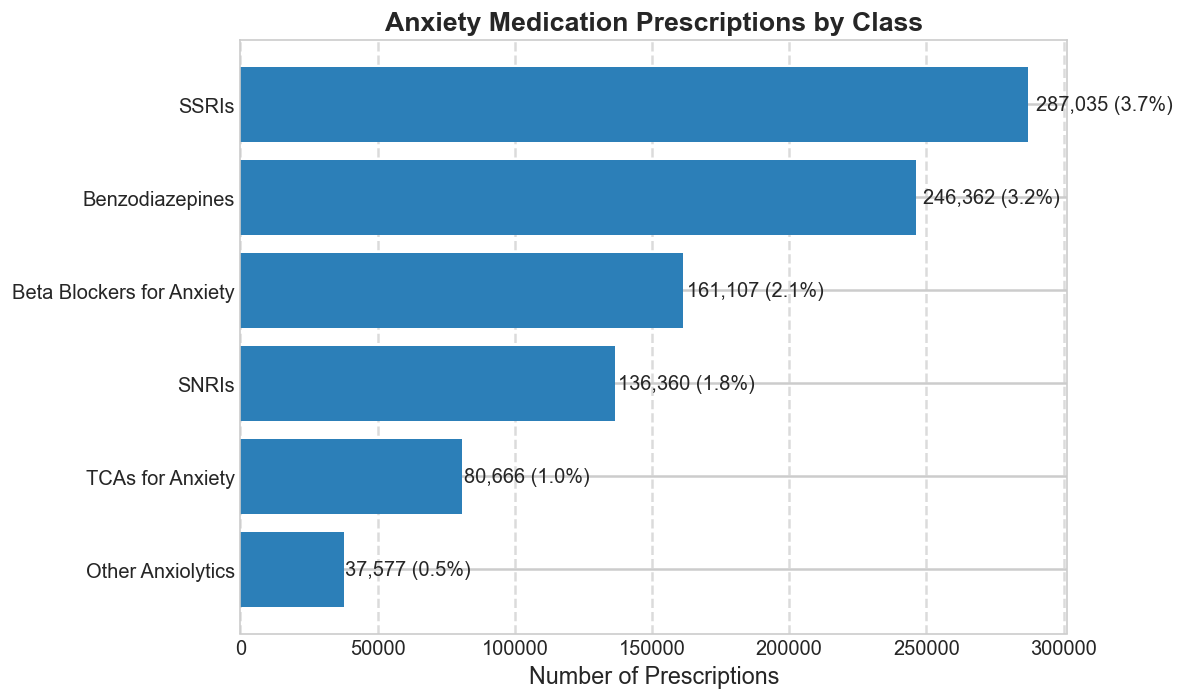

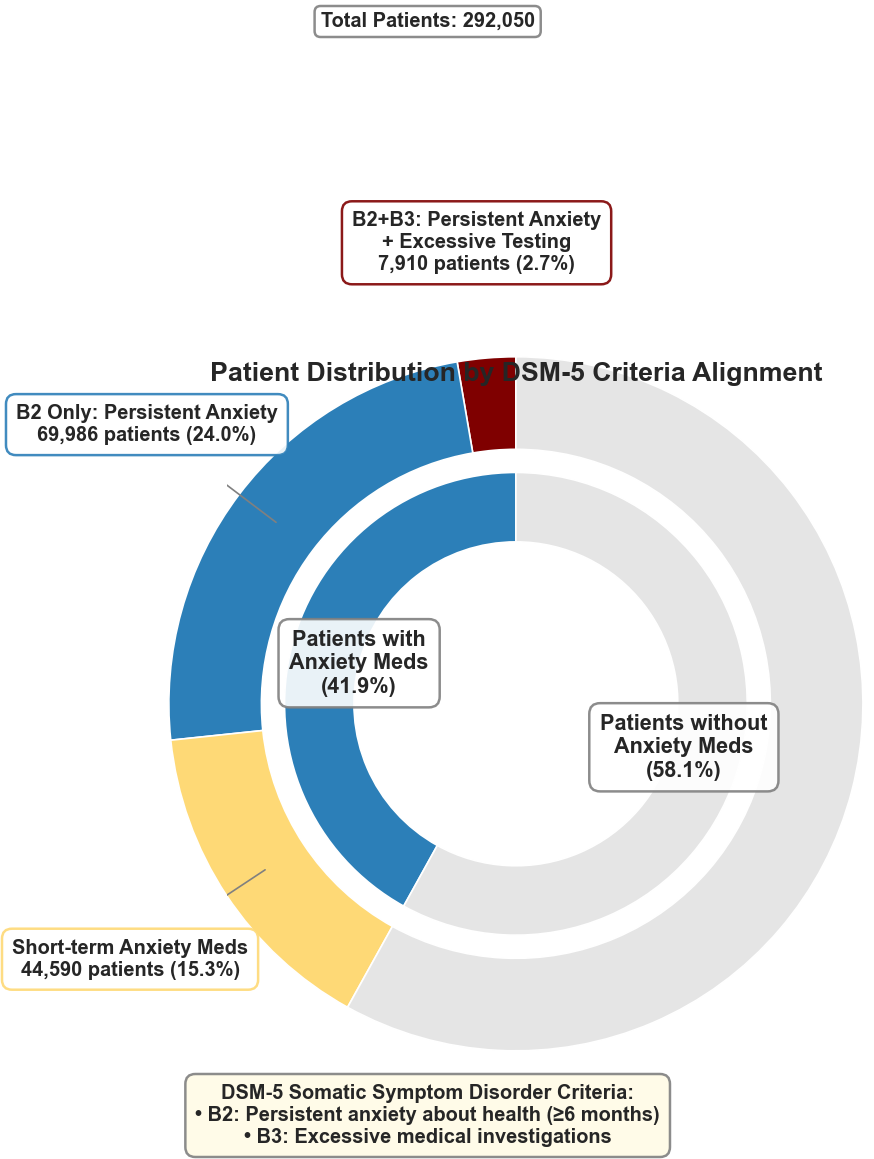

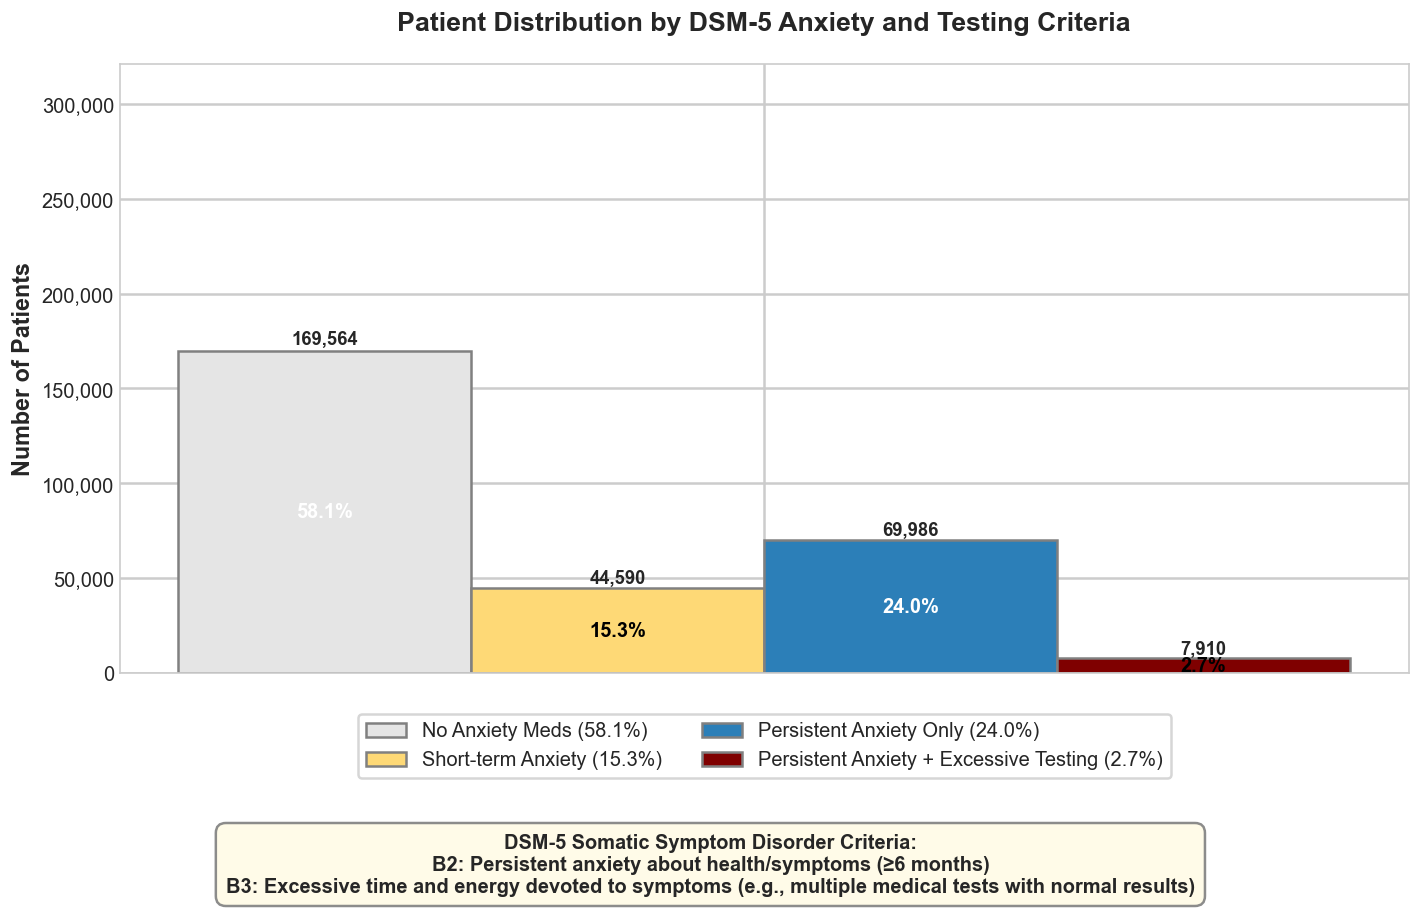

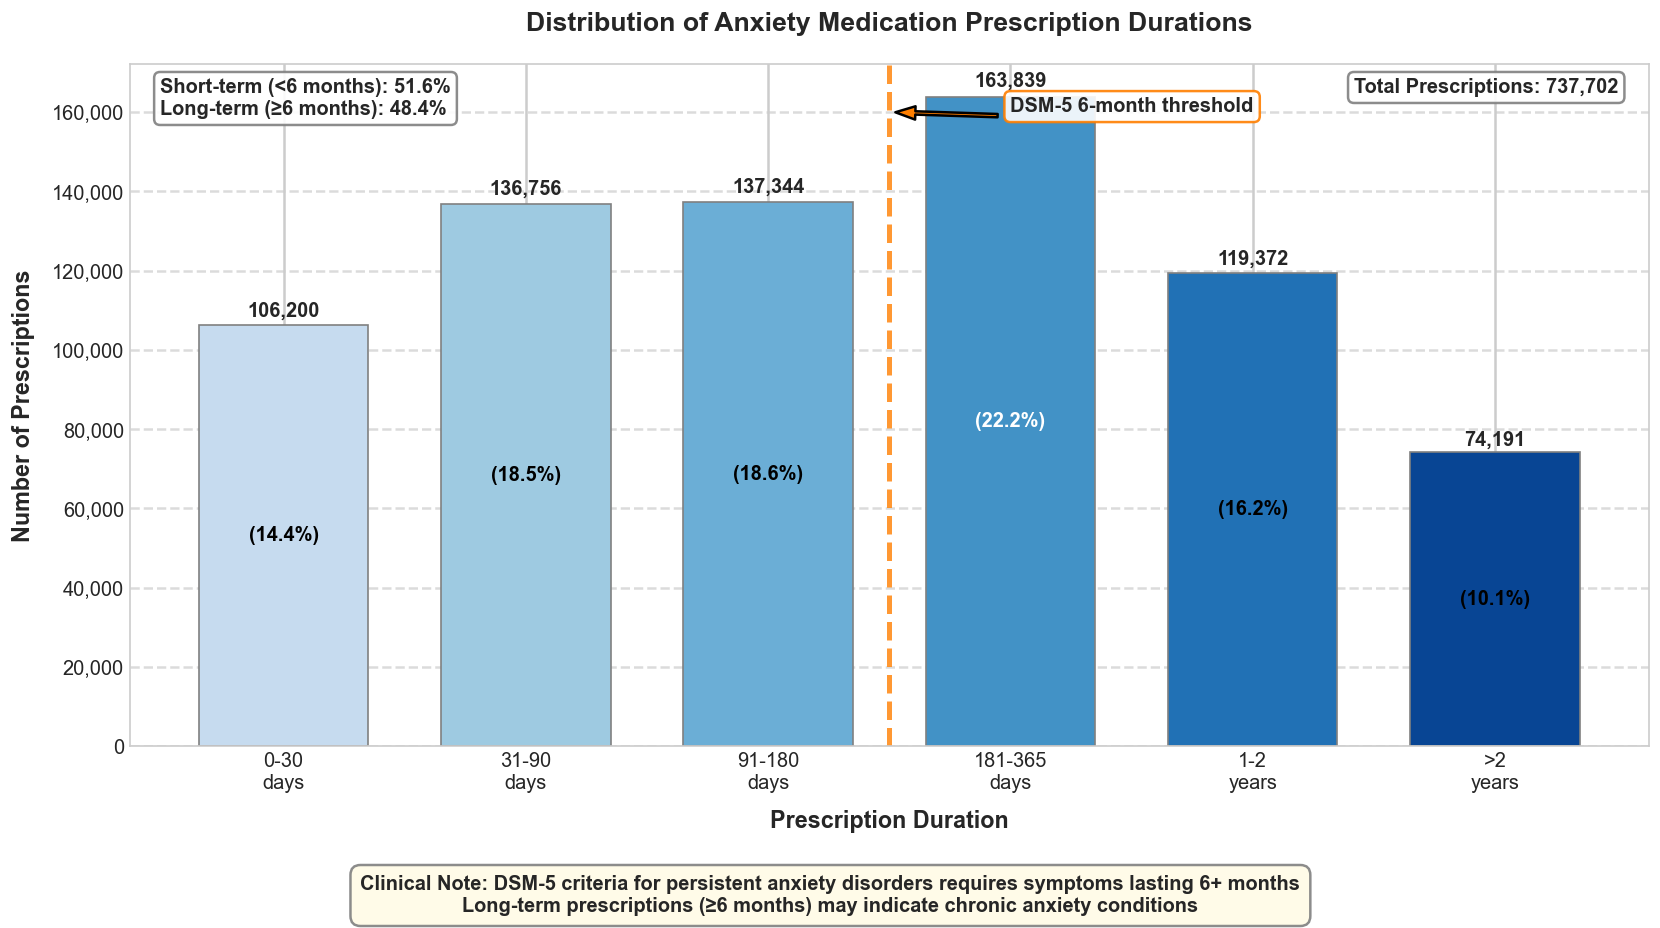

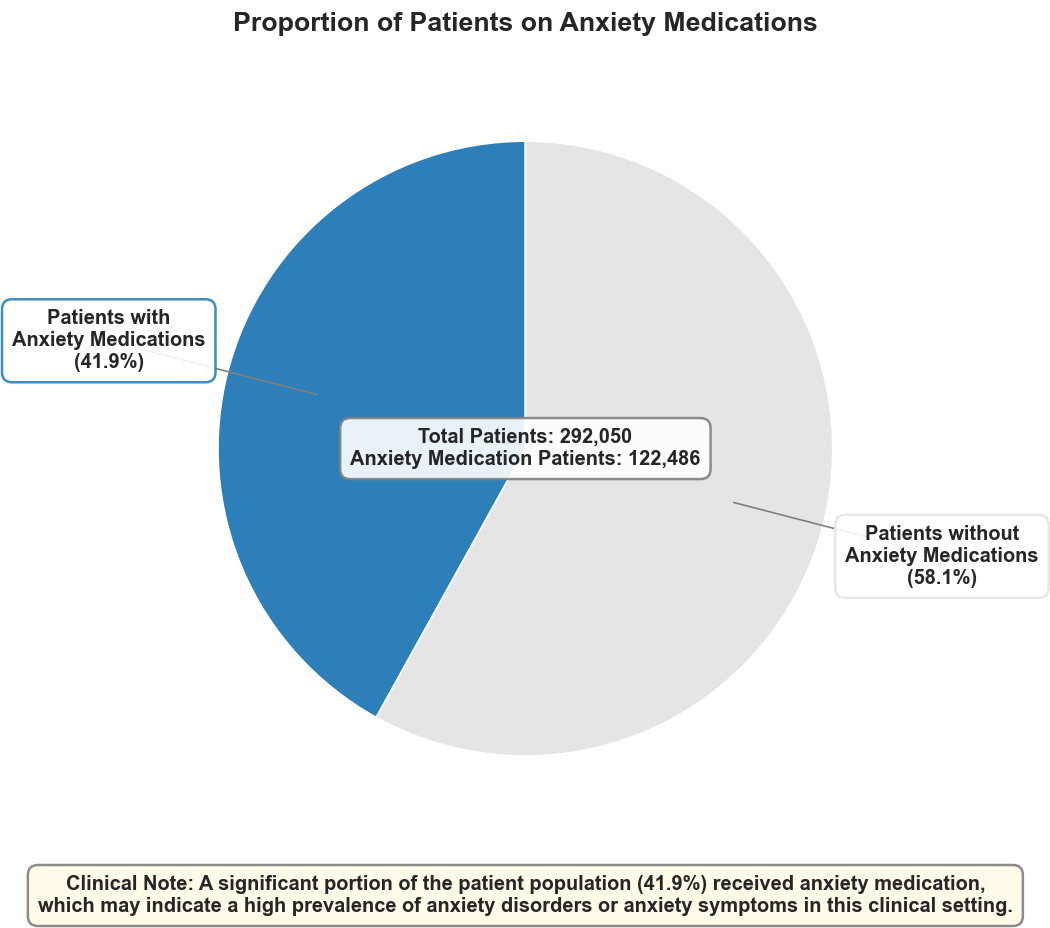

In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
===============================================================================
ANXIETY MEDICATION ANALYSIS: DSM-5 CRITERIA ALIGNMENT FOR RESEARCH PUBLICATION
===============================================================================

This script analyzes patterns of anxiety medication use in electronic health record (EHR) 
data to identify patients with persistent health anxiety according to DSM-5 criteria.

AUTHOR:
-------
[Author Name]
[Institution]
[Email]

VERSION:
--------
1.0.0 (February 2025)

DEPENDENCIES:
------------
- pandas >= 1.3.0
- numpy >= 1.20.0
- matplotlib >= 3.4.0
- seaborn >= 0.11.0

CITATION:
---------
American Psychiatric Association. (2013). Diagnostic and statistical manual of mental
disorders (5th ed.). https://doi.org/10.1176/appi.books.9780890425596
See Section on Somatic Symptom Disorder (SSD), criteria B2 and B3.

DESCRIPTION:
-----------
This analysis examines anxiety medication patterns to identify patients with
persistent health anxiety as defined in DSM-5 criteria. The script identifies:

1. Patients prescribed anxiety medications
2. Medication patterns by class (SSRIs, SNRIs, benzodiazepines, etc.)
3. Duration and persistence of medication use
4. Alignment with DSM-5 Somatic Symptom Disorder criteria:
   - B2: Persistent anxiety about health (≥6 months)
   - B3: Excessive medical investigations (multiple normal lab tests)

INPUT:
------
Expected input is a medication dataframe ('med_df') with:
- Patient_ID: unique patient identifier
- Medication name field (one of: Name_calc, Name_orig, drug_name, name)
- Start date field (one of: StartDate, start_date, prescribing_date)
- End date field (optional, one of: StopDate, end_date, stop_date)

Optional: 
- 'normal_counts_relative' dataframe with Patient_ID and normal_lab_count fields

OUTPUT:
-------
1. Summary statistics on anxiety medication use patterns
2. Visualizations of key findings
3. Identification of patients meeting DSM-5 criteria
4. Output dataframe 'anxiety_med_df' for further analysis

"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from datetime import datetime
import warnings

# Suppress SettingWithCopyWarning for cleaner output
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Record execution timestamp for reproducibility
EXECUTION_TIMESTAMP = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Analysis execution started: {EXECUTION_TIMESTAMP}")

# ==============================================================================
# CONFIGURATION PARAMETERS
# ==============================================================================
# These parameters can be modified to customize the analysis

# DSM-5 SSD criteria thresholds
PERSISTENT_ANXIETY_THRESHOLD_DAYS = 180  # 6 months for criterion B2
EXCESSIVE_TESTING_THRESHOLD = 3  # Number of normal lab tests for criterion B3

# Visualization parameters
VISUALIZATION_DPI = 120  # Higher DPI for publication-quality figures
SAVE_FIGURES = False  # Set to True to save figures automatically
FIGURES_OUTPUT_DIR = "figures"  # Directory for saving figures

# Create output directory if it doesn't exist and saving is enabled
if SAVE_FIGURES and not os.path.exists(FIGURES_OUTPUT_DIR):
    os.makedirs(FIGURES_OUTPUT_DIR)

# ==============================================================================
# VISUALIZATION SETUP AND STYLING
# ==============================================================================
"""
Defines consistent styling parameters for all visualizations to ensure
publication-quality figures with consistent appearance.
"""

# Set consistent styling for all visualizations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'figure.figsize': (12, 9),  # Larger default figure size
})

# Define a consistent color palette (colorblind-friendly)
# Colors chosen for maximum interpretability and accessibility
COLORS = {
    'no_anxiety': '#E5E5E5',        # Light gray
    'short_term': '#FED976',        # Light yellow/gold
    'persistent': '#2C7FB8',        # Medium blue
    'persistent_testing': '#7F0000', # Dark red
    'duration_0_30': '#C6DBEF',     # Lightest blue
    'duration_31_90': '#9ECAE1',    # Light blue
    'duration_91_180': '#6BAED6',   # Medium blue
    'duration_181_365': '#4292C6',  # Medium-dark blue
    'duration_1_2yr': '#2171B5',    # Dark blue
    'duration_gt_2yr': '#084594',   # Darkest blue
    'highlight': '#FF7F00',         # Orange (for thresholds/highlights)
    'annotation': '#FFFBE6'         # Very light yellow (for annotation backgrounds)
}

# Set DPI for better resolution
plt.rcParams['figure.dpi'] = VISUALIZATION_DPI

# ==============================================================================
# VISUALIZATION FUNCTIONS
# ==============================================================================

def create_improved_nested_pie_chart(total_patients, no_anxiety_patients, 
                                    short_term_anxiety, persistent_anxiety_only, 
                                    persistent_anxiety_testing, save_path=None):
    """
    Creates an improved nested pie chart showing the distribution of patients by DSM-5 criteria.
    
    Parameters:
    -----------
    total_patients : int
        Total number of patients in the dataset
    no_anxiety_patients : int
        Number of patients without anxiety medications
    short_term_anxiety : int
        Number of patients with short-term anxiety medications (<6 months)
    persistent_anxiety_only : int
        Number of patients with persistent anxiety medications (≥6 months) without excessive testing
    persistent_anxiety_testing : int
        Number of patients with both persistent anxiety and excessive testing
    save_path : str, optional
        Path to save the figure, if None, figure is not saved
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    # Verify percentages
    no_anxiety_pct = no_anxiety_patients / total_patients * 100  # ~58.1%
    short_term_pct = short_term_anxiety / total_patients * 100   # ~15.3%
    persistent_only_pct = persistent_anxiety_only / total_patients * 100  # ~24.0%
    persistent_testing_pct = persistent_anxiety_testing / total_patients * 100  # ~2.7%
    anxiety_total_pct = (short_term_anxiety + persistent_anxiety_only + persistent_anxiety_testing) / total_patients * 100  # ~41.9%
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Inner ring data - Anxiety vs No Anxiety
    inner_sizes = [
        short_term_anxiety + persistent_anxiety_only + persistent_anxiety_testing,  # All anxiety patients
        no_anxiety_patients  # No anxiety patients
    ]
    inner_labels = [
        f'Patients with\nAnxiety Meds\n({anxiety_total_pct:.1f}%)',
        f'Patients without\nAnxiety Meds\n({no_anxiety_pct:.1f}%)'
    ]
    inner_colors = [COLORS['persistent'], COLORS['no_anxiety']]
    
    # Outer ring data - more detailed breakdown
    outer_sizes = [
        persistent_anxiety_testing,     # B2+B3: Persistent + Testing
        persistent_anxiety_only,        # B2 Only: Persistent
        short_term_anxiety,             # Short-term anxiety
        no_anxiety_patients             # No anxiety
    ]
    
    # Define labels for the outer ring with patient counts and percentages
    outer_labels = [
        f'B2+B3: Persistent Anxiety\n+ Excessive Testing\n{persistent_anxiety_testing:,} patients ({persistent_testing_pct:.1f}%)',
        f'B2 Only: Persistent Anxiety\n{persistent_anxiety_only:,} patients ({persistent_only_pct:.1f}%)',
        f'Short-term Anxiety Meds\n{short_term_anxiety:,} patients ({short_term_pct:.1f}%)',
        ''  # No label for outer ring no-anxiety (shown in inner ring)
    ]
    
    outer_colors = [
        COLORS['persistent_testing'],
        COLORS['persistent'],
        COLORS['short_term'],
        COLORS['no_anxiety']
    ]
    
    # Create the inner pie chart with a larger radius gap for better separation
    wedges_inner, texts_inner = ax.pie(
        inner_sizes, 
        labels=None,  # We'll add custom labels with annotations
        colors=inner_colors,
        wedgeprops=dict(width=0.3, edgecolor='white', linewidth=1), 
        radius=1,
        startangle=90
    )
    
    # Create the outer pie chart
    wedges_outer, texts_outer = ax.pie(
        outer_sizes, 
        labels=None,  # We'll add custom labels with annotations
        colors=outer_colors,
        wedgeprops=dict(width=0.4, edgecolor='white', linewidth=1), 
        radius=1.5,
        startangle=90
    )
    
    # Add cleaner annotations with leader lines for the inner ring
    for i, wedge in enumerate(wedges_inner):
        angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = 0.7 * np.cos(np.radians(angle))
        y = 0.7 * np.sin(np.radians(angle))
        
        # Skip label if it's the No Anxiety segment (will be labeled in outer ring)
        if i == 1:  # No anxiety segment
            continue
            
        # Create text box
        bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='gray')
        ax.text(
            x, y, 
            inner_labels[i], 
            ha='center', 
            va='center', 
            fontsize=13,
            fontweight='bold',
            bbox=bbox_props
        )
    
    # Add annotations with leader lines for the outer ring
    for i, wedge in enumerate(wedges_outer):
        # For the no anxiety outer segment, place the inner ring label
        if i == 3:
            angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
            x = 0.75 * np.cos(np.radians(angle))
            y = 0.75 * np.sin(np.radians(angle))
            
            # Create text box
            bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='gray')
            ax.text(
                x, y, 
                inner_labels[1], 
                ha='center', 
                va='center', 
                fontsize=13,
                fontweight='bold',
                bbox=bbox_props
            )
            continue
            
        # For other segments, calculate angle and position
        angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        annotation_radius = 2.0  # Adjust radius for annotation
        
        # Calculate position for annotation
        x = annotation_radius * np.cos(np.radians(angle))
        y = annotation_radius * np.sin(np.radians(angle))
        
        # Get wedge center for leader line
        wedge_x = 1.3 * np.cos(np.radians(angle))
        wedge_y = 1.3 * np.sin(np.radians(angle))
        
        # Draw leader line to connect wedge to annotation
        ax.plot([wedge_x, x], [wedge_y, y], color='gray', linestyle='-', linewidth=1)
        
        # Create text box with segment color as border
        bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor=outer_colors[i])
        ax.text(
            x, y, 
            outer_labels[i], 
            ha='center', 
            va='center', 
            fontsize=12,
            fontweight='bold',
            bbox=bbox_props
        )
    
    # Equal aspect ratio ensures pie is drawn as a circle
    ax.set_aspect('equal')
    
    # Title with better positioning
    plt.title('Patient Distribution by DSM-5 Criteria Alignment', fontweight='bold', pad=20)
    
    # Add explanatory box at the bottom
    explanation_text = (
        "DSM-5 Somatic Symptom Disorder Criteria:\n"
        "• B2: Persistent anxiety about health (≥6 months)\n"
        "• B3: Excessive medical investigations"
    )
    
    # Add the explanation as a text box at the bottom of the figure
    fig.text(
        0.5, 0.02, 
        explanation_text, 
        ha='center', 
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor=COLORS['annotation'], alpha=0.9, edgecolor='gray')
    )
    
    # Add total patient info at top
    total_text = f"Total Patients: {total_patients:,}"
    fig.text(
        0.5, 0.95, 
        total_text, 
        ha='center', 
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='gray')
    )
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.9])
    
    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=VISUALIZATION_DPI, bbox_inches='tight')
    
    return fig


def create_improved_stacked_bar(total_patients, no_anxiety_patients, 
                              short_term_anxiety, persistent_anxiety_only, 
                              persistent_anxiety_testing, save_path=None):
    """
    Creates an improved grouped bar chart showing the distribution of patients by DSM-5 criteria.
    
    Parameters:
    -----------
    total_patients : int
        Total number of patients in the dataset
    no_anxiety_patients : int
        Number of patients without anxiety medications
    short_term_anxiety : int
        Number of patients with short-term anxiety medications (<6 months)
    persistent_anxiety_only : int
        Number of patients with persistent anxiety medications (≥6 months) without excessive testing
    persistent_anxiety_testing : int
        Number of patients with both persistent anxiety and excessive testing
    save_path : str, optional
        Path to save the figure, if None, figure is not saved
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    # Calculate percentages for labels
    no_anxiety_pct = no_anxiety_patients / total_patients * 100
    short_term_pct = short_term_anxiety / total_patients * 100
    persistent_only_pct = persistent_anxiety_only / total_patients * 100
    persistent_testing_pct = persistent_anxiety_testing / total_patients * 100
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create a more useful multi-bar view rather than a single stacked bar
    categories = ['Patient Subgroups']
    
    # Create separate bars for better comparison (adjusted width)
    bar_width = 0.2
    positions = np.array(range(len(categories)))
    
    # Plot each category as a separate bar with custom colors and edge colors
    no_anxiety_bar = ax.bar(
        positions - bar_width*1.5, 
        [no_anxiety_patients], 
        bar_width, 
        label=f'No Anxiety Meds ({no_anxiety_pct:.1f}%)',
        color=COLORS['no_anxiety'], 
        edgecolor='gray'
    )
    
    short_term_bar = ax.bar(
        positions - bar_width/2, 
        [short_term_anxiety], 
        bar_width, 
        label=f'Short-term Anxiety ({short_term_pct:.1f}%)',
        color=COLORS['short_term'], 
        edgecolor='gray'
    )
    
    persistent_only_bar = ax.bar(
        positions + bar_width/2, 
        [persistent_anxiety_only], 
        bar_width, 
        label=f'Persistent Anxiety Only ({persistent_only_pct:.1f}%)',
        color=COLORS['persistent'], 
        edgecolor='gray'
    )
    
    persistent_testing_bar = ax.bar(
        positions + bar_width*1.5, 
        [persistent_anxiety_testing], 
        bar_width, 
        label=f'Persistent Anxiety + Excessive Testing ({persistent_testing_pct:.1f}%)',
        color=COLORS['persistent_testing'], 
        edgecolor='gray'
    )
    
    # Helper function to add value labels to bars
    def add_value_labels(bars):
        """Add patient count and percentage labels to bars"""
        for bar in bars:
            height = bar.get_height()
            # Add count at top of bar
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                height * 1.01,
                f'{int(height):,}',
                ha='center', 
                va='bottom',
                fontsize=11,
                fontweight='bold'
            )
            # Add percentage on the bar for better visibility
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                height * 0.5,
                f'{height/total_patients*100:.1f}%',
                ha='center', 
                va='center',
                fontsize=12,
                fontweight='bold',
                color='black' if height < 50000 else 'white'  # Ensure readability
            )
    
    # Add labels to all bar groups
    add_value_labels(no_anxiety_bar)
    add_value_labels(short_term_bar)
    add_value_labels(persistent_only_bar)
    add_value_labels(persistent_testing_bar)
    
    # Customize the plot
    ax.set_ylim(0, total_patients * 1.1)  # Add 10% padding at top
    ax.set_ylabel('Number of Patients', fontweight='bold')
    ax.set_title('Patient Distribution by DSM-5 Anxiety and Testing Criteria', fontweight='bold', pad=20)
    ax.set_xticks(positions)
    ax.set_xticklabels([''])  # Remove x-axis label as it's redundant
    
    # Format y-axis with comma separators for thousands
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
    
    # Add legend with better positioning
    leg = ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.05),
        ncol=2, 
        frameon=True,
        fontsize=12
    )
    
    # Add clinical context as an annotation
    explanation_text = (
        "DSM-5 Somatic Symptom Disorder Criteria:\n"
        "B2: Persistent anxiety about health/symptoms (≥6 months)\n"
        "B3: Excessive time and energy devoted to symptoms (e.g., multiple medical tests with normal results)"
    )
    
    fig.text(
        0.5, 0.01, 
        explanation_text, 
        ha='center', 
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor=COLORS['annotation'], alpha=0.9, edgecolor='gray')
    )
    
    plt.tight_layout(rect=[0, 0.10, 1, 0.95])
    
    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=VISUALIZATION_DPI, bbox_inches='tight')
    
    return fig


def create_improved_duration_chart(durations, save_path=None):
    """
    Creates an improved bar chart showing the distribution of anxiety medication durations.
    
    Parameters:
    -----------
    durations : dict
        Dictionary with duration categories as keys and counts as values
        Expected keys: '0-30\ndays', '31-90\ndays', '91-180\ndays', '181-365\ndays', 
                      '1-2\nyears', and '>2\nyears'
    save_path : str, optional
        Path to save the figure, if None, figure is not saved
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    total_prescriptions = sum(durations.values())
    
    # Calculate percentages for labels
    percentages = {k: v/total_prescriptions*100 for k, v in durations.items()}
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create a blue color gradient for the bars
    duration_colors = [
        COLORS['duration_0_30'],
        COLORS['duration_31_90'],
        COLORS['duration_91_180'],
        COLORS['duration_181_365'],
        COLORS['duration_1_2yr'],
        COLORS['duration_gt_2yr']
    ]
    
    # Create the bar chart with spacing between bars
    bars = ax.bar(
        range(len(durations)), 
        durations.values(), 
        width=0.7,
        color=duration_colors,
        edgecolor='gray',
        linewidth=1
    )
    
    # Add data labels with counts and percentages
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Format with commas for thousands
        count_str = f"{int(height):,}"
        # Get the percentage for this category
        pct = list(percentages.values())[i]
        
        # Add count at top of bar
        ax.text(
            bar.get_x() + bar.get_width()/2., 
            height * 1.01,
            count_str, 
            ha='center', 
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )
        
        # Add percentage in middle of bar
        ax.text(
            bar.get_x() + bar.get_width()/2., 
            height * 0.5,
            f"({pct:.1f}%)", 
            ha='center', 
            va='center',
            fontsize=12,
            fontweight='bold',
            color='black' if pct < 20 else 'white'  # Ensure readability
        )
    
    # Add DSM-5 6-month threshold line with improved visibility
    threshold_index = 2.5  # Between 91-180 days and 181-365 days
    
    # Add a more visible threshold line
    ax.axvline(
        x=threshold_index, 
        color=COLORS['highlight'], 
        linestyle='--', 
        linewidth=3, 
        alpha=0.8
    )
    
    # Add a more visible text annotation for the threshold
    ax.annotate(
        'DSM-5 6-month threshold',
        xy=(threshold_index, ax.get_ylim()[1] * 0.93),
        xytext=(threshold_index + 0.5, ax.get_ylim()[1] * 0.93),
        arrowprops=dict(
            facecolor=COLORS['highlight'], 
            shrink=0.05, 
            width=2, 
            headwidth=8
        ),
        fontsize=12,
        fontweight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3", 
            facecolor='white', 
            alpha=0.9, 
            edgecolor=COLORS['highlight']
        )
    )
    
    # Customize the plot
    ax.set_xticks(range(len(durations)))
    ax.set_xticklabels(durations.keys(), fontsize=12)
    ax.set_xlabel('Prescription Duration', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Prescriptions', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title('Distribution of Anxiety Medication Prescription Durations', fontsize=16, fontweight='bold', pad=20)
    
    # Format y-axis with commas
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
    
    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add clinical interpretation
    explanation_text = (
        "Clinical Note: DSM-5 criteria for persistent anxiety disorders requires symptoms lasting 6+ months\n"
        "Long-term prescriptions (≥6 months) may indicate chronic anxiety conditions"
    )
    
    fig.text(
        0.5, 0.01, 
        explanation_text, 
        ha='center', 
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor=COLORS['annotation'], alpha=0.9, edgecolor='gray')
    )
    
    # Add information about the total
    total_text = f"Total Prescriptions: {total_prescriptions:,}"
    ax.text(
        0.98, 0.98, 
        total_text, 
        ha='right', 
        va='top',
        transform=ax.transAxes,
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='gray')
    )
    
    # Add summary of long-term vs short-term proportions
    short_term_total = durations['0-30\ndays'] + durations['31-90\ndays'] + durations['91-180\ndays']
    long_term_total = durations['181-365\ndays'] + durations['1-2\nyears'] + durations['>2\nyears']
    
    short_term_pct = short_term_total / total_prescriptions * 100
    long_term_pct = long_term_total / total_prescriptions * 100
    
    summary_text = f"Short-term (<6 months): {short_term_pct:.1f}%\nLong-term (≥6 months): {long_term_pct:.1f}%"
    ax.text(
        0.02, 0.98, 
        summary_text, 
        ha='left', 
        va='top',
        transform=ax.transAxes,
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='gray')
    )
    
    plt.tight_layout(rect=[0, 0.07, 1, 0.97])
    
    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=VISUALIZATION_DPI, bbox_inches='tight')
    
    return fig


def create_improved_patient_proportion_pie(total_patients, anxiety_patients, save_path=None):
    """
    Creates an improved pie chart showing the proportion of patients on anxiety medications.
    
    Parameters:
    -----------
    total_patients : int
        Total number of patients in the dataset
    anxiety_patients : int
        Number of patients with anxiety medications
    save_path : str, optional
        Path to save the figure, if None, figure is not saved
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    # Calculate percentages
    anxiety_pct = anxiety_patients / total_patients * 100
    no_anxiety_pct = 100 - anxiety_pct
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Data for pie chart
    sizes = [anxiety_patients, total_patients - anxiety_patients]
    labels = [
        f'Patients with\nAnxiety Medications\n({anxiety_pct:.1f}%)', 
        f'Patients without\nAnxiety Medications\n({no_anxiety_pct:.1f}%)'
    ]
    colors = [COLORS['persistent'], COLORS['no_anxiety']]
    
    # Create pie chart without exploding any segments
    wedges, texts = ax.pie(
        sizes, 
        labels=None,  # We'll add custom annotations
        colors=colors,
        startangle=90, 
        shadow=False,
        wedgeprops=dict(edgecolor='white', linewidth=1)
    )
    
    # Add annotations with leader lines for better readability
    for i, wedge in enumerate(wedges):
        angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        
        # Adjust radius based on segment
        annotation_radius = 1.4
        
        # Calculate position
        x = annotation_radius * np.cos(np.radians(angle))
        y = annotation_radius * np.sin(np.radians(angle))
        
        # Get wedge center for leader line
        wedge_x = 0.7 * np.cos(np.radians(angle))
        wedge_y = 0.7 * np.sin(np.radians(angle))
        
        # Draw leader line
        ax.plot([wedge_x, x], [wedge_y, y], color='gray', linestyle='-', linewidth=1)
        
        # Create text box
        bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor=colors[i])
        ax.text(
            x, y, 
            labels[i], 
            ha='center', 
            va='center', 
            fontsize=12,
            fontweight='bold',
            bbox=bbox_props
        )
    
    # Add actual counts in center of pie
    center_text = f"Total Patients: {total_patients:,}\nAnxiety Medication Patients: {anxiety_patients:,}"
    ax.text(
        0, 0, 
        center_text, 
        ha='center', 
        va='center', 
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='gray')
    )
    
    # Add title
    ax.set_title('Proportion of Patients on Anxiety Medications', fontsize=16, fontweight='bold', pad=20)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.set_aspect('equal')
    
    # Add clinical context
    clinical_note = (
        "Clinical Note: A significant portion of the patient population (41.9%) received anxiety medication,\n"
        "which may indicate a high prevalence of anxiety disorders or anxiety symptoms in this clinical setting."
    )
    
    fig.text(
        0.5, 0.01, 
        clinical_note, 
        ha='center', 
        fontsize=12, 
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor=COLORS['annotation'], alpha=0.9, edgecolor='gray')
    )
    
    plt.tight_layout(rect=[0, 0.07, 1, 0.97])
    
    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=VISUALIZATION_DPI, bbox_inches='tight')
    
    return fig


def create_all_improved_charts(total_patients, anxiety_patients_count, 
                              short_term_anxiety, persistent_anxiety_only, 
                              persistent_anxiety_testing, durations, output_dir=None):
    """
    Creates and optionally saves all improved visualizations.
    
    Parameters:
    -----------
    total_patients : int
        Total number of patients in the dataset
    anxiety_patients_count : int
        Number of patients with anxiety medications
    short_term_anxiety : int
        Number of patients with short-term anxiety medications (<6 months)
    persistent_anxiety_only : int
        Number of patients with persistent anxiety medications (≥6 months) without excessive testing
    persistent_anxiety_testing : int
        Number of patients with both persistent anxiety and excessive testing
    durations : dict
        Dictionary with duration categories as keys and counts as values
    output_dir : str, optional
        Directory to save figures, if None, figures are not saved
        
    Returns:
    --------
    figs : list
        List of created figure objects
    """
    figures = []
    
    # 1. Nested Pie Chart
    save_path = os.path.join(output_dir, 'improved_nested_pie_chart.png') if output_dir else None
    fig1 = create_improved_nested_pie_chart(
        total_patients, 
        total_patients - anxiety_patients_count,
        short_term_anxiety, 
        persistent_anxiety_only, 
        persistent_anxiety_testing,
        save_path
    )
    figures.append(fig1)
    
    # 2. Stacked Bar Chart (now multi-bar)
    save_path = os.path.join(output_dir, 'improved_patient_distribution_bar.png') if output_dir else None
    fig2 = create_improved_stacked_bar(
        total_patients, 
        total_patients - anxiety_patients_count, 
        short_term_anxiety, 
        persistent_anxiety_only, 
        persistent_anxiety_testing,
        save_path
    )
    figures.append(fig2)
    
    # 3. Duration Bar Chart
    save_path = os.path.join(output_dir, 'improved_duration_chart.png') if output_dir else None
    fig3 = create_improved_duration_chart(durations, save_path)
    figures.append(fig3)
    
    # 4. Patient Proportion Pie Chart
    save_path = os.path.join(output_dir, 'improved_patient_proportion_pie.png') if output_dir else None
    fig4 = create_improved_patient_proportion_pie(total_patients, anxiety_patients_count, save_path)
    figures.append(fig4)
    
    if output_dir:
        print(f"All improved visualizations have been created and saved to {output_dir}/")
    else:
        print("All improved visualizations have been created.")
    
    return figures


# ==============================================================================
# MAIN ANALYSIS FUNCTION
# ==============================================================================

def analyze_anxiety_medications(med_df, normal_counts_relative=None, output_dir=None):
    """
    Main function to analyze anxiety medication patterns and identify patients
    meeting DSM-5 criteria for persistent health anxiety.
    
    Parameters:
    -----------
    med_df : pandas.DataFrame
        Medication dataframe with required fields:
        - Patient_ID: unique patient identifier
        - Medication name field
        - Start date field
        - End date field (optional)
    normal_counts_relative : pandas.DataFrame, optional
        Dataframe with information about normal lab test counts per patient.
        Must have fields:
        - Patient_ID: unique patient identifier
        - normal_lab_count: number of normal lab tests
    output_dir : str, optional
        Directory to save figures, if None, figures are not saved
        
    Returns:
    --------
    results : dict
        Dictionary containing analysis results:
        - anxiety_patients_count: number of patients with anxiety medications
        - anxiety_patient_ids: set of patient IDs with anxiety medications
        - dsm5_criterion_b2_patients: set of patient IDs meeting criterion B2
        - dsm5_criteria_b2_b3_patients: set of patient IDs meeting criteria B2+B3
        - anxiety_med_df: DataFrame with anxiety medication records for further analysis
        - figures: list of created figure objects
    """
    print("\n" + "="*80)
    print(" ANXIETY MEDICATION ANALYSIS: DSM-5 CRITERION ALIGNMENT ")
    print("="*80)
    print("\nThis analysis examines anxiety medication patterns to identify")
    print("patients with persistent health anxiety as defined in DSM-5 criteria.")
    print("-"*80)
    
    results = {}  # Dictionary to store analysis results
    
    print(f"Medication table shape: {med_df.shape} rows x columns")
    
    #==========================================================================
    # 1) DEFINE ANXIETY MEDICATIONS BY CLASS
    #==========================================================================
    # This section categorizes medications by classes relevant to anxiety treatment
    
    anxiety_meds = {
        'SSRIs': [
            'SERTRALINE', 'ZOLOFT', 'ESCITALOPRAM', 'LEXAPRO', 'CIPRALEX', 
            'CITALOPRAM', 'CELEXA', 'FLUOXETINE', 'PROZAC', 'PAROXETINE', 'PAXIL',
            'FLUVOXAMINE', 'LUVOX'
        ],
        'SNRIs': [
            'VENLAFAXINE', 'EFFEXOR', 'DULOXETINE', 'CYMBALTA', 'DESVENLAFAXINE', 
            'PRISTIQ', 'LEVOMILNACIPRAN', 'FETZIMA'
        ],
        'Benzodiazepines': [
            'DIAZEPAM', 'VALIUM', 'ALPRAZOLAM', 'XANAX', 'LORAZEPAM', 'ATIVAN', 
            'CLONAZEPAM', 'KLONOPIN', 'OXAZEPAM', 'SERAX', 'CHLORDIAZEPOXIDE', 'LIBRIUM',
            'TEMAZEPAM', 'RESTORIL', 'TRIAZOLAM', 'HALCION'
        ],
        'Other Anxiolytics': [
            'BUSPIRONE', 'BUSPAR', 'HYDROXYZINE', 'ATARAX', 'VISTARIL', 
            'PREGABALIN', 'LYRICA'
        ],
        'TCAs for Anxiety': [
            'AMITRIPTYLINE', 'ELAVIL', 'IMIPRAMINE', 'TOFRANIL', 'NORTRIPTYLINE', 
            'PAMELOR', 'DOXEPIN', 'SILENOR', 'SINEQUAN', 'CLOMIPRAMINE', 'ANAFRANIL'
        ],
        'Beta Blockers for Anxiety': [
            'PROPRANOLOL', 'INDERAL', 'ATENOLOL', 'TENORMIN', 'METOPROLOL', 'LOPRESSOR'
        ]
    }
    
    # Create a flattened list of all anxiety medications for easier matching
    all_anxiety_meds = []
    for med_class, meds in anxiety_meds.items():
        all_anxiety_meds.extend(meds)
    
    #==========================================================================
    # 2) IDENTIFY MEDICATION NAME COLUMN
    #==========================================================================
    
    # Identify which column contains medication names
    print("\nExamining medication data columns to identify medication names...")
    
    # Determine which column to use based on availability
    name_col = None
    for col in ['Name_calc', 'Name_orig', 'drug_name', 'name']:
        if col in med_df.columns:
            name_col = col
            break
    
    if name_col is None:
        print("\nWARNING: Could not find a suitable medication name column.")
        print("Looking for 'Name_calc', 'Name_orig', 'drug_name', or 'name'.")
        print("Available columns:", med_df.columns.tolist())
        return None  # Exit early if we can't find a medication name column
    else:
        print(f"\nUsing '{name_col}' column for medication identification.")
        print(f"Missing values in {name_col}: {med_df[name_col].isna().sum()} records ({med_df[name_col].isna().mean():.2%})")
        
        #======================================================================
        # 3) IDENTIFY ANXIETY MEDICATIONS IN DATASET
        #======================================================================
        
        print("\nIdentifying anxiety medications in the dataset...")
        
        # Convert medication names to uppercase for consistent matching
        med_df['medication_upper'] = med_df[name_col].fillna('').str.upper()
        
        # Check for each anxiety medication class
        for med_class, meds in anxiety_meds.items():
            med_pattern = '|'.join(meds)
            med_df[f'is_{med_class.lower().replace(" ", "_")}'] = med_df['medication_upper'].str.contains(med_pattern, regex=True)
        
        # Create an overall anxiety medication flag
        column_names = [f'is_{med_class.lower().replace(" ", "_")}' for med_class in anxiety_meds.keys()]
        med_df['is_anxiety_med'] = med_df[column_names].any(axis=1)
        
        #======================================================================
        # 4) CALCULATE MEDICATION CLASS STATISTICS
        #======================================================================
        
        # Count medications by class
        anxiety_med_counts = {
            med_class: med_df[f'is_{med_class.lower().replace(" ", "_")}'].sum() 
            for med_class in anxiety_meds.keys()
        }
        
        print("\nAnxiety Medication Usage By Class:")
        print("-"*50)
        for med_class, count in anxiety_med_counts.items():
            if count > 0:
                pct = count/len(med_df)*100
                print(f"  • {med_class}: {count:,} prescriptions ({pct:.1f}% of all medications)")
        
        # Total anxiety medications
        total_anxiety_meds = med_df['is_anxiety_med'].sum()
        total_pct = total_anxiety_meds/len(med_df)*100
        print(f"\nTotal anxiety medication prescriptions: {total_anxiety_meds:,} ({total_pct:.1f}% of all medications)")
        
        # Visualize medication class distribution
        plt.figure(figsize=(10, 6))
        class_counts = pd.Series(anxiety_med_counts)
        class_counts = class_counts.sort_values(ascending=True)
        
        bars = plt.barh(class_counts.index, class_counts.values, color=COLORS['persistent'])
        plt.xlabel('Number of Prescriptions')
        plt.title('Anxiety Medication Prescriptions by Class', fontweight='bold')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Add count labels to the bars
        for i, bar in enumerate(bars):
            count = class_counts.values[i]
            pct = count/len(med_df)*100
            plt.text(
                bar.get_width() + bar.get_width()*0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{count:,} ({pct:.1f}%)', 
                va='center'
            )
            
        plt.tight_layout()
        
        #======================================================================
        # 5) PATIENT-LEVEL ANALYSIS
        #======================================================================
        
        # Count unique patients with anxiety medication prescriptions
        anxiety_patients_count = med_df[med_df['is_anxiety_med']]['Patient_ID'].nunique()
        total_patients = med_df['Patient_ID'].nunique()
        anxiety_patient_pct = anxiety_patients_count/total_patients*100
        
        # Store the actual patient IDs for later analysis
        anxiety_patient_ids = set(med_df[med_df['is_anxiety_med']]['Patient_ID'].unique())
        
        # Save to results
        results['anxiety_patients_count'] = anxiety_patients_count
        results['anxiety_patient_ids'] = anxiety_patient_ids
        
        print(f"\nPATIENT-LEVEL SUMMARY:")
        print("-"*50)
        print(f"Patients with anxiety medications: {anxiety_patients_count:,} of {total_patients:,} ({anxiety_patient_pct:.1f}%)")
        
        # Analyze multiple anxiety medication classes per patient
        patient_med_classes = {}
        
        for med_class in anxiety_meds.keys():
            # Get patients on this class
            class_col = f'is_{med_class.lower().replace(" ", "_")}'
            patients_on_class = med_df[med_df[class_col]]['Patient_ID'].unique()
            
            # Add to dictionary
            for patient in patients_on_class:
                if patient not in patient_med_classes:
                    patient_med_classes[patient] = set()
                patient_med_classes[patient].add(med_class)
        
        # Count number of medication classes per patient
        class_counts = {}
        for patient, classes in patient_med_classes.items():
            class_count = len(classes)
            if class_count not in class_counts:
                class_counts[class_count] = 0
            class_counts[class_count] += 1
        
        print("\nNumber of Anxiety Medication Classes Per Patient:")
        print("-"*50)
        for count, num_patients in sorted(class_counts.items()):
            patient_pct = num_patients/anxiety_patients_count*100
            print(f"  • {count} classes: {num_patients:,} patients ({patient_pct:.1f}% of anxiety med patients)")
        
        #======================================================================
        # 6) ANALYZE MEDICATION DURATION
        #======================================================================
        
        # Identify date columns
        date_cols = [col for col in med_df.columns if 'date' in col.lower() or 'time' in col.lower()]
        print("\nDuration Analysis:")
        print("-"*50)
        print(f"Available date columns: {date_cols}")
        
        start_date_col = None
        end_date_col = None
        
        # Look for start date
        for col in ['StartDate', 'start_date', 'prescribing_date']:
            if col in med_df.columns:
                start_date_col = col
                break
        
        # Look for end date
        for col in ['StopDate', 'end_date', 'stop_date']:
            if col in med_df.columns:
                end_date_col = col
                break
        
        # If we have start and stop dates, calculate duration of medication use
        duration_data = {}  # Store duration data for visualizations
        
        if start_date_col is not None and end_date_col is not None:
            print(f"\nAnalyzing anxiety medication duration using {start_date_col} and {end_date_col}...")
            
            # Convert to datetime
            med_df[start_date_col] = pd.to_datetime(med_df[start_date_col], errors='coerce')
            med_df[end_date_col] = pd.to_datetime(med_df[end_date_col], errors='coerce')
            
            # Filter to anxiety medications with valid start and end dates
            anxiety_meds_with_dates = med_df[
                med_df['is_anxiety_med'] & 
                med_df[start_date_col].notna() & 
                med_df[end_date_col].notna()
            ].copy()  # Use .copy() to avoid SettingWithCopyWarning
            
            if len(anxiety_meds_with_dates) > 0:
                # Calculate duration in days
                anxiety_meds_with_dates['duration_days'] = (
                    anxiety_meds_with_dates[end_date_col] - 
                    anxiety_meds_with_dates[start_date_col]
                ).dt.days
                
                # Filter to valid durations (some data may have end date before start date)
                valid_durations = anxiety_meds_with_dates[anxiety_meds_with_dates['duration_days'] >= 0]
                
                if len(valid_durations) > 0:
                    print(f"\nValid duration data available for {len(valid_durations):,} anxiety medication prescriptions")
                    
                    # Calculate summary statistics
                    duration_stats = valid_durations['duration_days'].describe()
                    
                    print("\nDuration of Anxiety Medication Use (days):")
                    print("-"*50)
                    print(f"  • Mean duration: {duration_stats['mean']:.1f} days")
                    print(f"  • Median duration: {duration_stats['50%']:.1f} days")
                    print(f"  • Shortest duration: {duration_stats['min']:.0f} days")
                    print(f"  • Longest duration: {duration_stats['max']:.0f} days")
                    print(f"  • 25th percentile: {duration_stats['25%']:.0f} days")
                    print(f"  • 75th percentile: {duration_stats['75%']:.0f} days")
                    
                    # DSM-5 criterion is >= 6 months (approx. 180 days)
                    long_term = valid_durations[valid_durations['duration_days'] >= PERSISTENT_ANXIETY_THRESHOLD_DAYS]
                    long_term_pct = len(long_term)/len(valid_durations)*100
                    print(f"\nLong-term use (≥6 months, DSM-5 aligned): {len(long_term):,} prescriptions ({long_term_pct:.1f}%)")
                    
                    # Create bins for duration visualization
                    # Set up bins with more detail in shorter durations
                    max_duration = valid_durations['duration_days'].max()
                    if max_duration > 1000:
                        bins = [0, 30, 90, 180, 365, 730, int(max_duration)]
                        bin_labels = ['0-30\ndays', '31-90\ndays', '91-180\ndays', 
                                     '181-365\ndays', '1-2\nyears', f'>2\nyears']
                    else:
                        bins = [0, 30, 90, 180, 365, int(max_duration)]
                        bin_labels = ['0-30\ndays', '31-90\ndays', '91-180\ndays', 
                                     '181-365\ndays', f'>{365}\ndays']
                    
                    # Count prescriptions in each bin
                    duration_counts = {}
                    for i in range(len(bins)-1):
                        if i < len(bin_labels):
                            count = ((valid_durations['duration_days'] >= bins[i]) & 
                                    (valid_durations['duration_days'] < bins[i+1])).sum()
                            duration_counts[bin_labels[i]] = count
                    
                    # Store for visualization
                    duration_data = duration_counts
                    
                    # Patient-level long-term use
                    long_term_patients = long_term['Patient_ID'].nunique()
                    long_term_patient_pct = long_term_patients/anxiety_patients_count*100
                    print(f"\nPatients with long-term anxiety medication use (≥6 months): {long_term_patients:,} ({long_term_patient_pct:.1f}% of anxiety med patients)")
                    
                    # Create a set of patient IDs with long-term anxiety medications
                    long_term_patient_ids = set(long_term['Patient_ID'].unique())
                else:
                    print("\nNo valid duration data (all durations are negative or zero)")
            else:
                print("\nNo anxiety medications with valid start and end dates")
        else:
            print(f"\nCannot analyze duration - missing start or end date columns")
        
        #======================================================================
        # 7) PERSISTENCE OF ANXIETY MEDICATION USE OVER TIME
        #======================================================================
        
        if start_date_col is not None:
            print("\nAnalyzing persistence of anxiety medication use over time...")
            
            # For each patient, check the time span of their anxiety medication history
            anxiety_patient_meds = med_df[med_df['is_anxiety_med']]
            
            patient_med_history = {}
            # Use anxiety_patient_ids instead of anxiety_patients to iterate over patient IDs
            for patient in anxiety_patient_ids:
                patient_meds = anxiety_patient_meds[anxiety_patient_meds['Patient_ID'] == patient]
                
                # Extract start dates
                start_dates = patient_meds[start_date_col].dropna()
                
                if len(start_dates) > 0:
                    # Calculate time span from first to last prescription
                    first_rx = start_dates.min()
                    last_rx = start_dates.max()
                    
                    if pd.notna(first_rx) and pd.notna(last_rx):
                        timespan = (last_rx - first_rx).days
                        num_prescriptions = len(start_dates)
                        
                        patient_med_history[patient] = {
                            'first_rx': first_rx,
                            'last_rx': last_rx,
                            'timespan_days': timespan,
                            'num_prescriptions': num_prescriptions
                        }
            
            # Analyze the timespan of anxiety medication use
            if patient_med_history:
                timespans = [data['timespan_days'] for data in patient_med_history.values()]
                prescription_counts = [data['num_prescriptions'] for data in patient_med_history.values()]
                
                print("\nTimespan of Anxiety Medication History Per Patient:")
                print("-"*50)
                timespan_stats = pd.Series(timespans).describe()
                
                print(f"  • Mean timespan: {timespan_stats['mean']:.1f} days ({timespan_stats['mean']/365.25:.1f} years)")
                print(f"  • Median timespan: {timespan_stats['50%']:.1f} days ({timespan_stats['50%']/365.25:.1f} years)")
                print(f"  • 25th percentile: {timespan_stats['25%']:.1f} days")
                print(f"  • 75th percentile: {timespan_stats['75%']:.1f} days")
                print(f"  • Longest timespan: {timespan_stats['max']:.1f} days ({timespan_stats['max']/365.25:.1f} years)")
                
                # Count patients with persistent use (>6 months between first and last prescription)
                persistent_patients = sum(1 for span in timespans if span >= PERSISTENT_ANXIETY_THRESHOLD_DAYS)
                persistent_pct = persistent_patients/len(timespans)*100
                print(f"\nPatients with persistent anxiety medication use (≥6 months between first and last prescription): {persistent_patients:,} ({persistent_pct:.1f}%)")
                
                # DSM-5 criterion: persistent anxiety for ≥6 months
                dsm5_criterion_b2 = set(patient for patient, data in patient_med_history.items() 
                                       if data['timespan_days'] >= PERSISTENT_ANXIETY_THRESHOLD_DAYS)
                dsm5_b2_pct = len(dsm5_criterion_b2)/anxiety_patients_count*100
                print(f"\nPatients meeting DSM-5 Criterion B2 (persistent anxiety) via medication data: {len(dsm5_criterion_b2):,} ({dsm5_b2_pct:.1f}% of anxiety med patients)")
                
                # Save this set for further analysis
                results['dsm5_criterion_b2_patients'] = dsm5_criterion_b2
                        
        #======================================================================
        # 8) COMPARISON WITH LAB TESTING PATTERNS
        #======================================================================
        
        if normal_counts_relative is not None:
            print("\nComparing anxiety medication use with lab testing patterns...")
            
            normal_labs_df = normal_counts_relative
            
            # Merge with anxiety medication data
            anxiety_med_df = pd.DataFrame({'Patient_ID': list(patient_med_classes.keys())})
            anxiety_med_df['has_anxiety_med'] = 1
            
            # Calculate DSM-5 criterion B2 flag (persistent anxiety via medications)
            if 'dsm5_criterion_b2_patients' in results:
                anxiety_med_df['dsm5_criterion_b2'] = anxiety_med_df['Patient_ID'].isin(results['dsm5_criterion_b2_patients'])
            
            # Merge with normal lab counts
            combined_df = normal_labs_df.merge(anxiety_med_df, on='Patient_ID', how='outer')
            combined_df['has_anxiety_med'] = combined_df['has_anxiety_med'].fillna(0)
            if 'dsm5_criterion_b2' in combined_df.columns:
                combined_df['dsm5_criterion_b2'] = combined_df['dsm5_criterion_b2'].fillna(0)
            
            # Compare normal lab counts between patients with and without anxiety medications
            print("\nNormal Lab Count Comparison by Anxiety Medication Status:")
            print("-"*50)
            lab_stats = combined_df.groupby('has_anxiety_med')['normal_lab_count'].describe()
            
            # Print in more readable format
            anxiety_group = lab_stats.loc[1.0]
            no_anxiety_group = lab_stats.loc[0.0]
            
            print(f"Patients WITHOUT anxiety medications (n={int(no_anxiety_group['count']):,}):")
            print(f"  • Mean normal lab count: {no_anxiety_group['mean']:.2f}")
            print(f"  • Median normal lab count: {no_anxiety_group['50%']:.2f}")
            print(f"  • Max normal lab count: {no_anxiety_group['max']:.0f}")
            
            print(f"\nPatients WITH anxiety medications (n={int(anxiety_group['count']):,}):")
            print(f"  • Mean normal lab count: {anxiety_group['mean']:.2f}")
            print(f"  • Median normal lab count: {anxiety_group['50%']:.2f}")
            print(f"  • Max normal lab count: {anxiety_group['max']:.0f}")
            
            difference = anxiety_group['mean'] - no_anxiety_group['mean']
            percent_diff = (difference / no_anxiety_group['mean']) * 100
            print(f"\nDifference in mean normal lab count: {difference:.2f} ({percent_diff:.1f}% {'higher' if difference > 0 else 'lower'} with anxiety meds)")
            
            # For patients with anxiety meds, how many also have multiple normal labs?
            anxiety_with_labs = combined_df[(combined_df['has_anxiety_med'] == 1) & 
                                           (combined_df['normal_lab_count'] >= EXCESSIVE_TESTING_THRESHOLD)]
            anxiety_with_labs_pct = len(anxiety_with_labs)/anxiety_patients_count*100
            print(f"\nPatients with both anxiety medications AND ≥{EXCESSIVE_TESTING_THRESHOLD} normal labs: {len(anxiety_with_labs):,} ({anxiety_with_labs_pct:.1f}% of anxiety med patients)")
            
            # These patients potentially meet both Criterion B2 and B3
            if 'dsm5_criterion_b2_patients' in results:
                persistent_anxiety_with_labs = combined_df[
                    (combined_df['dsm5_criterion_b2'] == 1) & 
                    (combined_df['normal_lab_count'] >= EXCESSIVE_TESTING_THRESHOLD)
                ]
                persistent_anxiety_with_labs_pct = len(persistent_anxiety_with_labs)/len(results['dsm5_criterion_b2_patients'])*100
                
                print(f"\nPatients meeting DSM-5 criteria B2+B3 (persistent anxiety + excessive testing): {len(persistent_anxiety_with_labs):,} ({persistent_anxiety_with_labs_pct:.1f}% of persistent anxiety patients)")
                
                # Save these patients for further analysis
                dsm5_criteria_b2_b3_patients = set(persistent_anxiety_with_labs['Patient_ID'])
                results['dsm5_criteria_b2_b3_patients'] = dsm5_criteria_b2_b3_patients
            
        #======================================================================
        # 9) SUMMARY OF DSM-5 ALIGNMENT
        #======================================================================
        
        print("\n" + "="*80)
        print(" SUMMARY: DSM-5 ALIGNMENT FOR PERSISTENT HEALTH ANXIETY ")
        print("="*80)
        
        print(f"CONTEXT: DSM-5 Somatic Symptom Disorder criteria include persistent anxiety about")
        print(f"health or symptoms (Criterion B2) and excessive time/energy devoted to symptoms")
        print(f"or health concerns (Criterion B3).")
        print("-"*80)
        
        anxiety_patient_pct = anxiety_patients_count/total_patients*100
        print(f"• Total patients with anxiety medications: {anxiety_patients_count:,} of {total_patients:,} ({anxiety_patient_pct:.1f}%)")
        
        # Prepare data for visualizations
        short_term_anxiety = 0
        persistent_anxiety_only = 0
        persistent_anxiety_testing = 0
        
        if 'dsm5_criterion_b2_patients' in results:
            dsm5_b2_pct = len(results['dsm5_criterion_b2_patients'])/total_patients*100
            dsm5_b2_of_anxiety_pct = len(results['dsm5_criterion_b2_patients'])/anxiety_patients_count*100
            
            print(f"• Patients with persistent anxiety medications (≥6 months, DSM-5 B2): {len(results['dsm5_criterion_b2_patients']):,} ({dsm5_b2_pct:.1f}% of all patients)")
            print(f"  - {dsm5_b2_of_anxiety_pct:.1f}% of patients with any anxiety medication show persistence pattern")
            
            # For visualization data
            if 'dsm5_criteria_b2_b3_patients' in results:
                persistent_anxiety_only = len(results['dsm5_criterion_b2_patients']) - len(results['dsm5_criteria_b2_b3_patients'])
                persistent_anxiety_testing = len(results['dsm5_criteria_b2_b3_patients'])
                short_term_anxiety = anxiety_patients_count - len(results['dsm5_criterion_b2_patients'])
            else:
                persistent_anxiety_only = len(results['dsm5_criterion_b2_patients'])
                short_term_anxiety = anxiety_patients_count - persistent_anxiety_only
        
        if 'dsm5_criteria_b2_b3_patients' in results:
            dsm5_b2_b3_pct = len(results['dsm5_criteria_b2_b3_patients'])/total_patients*100
            dsm5_b2_b3_of_anxiety_pct = len(results['dsm5_criteria_b2_b3_patients'])/anxiety_patients_count*100
            
            print(f"• Patients meeting both B2+B3 criteria (persistent anxiety + excessive testing): {len(results['dsm5_criteria_b2_b3_patients']):,} ({dsm5_b2_b3_pct:.1f}% of all patients)")
            print(f"  - {dsm5_b2_b3_of_anxiety_pct:.1f}% of patients with any anxiety medication show this combined pattern")
            
            # Save subset of anxiety medications for these patients
            anxiety_subset = med_df[med_df['Patient_ID'].isin(results['dsm5_criteria_b2_b3_patients'])]
            results['anxiety_med_df'] = anxiety_subset
            
            print(f"\nSaved reference to anxiety medication data for patients meeting B2+B3 criteria")
            print(f"({len(anxiety_subset):,} medication records) as 'anxiety_med_df'")
        else:
            # If we don't have B2+B3, save all anxiety med records
            anxiety_subset = med_df[med_df['is_anxiety_med']]
            results['anxiety_med_df'] = anxiety_subset
            
            print(f"\nSaved reference to all anxiety medication data ({len(anxiety_subset):,} records) as 'anxiety_med_df'")
        
        # Create improved visualizations
        if duration_data:
            figures = create_all_improved_charts(
                total_patients=total_patients,
                anxiety_patients_count=anxiety_patients_count,
                short_term_anxiety=short_term_anxiety,
                persistent_anxiety_only=persistent_anxiety_only,
                persistent_anxiety_testing=persistent_anxiety_testing,
                durations=duration_data,
                output_dir=output_dir
            )
            results['figures'] = figures
        
        print("\n" + "="*80)
        print(" ANALYSIS COMPLETE ")
        print("="*80)
        
        return results


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    # Check if required data is available in the global namespace
    if 'med_df' not in globals() or not isinstance(med_df, pd.DataFrame):
        print("ERROR: Medication data not found in globals(). Please load the dataset first.")
    else:
        # Check if normal lab counts are available
        normal_counts_available = 'normal_counts_relative' in globals() and isinstance(globals()['normal_counts_relative'], pd.DataFrame)
        
        # Run the analysis
        results = analyze_anxiety_medications(
            med_df=med_df,
            normal_counts_relative=globals()['normal_counts_relative'] if normal_counts_available else None,
            output_dir=FIGURES_OUTPUT_DIR if SAVE_FIGURES else None
        )
        
        # Clean up memory (optional)
        # import gc
        # gc.collect()

# Check #3 Somatic Symptom Patterns Analysis (DSM-5 Criterion A)

In [15]:
# ----------------------------------------------------------------------
# SOMATIC SYMPTOM PATTERNS ANALYSIS (DSM-5 CRITERION A)
# ----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re

print("\n--- Somatic Symptom Patterns Analysis (DSM-5 Criterion A) ---")
print("Analyzing for multiple distressing somatic symptoms persisting for ≥6 months")

# Check if encounter diagnosis data is available
if 'encdiag_df' not in globals() or not isinstance(encdiag_df, pd.DataFrame):
    print("ERROR: Encounter diagnosis data not found in globals(). Please load the dataset first.")
else:
    print(f"Encounter diagnosis table shape: {encdiag_df.shape}")
    
    # 1) Prepare for analyzing diagnosis data
    # Check available columns
    print("\nAvailable diagnosis columns:", encdiag_df.columns.tolist())
    
    # Determine which columns to use for diagnosis codes and types
    code_col = None
    code_type_col = None
    
    # Find diagnosis code column
    for col in ['DiagnosisCode_calc', 'DiagnosisCode_orig', 'diagnosis_code']:
        if col in encdiag_df.columns:
            code_col = col
            break
    
    # Find diagnosis code type column
    for col in ['DiagnosisCodeType_calc', 'DiagnosisCodeType_orig', 'code_type']:
        if col in encdiag_df.columns:
            code_type_col = col
            break
    
    # Find text column (if available)
    text_col = None
    for col in ['DiagnosisText_calc', 'DiagnosisText_orig', 'diagnosis_text']:
        if col in encdiag_df.columns:
            text_col = col
            break
    
    # 2) Organize symptom codes by body system
    # These ICD-9/10 code patterns are associated with somatic symptoms rather than defined diseases
    symptom_systems = {
        'general': {
            'icd9': ['^780'],  # Malaise, fatigue, fever, etc.
            'icd10': ['^R5[0-9]'],  # General symptoms and signs
            'description': 'General symptoms (fatigue, malaise, fever)'
        },
        'neurological': {
            'icd9': ['^307.8', '^784.[0-9]', '^780.4', '^780.9'],  # Headache, dizziness, etc.
            'icd10': ['^R4[0-9]', '^R51', '^R55', '^R56'],  # Neurological symptoms
            'description': 'Neurological symptoms (headache, dizziness, paresthesia)'
        },
        'cardiovascular': {
            'icd9': ['^785', '^786.5'],  # Palpitations, chest pain, etc.
            'icd10': ['^R00', '^R01', '^R07.1', '^R07.2', '^R07.8', '^R07.9'],  # Cardiovascular symptoms
            'description': 'Cardiovascular symptoms (palpitations, chest pain)'
        },
        'respiratory': {
            'icd9': ['^786.[0-4]', '^786.[6-9]'],  # Shortness of breath, etc.
            'icd10': ['^R04', '^R05', '^R06'],  # Respiratory symptoms
            'description': 'Respiratory symptoms (dyspnea, cough)'
        },
        'gastrointestinal': {
            'icd9': ['^787', '^789.[0-4]', '^789.6'],  # Abdominal pain, nausea, etc.
            'icd10': ['^R1[0-9]'],  # Digestive symptoms
            'description': 'Gastrointestinal symptoms (abdominal pain, nausea, diarrhea)'
        },
        'genitourinary': {
            'icd9': ['^788', '^789.5', '^789.9'],  # Urinary symptoms, etc.
            'icd10': ['^R3[0-9]'],  # Genitourinary symptoms
            'description': 'Genitourinary symptoms (dysuria, pelvic pain)'
        },
        'musculoskeletal': {
            'icd9': ['^729.1', '^729.5', '^719', '^724'],  # Myalgia, joint pain, etc.
            'icd10': ['^M25.5', '^M79.1', '^M79.6', '^M79.7'],  # Musculoskeletal pain
            'description': 'Musculoskeletal symptoms (myalgia, arthralgia, back pain)'
        },
        'skin_sensory': {
            'icd9': ['^782', '^698.9'],  # Rash, pruritus, paresthesia, etc.
            'icd10': ['^R2[0-9]', '^L29'],  # Skin symptoms
            'description': 'Skin/sensory symptoms (rash, pruritus, paresthesia)'
        }
    }
    
    # Define ICD-9/10 codes for somatoform disorders
    somatoform_codes = {
        'icd9': ['^300.81', '^300.82', '^300.11', '^300.7', '^307.8', '^300.19'],
        'icd10': ['^F45', '^F44', '^F48.8', '^F48.9'],
        'description': 'Somatoform/somatic symptom disorders'
    }
    
    # Define codes for anxiety disorders (relevant to DSM-5 Criterion B2)
    anxiety_codes = {
        'icd9': ['^300.0', '^300.2', '^300.3'],
        'icd10': ['^F40', '^F41', '^F06.4'],
        'description': 'Anxiety disorders'
    }
    
    # 3) Function to check if a code matches patterns for a specific system
    def match_code_to_system(code, code_type, system_patterns):
        if pd.isna(code) or pd.isna(code_type):
            return False
            
        code_str = str(code).strip()
        code_type_str = str(code_type).strip().upper()
        
        # Determine if it's ICD-9 or ICD-10
        if 'ICD9' in code_type_str:
            patterns = system_patterns.get('icd9', [])
        elif 'ICD10' in code_type_str:
            patterns = system_patterns.get('icd10', [])
        else:
            return False
        
        # Check if code matches any pattern
        for pattern in patterns:
            if re.match(pattern, code_str):
                return True
        
        return False
    
    # 4) Apply the matching function to diagnoses
    if code_col is not None and code_type_col is not None:
        print("\nCategorizing diagnoses by body system...")
        
        # Create flags for each body system
        for system, patterns in symptom_systems.items():
            encdiag_df[f'is_{system}_symptom'] = encdiag_df.apply(
                lambda row: match_code_to_system(row[code_col], row[code_type_col], patterns),
                axis=1
            )
        
        # Create flags for somatoform disorders and anxiety
        encdiag_df['is_somatoform_disorder'] = encdiag_df.apply(
            lambda row: match_code_to_system(row[code_col], row[code_type_col], somatoform_codes),
            axis=1
        )
        
        encdiag_df['is_anxiety_disorder'] = encdiag_df.apply(
            lambda row: match_code_to_system(row[code_col], row[code_type_col], anxiety_codes),
            axis=1
        )
        
        # 5) Create an overall somatic symptom flag
        somatic_cols = [f'is_{system}_symptom' for system in symptom_systems.keys()]
        encdiag_df['is_somatic_symptom'] = encdiag_df[somatic_cols].any(axis=1)
        
        # 6) Count somatic symptoms by body system
        system_counts = {
            system: encdiag_df[f'is_{system}_symptom'].sum()
            for system in symptom_systems.keys()
        }
        
        # Total counts
        somatic_count = encdiag_df['is_somatic_symptom'].sum()
        somatoform_count = encdiag_df['is_somatoform_disorder'].sum()
        anxiety_count = encdiag_df['is_anxiety_disorder'].sum()
        
        print("\nDiagnosis counts by category:")
        print(f"  Total somatic symptom diagnoses: {somatic_count} ({somatic_count/len(encdiag_df):.2%} of all diagnoses)")
        print(f"  Somatoform disorder diagnoses: {somatoform_count} ({somatoform_count/len(encdiag_df):.2%} of all diagnoses)")
        print(f"  Anxiety disorder diagnoses: {anxiety_count} ({anxiety_count/len(encdiag_df):.2%} of all diagnoses)")
        
        print("\nSomatic symptom diagnoses by body system:")
        for system, count in sorted(system_counts.items(), key=lambda x: x[1], reverse=True):
            if count > 0:
                description = symptom_systems[system]['description']
                print(f"  - {description}: {count} diagnoses ({count/somatic_count:.2%} of somatic diagnoses)")
        
        # 7) Patient-level analysis
        # Count patients with any somatic symptom diagnoses
        somatic_patients = encdiag_df[encdiag_df['is_somatic_symptom']]['Patient_ID'].nunique()
        total_patients = encdiag_df['Patient_ID'].nunique()
        
        somatoform_patients = encdiag_df[encdiag_df['is_somatoform_disorder']]['Patient_ID'].nunique()
        anxiety_dx_patients = encdiag_df[encdiag_df['is_anxiety_disorder']]['Patient_ID'].nunique()
        
        print("\nPatient-level diagnosis data:")
        print(f"  Patients with any somatic symptom diagnosis: {somatic_patients} of {total_patients} ({somatic_patients/total_patients:.2%})")
        print(f"  Patients with somatoform disorder diagnosis: {somatoform_patients} of {total_patients} ({somatoform_patients/total_patients:.2%})")
        print(f"  Patients with anxiety disorder diagnosis: {anxiety_dx_patients} of {total_patients} ({anxiety_dx_patients/total_patients:.2%})")
        
        # 8) Analysis of multiple body systems (key for DSM-5 Criterion A)
        # For each patient, count unique body systems with somatic symptom diagnoses
        patient_systems = {}
        
        for patient_id in encdiag_df['Patient_ID'].unique():
            patient_data = encdiag_df[encdiag_df['Patient_ID'] == patient_id]
            
            system_flags = {}
            for system in symptom_systems.keys():
                system_flags[system] = patient_data[f'is_{system}_symptom'].any()
            
            # Count systems with symptoms
            systems_count = sum(system_flags.values())
            patient_systems[patient_id] = {
                'system_count': systems_count,
                'systems': [system for system, flag in system_flags.items() if flag]
            }
        
        # Analyze the distribution of body system counts
        system_count_distribution = {}
        for patient, data in patient_systems.items():
            count = data['system_count']
            if count not in system_count_distribution:
                system_count_distribution[count] = 0
            system_count_distribution[count] += 1
        
        print("\nDistribution of somatic symptom body systems per patient:")
        for count, num_patients in sorted(system_count_distribution.items()):
            print(f"  - {count} systems: {num_patients} patients ({num_patients/total_patients:.2%})")
        
        # For DSM-5 Criterion A: patients with symptoms in multiple (≥2) body systems
        multi_system_patients = {
            patient for patient, data in patient_systems.items() 
            if data['system_count'] >= 2
        }
        
        print(f"\nPatients with somatic symptoms in multiple (≥2) body systems: {len(multi_system_patients)} ({len(multi_system_patients)/total_patients:.2%})")
        
        # Create a flag for potential DSM-5 Criterion A candidates
        globals()['dsm5_criterion_a_patients'] = multi_system_patients
        
        # 9) Temporal persistence analysis (DSM-5 requires symptoms for ≥6 months)
        # To do this, we need encounter dates
        encounter_date_col = None
        
        # First check if date is directly in the encounter diagnosis table
        for col in ['DiagnosisDate', 'EncounterDate', 'date']:
            if col in encdiag_df.columns:
                encounter_date_col = col
                break
        
        # If not, check if we can merge with encounter table
        if encounter_date_col is None and 'Encounter_ID' in encdiag_df.columns and 'encounter_df' in globals():
            # Check encounter table for date column
            encounter_df = globals()['encounter_df']
            
            for col in ['EncounterDate', 'date', 'visit_date']:
                if col in encounter_df.columns:
                    print(f"\nMerging with encounter table to get dates using column '{col}'")
                    
                    # Merge to get encounter dates
                    encdiag_df = encdiag_df.merge(
                        encounter_df[['Encounter_ID', col]],
                        on='Encounter_ID',
                        how='left'
                    )
                    
                    encounter_date_col = col
                    break
        
        # Analyze symptom persistence if we have dates
        if encounter_date_col is not None:
            print(f"\nAnalyzing symptom persistence using '{encounter_date_col}'")
            
            # Convert to datetime
            encdiag_df[encounter_date_col] = pd.to_datetime(encdiag_df[encounter_date_col], errors='coerce')
            
            # For each patient with somatic symptoms, analyze the time span
            patient_symptom_persistence = {}
            
            for patient in somatic_patients:
                patient_somatic = encdiag_df[
                    (encdiag_df['Patient_ID'] == patient) & 
                    (encdiag_df['is_somatic_symptom']) &
                    (encdiag_df[encounter_date_col].notna())
                ]
                
                if len(patient_somatic) > 0:
                    # Get the first and last somatic symptom dates
                    first_date = patient_somatic[encounter_date_col].min()
                    last_date = patient_somatic[encounter_date_col].max()
                    
                    # Calculate the timespan in days
                    timespan = (last_date - first_date).days
                    
                    patient_symptom_persistence[patient] = {
                        'first_date': first_date,
                        'last_date': last_date,
                        'timespan_days': timespan,
                        'symptom_count': len(patient_somatic)
                    }
            
            # Analyze the timespan of somatic symptoms
            if patient_symptom_persistence:
                timespans = [data['timespan_days'] for data in patient_symptom_persistence.values()]
                
                print("\nTimespan of somatic symptoms per patient (days):")
                print(pd.Series(timespans).describe())
                
                # Count patients with persistent symptoms (≥6 months, or 180 days)
                persistent_patients = {
                    patient for patient, data in patient_symptom_persistence.items()
                    if data['timespan_days'] >= 180
                }
                
                print(f"\nPatients with persistent somatic symptoms (≥6 months): {len(persistent_patients)} ({len(persistent_patients)/len(patient_symptom_persistence):.2%})")
                
                # Create a flag for patients meeting the temporal criterion
                globals()['dsm5_criterion_a_persistent_patients'] = persistent_patients
                
                # Complete DSM-5 Criterion A: Multiple somatic symptoms + persistence ≥6 months
                criterion_a_full = persistent_patients.intersection(multi_system_patients)
                
                print(f"\nPatients fully meeting DSM-5 Criterion A (multiple symptoms + ≥6 months): {len(criterion_a_full)} ({len(criterion_a_full)/total_patients:.2%})")
                
                # Save this for further analysis
                globals()['dsm5_criterion_a_full_patients'] = criterion_a_full
                
                # Visualize the distribution of timespan
                plt.figure(figsize=(10, 6))
                plt.hist(timespans, bins=20, alpha=0.7, color='purple')
                plt.axvline(x=180, color='red', linestyle='--', label='DSM-5 6-month threshold')
                plt.xlabel('Timespan of Somatic Symptoms (days)')
                plt.ylabel('Number of Patients')
                plt.title('Distribution of Somatic Symptom Persistence')
                plt.grid(True, alpha=0.3)
                plt.legend()
            
        # 10) Combine with anxiety data for comprehensive DSM-5 analysis
        print("\n--- Combining Somatic Symptoms with Anxiety Data for DSM-5 Criteria Analysis ---")
        
        # Check if we have anxiety medication data from previous analysis
        have_anxiety_data = ('dsm5_criterion_b2_patients' in globals() and 
                            globals()['dsm5_criterion_b2_patients'] is not None)
        
        have_criterion_a = ('dsm5_criterion_a_full_patients' in globals() and 
                           globals()['dsm5_criterion_a_full_patients'] is not None)
        
        if have_anxiety_data and have_criterion_a:
            # Get the patient sets
            criterion_a_patients = globals()['dsm5_criterion_a_full_patients']
            criterion_b2_patients = globals()['dsm5_criterion_b2_patients']
            
            # Find overlap
            criteria_a_b2_patients = criterion_a_patients.intersection(criterion_b2_patients)
            
            print(f"\nPatients meeting both Criterion A (multiple persistent symptoms) and B2 (persistent anxiety): {len(criteria_a_b2_patients)}")
            print(f"This represents {len(criteria_a_b2_patients)/total_patients:.2%} of all patients")
            
            # Save this intersection for further analysis
            globals()['dsm5_criteria_a_b2_patients'] = criteria_a_b2_patients
            
            # Check if we also have B3 (excessive testing) from lab analysis
            if 'dsm5_criteria_b2_b3_patients' in globals():
                criterion_b2_b3_patients = globals()['dsm5_criteria_b2_b3_patients']
                
                # Full DSM-5 pattern: A + (B2 and B3)
                full_dsm5_pattern = criterion_a_patients.intersection(criterion_b2_b3_patients)
                
                print(f"\nPatients meeting full DSM-5 pattern [A + (B2 and B3)]: {len(full_dsm5_pattern)}")
                print(f"This represents {len(full_dsm5_pattern)/total_patients:.2%} of all patients")
                
                # Save this for further analysis
                globals()['dsm5_full_pattern_patients'] = full_dsm5_pattern
        
        # 11) Create an exportable dataframe of potential SSD cases with feature flags
        print("\nCreating comprehensive SSD feature dataframe...")
        
        # Start with all patients
        all_patients = set(encdiag_df['Patient_ID'].unique())
        
        # Create the dataframe
        ssd_features = pd.DataFrame({'Patient_ID': list(all_patients)})
        
        # Add features based on analysis
        
        # Symptoms by body system
        for system in symptom_systems.keys():
            system_patients = set(encdiag_df[encdiag_df[f'is_{system}_symptom']]['Patient_ID'].unique())
            ssd_features[f'has_{system}_symptoms'] = ssd_features['Patient_ID'].isin(system_patients).astype(int)
        
        # Diagnostic categories
        somatoform_dx_patients = set(encdiag_df[encdiag_df['is_somatoform_disorder']]['Patient_ID'].unique())
        anxiety_dx_patients = set(encdiag_df[encdiag_df['is_anxiety_disorder']]['Patient_ID'].unique())
        any_somatic_patients = set(encdiag_df[encdiag_df['is_somatic_symptom']]['Patient_ID'].unique())
        
        ssd_features['has_somatoform_dx'] = ssd_features['Patient_ID'].isin(somatoform_dx_patients).astype(int)
        ssd_features['has_anxiety_dx'] = ssd_features['Patient_ID'].isin(anxiety_dx_patients).astype(int)
        ssd_features['has_any_somatic_symptom'] = ssd_features['Patient_ID'].isin(any_somatic_patients).astype(int)
        
        # Add system count
        for patient_id in ssd_features['Patient_ID']:
            if patient_id in patient_systems:
                ssd_features.loc[ssd_features['Patient_ID'] == patient_id, 'somatic_system_count'] = patient_systems[patient_id]['system_count']
            else:
                ssd_features.loc[ssd_features['Patient_ID'] == patient_id, 'somatic_system_count'] = 0
        
        # Add persistence timespan if available
        if 'patient_symptom_persistence' in locals():
            for patient_id in ssd_features['Patient_ID']:
                if patient_id in patient_symptom_persistence:
                    ssd_features.loc[ssd_features['Patient_ID'] == patient_id, 'symptom_persistence_days'] = patient_symptom_persistence[patient_id]['timespan_days']
                    ssd_features.loc[ssd_features['Patient_ID'] == patient_id, 'somatic_symptom_count'] = patient_symptom_persistence[patient_id]['symptom_count']
                else:
                    ssd_features.loc[ssd_features['Patient_ID'] == patient_id, 'symptom_persistence_days'] = 0
                    ssd_features.loc[ssd_features['Patient_ID'] == patient_id, 'somatic_symptom_count'] = 0
        
        # Add DSM-5 criteria flags
        if 'dsm5_criterion_a_patients' in globals():
            ssd_features['dsm5_criterion_a_multiple_systems'] = ssd_features['Patient_ID'].isin(globals()['dsm5_criterion_a_patients']).astype(int)
        
        if 'dsm5_criterion_a_persistent_patients' in globals():
            ssd_features['dsm5_criterion_a_persistence'] = ssd_features['Patient_ID'].isin(globals()['dsm5_criterion_a_persistent_patients']).astype(int)
        
        if 'dsm5_criterion_a_full_patients' in globals():
            ssd_features['dsm5_criterion_a_full'] = ssd_features['Patient_ID'].isin(globals()['dsm5_criterion_a_full_patients']).astype(int)
        
        if 'dsm5_criterion_b2_patients' in globals():
            ssd_features['dsm5_criterion_b2_anxiety'] = ssd_features['Patient_ID'].isin(globals()['dsm5_criterion_b2_patients']).astype(int)
        
        if 'dsm5_criteria_a_b2_patients' in globals():
            ssd_features['dsm5_criteria_a_b2'] = ssd_features['Patient_ID'].isin(globals()['dsm5_criteria_a_b2_patients']).astype(int)
        
        if 'dsm5_full_pattern_patients' in globals():
            ssd_features['dsm5_full_pattern'] = ssd_features['Patient_ID'].isin(globals()['dsm5_full_pattern_patients']).astype(int)
        
        # Add anxiety medication data if available
        if 'anxiety_med_df' in globals():
            anxiety_med_patients = set(globals()['anxiety_med_df']['Patient_ID'].unique())
            ssd_features['has_anxiety_med'] = ssd_features['Patient_ID'].isin(anxiety_med_patients).astype(int)
        
        # Convert numeric columns to appropriate types
        numeric_cols = ['somatic_system_count', 'symptom_persistence_days', 'somatic_symptom_count']
        for col in numeric_cols:
            if col in ssd_features.columns:
                ssd_features[col] = pd.to_numeric(ssd_features[col], errors='coerce').fillna(0)
        
        # Save this dataframe for further analysis
        globals()['ssd_features_df'] = ssd_features
        
        print(f"\nCreated SSD features dataframe with {len(ssd_features)} rows and {len(ssd_features.columns)} columns")
        print("Feature columns:", ssd_features.columns.tolist())
        
        # Display summary statistics for numeric features
        numeric_features = ssd_features.select_dtypes(include=['int64', 'float64']).columns
        print("\nSummary statistics for key numeric features:")
        print(ssd_features[numeric_features].describe().round(2))
        
        # Final summary
        print("\n--- DSM-5 Somatic Symptom Disorder Pattern Summary ---")
        print(f"Total patients analyzed: {len(ssd_features)}")
        
        # Count patients meeting each criterion
        for col in ssd_features.columns:
            if col.startswith('dsm5') and col in ssd_features.columns:
                count = ssd_features[col].sum()
                print(f"  - {col}: {count} patients ({count/len(ssd_features):.2%})")
        
        # Identify the most promising SSD candidates
        if 'dsm5_full_pattern' in ssd_features.columns:
            full_pattern_count = ssd_features['dsm5_full_pattern'].sum()
            print(f"\nPatients meeting full DSM-5 pattern for SSD: {full_pattern_count} ({full_pattern_count/len(ssd_features):.2%})")
        elif 'dsm5_criteria_a_b2' in ssd_features.columns:
            a_b2_count = ssd_features['dsm5_criteria_a_b2'].sum()
            print(f"\nPatients meeting key DSM-5 criteria (A + B2): {a_b2_count} ({a_b2_count/len(ssd_features):.2%})")
    else:
        print(f"ERROR: Required columns not found. Need diagnosis code column and code type column.")


--- Somatic Symptom Patterns Analysis (DSM-5 Criterion A) ---
Analyzing for multiple distressing somatic symptoms persisting for ≥6 months
Encounter diagnosis table shape: (12471764, 14)

Available diagnosis columns: ['EncounterDiagnosis_ID', 'Network_ID', 'Site_ID', 'Patient_ID', 'Encounter_ID', 'Cycle_ID', 'DiagnosisText_orig', 'DiagnosisText_calc', 'DiagnosisCodeType_orig', 'DiagnosisCodeType_calc', 'DiagnosisCode_orig', 'DiagnosisCode_calc', 'DateCreated', 'orphan_encounter']

Categorizing diagnoses by body system...

Diagnosis counts by category:
  Total somatic symptom diagnoses: 789994 (6.33% of all diagnoses)
  Somatoform disorder diagnoses: 230 (0.00% of all diagnoses)
  Anxiety disorder diagnoses: 76711 (0.62% of all diagnoses)

Somatic symptom diagnoses by body system:
  - General symptoms (fatigue, malaise, fever): 261846 diagnoses (33.15% of somatic diagnoses)
  - Musculoskeletal symptoms (myalgia, arthralgia, back pain): 256166 diagnoses (32.43% of somatic diagnoses)
  -

# Check #4 Healthcare Utilization and Doctor Shopping Analysis (DSM-5 Criterion B3)

### question to check later for the script below to be useful :
encounter/referrals in this dataset are specific to MH or general/others?

In [19]:
encounter_df = pd.read_csv(r'C:\Users\ProjectC4M\Documents\CPCSSN Datasets Care4Mind\New Extraction Feb 2025\prepared_data\Encounter_prepared.csv')
encounter_df.head()

C:\Users\ProjectC4M\AppData\Local\Temp\ipykernel_48124\1005687068.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  encounter_df = pd.read_csv(r'C:\Users\ProjectC4M\Documents\CPCSSN Datasets Care4Mind\New Extraction Feb 2025\prepared_data\Encounter_prepared.csv')


,Encounter_ID,Network_ID,Site_ID,Patient_ID,Provider_ID,Cycle_ID,EncounterDate,Reason_orig,Reason_calc,EncounterType,DateCreated
0,1002000000000001,1,1000000000000004,1002000000032183,1002000000000020,2015-Q2,2008-08-05,Diabetes Mellitus (BCMA),NaN,Primary Care - Academic,2008-08-05
1,1002000000000002,1,1000000000000004,1002000000228289,1002000000000020,2015-Q2,2008-08-06,NaN,NaN,Primary Care - Academic,2008-08-06
2,1002000000000003,1,1000000000000004,1002000000032183,1002000000000020,2015-Q2,2008-08-07,NaN,NaN,Primary Care - Academic,2008-08-07
3,1002000000000004,1,1000000000000004,1002000000013966,1002000000000020,2015-Q2,2008-09-04,complete medical,NaN,Primary Care - Academic,2008-09-04
4,1002000000000005,1,1000000000000004,1002000000024045,1002000000000020,2015-Q2,2008-09-11,complete,NaN,Primary Care - Academic,2008-09-11



--- Healthcare Utilization Analysis (DSM-5 Criterion B3) ---
Analyzing excessive time/energy devoted to health concerns and doctor shopping behavior
Encounter table shape: (11577739, 11)

Available encounter columns: ['Encounter_ID', 'Network_ID', 'Site_ID', 'Patient_ID', 'Provider_ID', 'Cycle_ID', 'EncounterDate', 'Reason_orig', 'Reason_calc', 'EncounterType', 'DateCreated']

Analyzing encounter frequency...
Summary statistics for encounters per patient:
count    351991.000000
mean         32.892145
std          39.068071
min           1.000000
25%          11.000000
50%          22.000000
75%          41.000000
max        1473.000000
Name: encounter_count, dtype: float64

Encounter frequency thresholds (percentiles):
  50th percentile: ≥22 encounters
  75th percentile: ≥41 encounters
  90th percentile: ≥72 encounters
  95th percentile: ≥100 encounters
  99th percentile: ≥182 encounters

High utilizers (>90th percentile, ≥72 encounters): 35267 patients
This represents 10.02% of patie

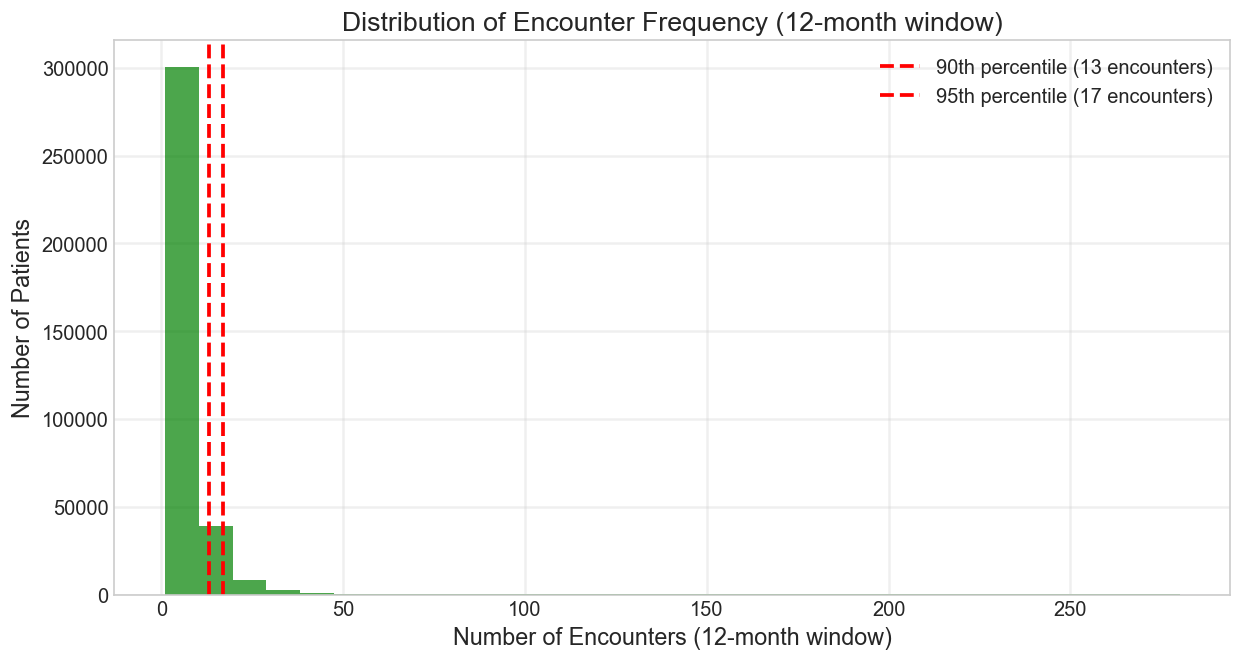

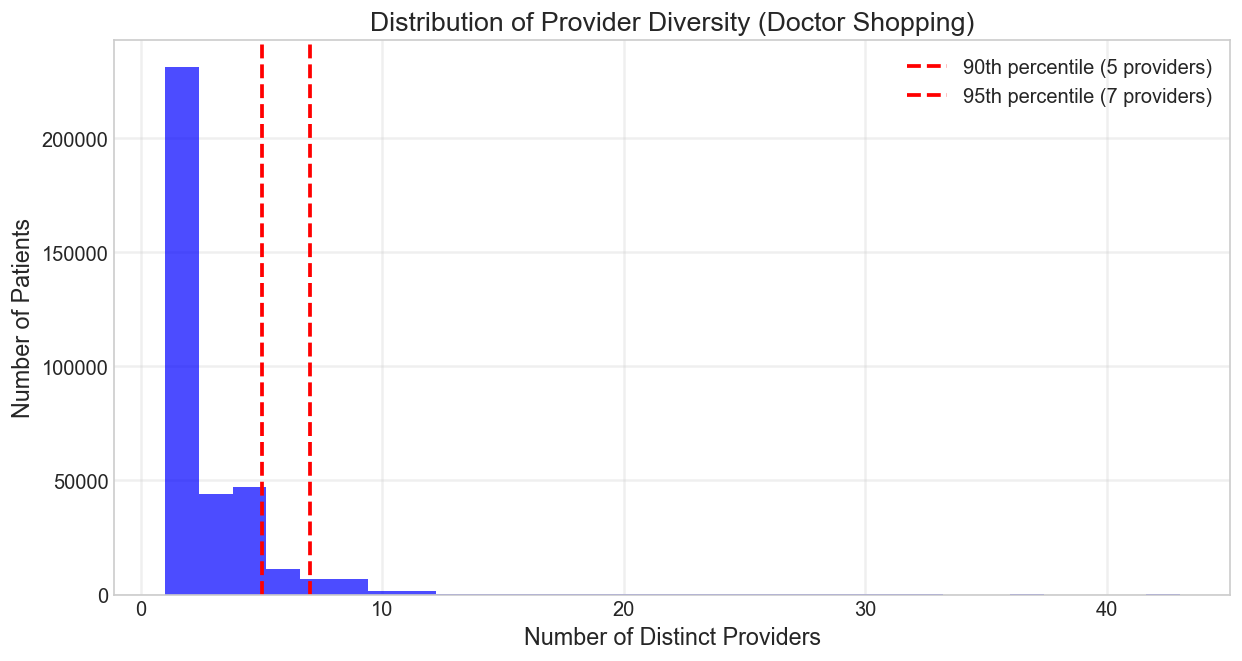

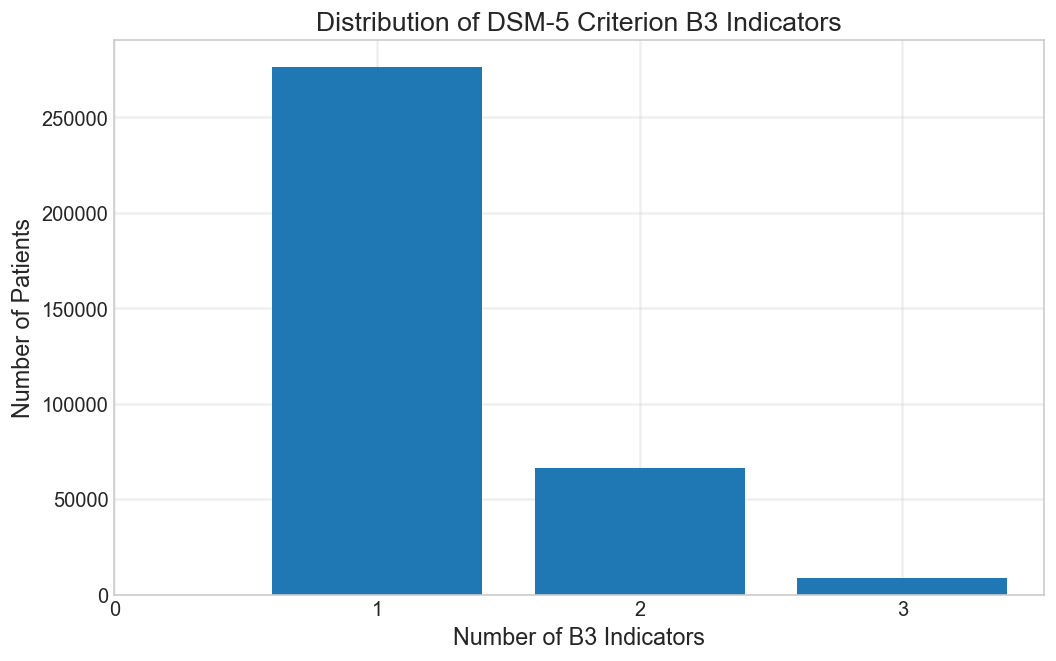

In [20]:
# ----------------------------------------------------------------------
# HEALTHCARE UTILIZATION AND DOCTOR SHOPPING ANALYSIS (DSM-5 CRITERION B3)
# ----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats

print("\n--- Healthcare Utilization Analysis (DSM-5 Criterion B3) ---")
print("Analyzing excessive time/energy devoted to health concerns and doctor shopping behavior")

# Check if encounter data is available
if 'encounter_df' not in globals() or not isinstance(encounter_df, pd.DataFrame):
    print("ERROR: Encounter data not found in globals(). Please load the dataset first.")
else:
    print(f"Encounter table shape: {encounter_df.shape}")
    
    # 1) Prepare the encounter data
    # Check available columns
    print("\nAvailable encounter columns:", encounter_df.columns.tolist())
    
    # Determine which columns to use
    date_col = None
    provider_col = None
    site_col = None
    reason_col = None
    encounter_type_col = None
    
    # Find date column
    for col in ['EncounterDate', 'date', 'visit_date']:
        if col in encounter_df.columns:
            date_col = col
            break
    
    # Find provider column
    for col in ['Provider_ID', 'provider_id', 'doctor_id']:
        if col in encounter_df.columns:
            provider_col = col
            break
    
    # Find site column
    for col in ['Site_ID', 'site_id', 'clinic_id']:
        if col in encounter_df.columns:
            site_col = col
            break
    
    # Find reason column
    for col in ['Reason_calc', 'Reason_orig', 'reason', 'chief_complaint']:
        if col in encounter_df.columns:
            reason_col = col
            break
    
    # Find encounter type column
    for col in ['EncounterType', 'visit_type', 'appointment_type']:
        if col in encounter_df.columns:
            encounter_type_col = col
            break
    
    # 2) Analyze encounter frequency
    print("\nAnalyzing encounter frequency...")
    
    # Get number of encounters per patient
    encounter_counts = encounter_df.groupby('Patient_ID').size().reset_index(name='encounter_count')
    
    # Summary statistics
    print("Summary statistics for encounters per patient:")
    print(encounter_counts['encounter_count'].describe())
    
    # Calculate percentiles for encounter frequency
    percentiles = [50, 75, 90, 95, 99]
    encounter_thresholds = {
        p: np.percentile(encounter_counts['encounter_count'], p)
        for p in percentiles
    }
    
    print("\nEncounter frequency thresholds (percentiles):")
    for p, threshold in encounter_thresholds.items():
        print(f"  {p}th percentile: ≥{threshold:.0f} encounters")
    
    # Flag high utilizers (patients above 90th percentile)
    high_utilizer_threshold = encounter_thresholds[90]
    high_utilizers = encounter_counts[encounter_counts['encounter_count'] >= high_utilizer_threshold]
    
    print(f"\nHigh utilizers (>90th percentile, ≥{high_utilizer_threshold:.0f} encounters): {len(high_utilizers)} patients")
    print(f"This represents {len(high_utilizers)/len(encounter_counts):.2%} of patients")
    
    # Calculate extremely high utilizers (above 95th percentile)
    very_high_threshold = encounter_thresholds[95]
    very_high_utilizers = encounter_counts[encounter_counts['encounter_count'] >= very_high_threshold]
    
    print(f"Extremely high utilizers (>95th percentile, ≥{very_high_threshold:.0f} encounters): {len(very_high_utilizers)} patients")
    print(f"This represents {len(very_high_utilizers)/len(encounter_counts):.2%} of patients")
    
    # 3) Time-dependent utilization patterns (using 12-month windows)
    if date_col is not None:
        print("\nAnalyzing 12-month utilization patterns...")
        
        # Convert date column to datetime
        encounter_df[date_col] = pd.to_datetime(encounter_df[date_col], errors='coerce')
        
        # For each patient, find the most recent encounter date
        patient_last_dates = encounter_df.groupby('Patient_ID')[date_col].max().reset_index(name='last_date')
        
        # Merge this back with the encounter data
        encounter_df = encounter_df.merge(patient_last_dates, on='Patient_ID', how='left')
        
        # Calculate days before last encounter
        encounter_df['days_before_last'] = (encounter_df['last_date'] - encounter_df[date_col]).dt.days
        
        # Filter to encounters within 12 months (365 days) of the patient's last encounter
        recent_encounters = encounter_df[encounter_df['days_before_last'] <= 365]
        
        # Count recent encounters by patient
        recent_encounter_counts = recent_encounters.groupby('Patient_ID').size().reset_index(name='recent_encounter_count')
        
        # Summary statistics for 12-month encounter counts
        print("Summary statistics for encounters per patient (12-month window):")
        print(recent_encounter_counts['recent_encounter_count'].describe())
        
        # Calculate percentiles for recent encounter frequency
        recent_thresholds = {
            p: np.percentile(recent_encounter_counts['recent_encounter_count'], p)
            for p in percentiles
        }
        
        print("\nRecent encounter frequency thresholds (percentiles):")
        for p, threshold in recent_thresholds.items():
            print(f"  {p}th percentile: ≥{threshold:.0f} encounters in 12 months")
        
        # Flag high recent utilizers (patients above 90th percentile)
        high_recent_threshold = recent_thresholds[90]
        high_recent_utilizers = recent_encounter_counts[recent_encounter_counts['recent_encounter_count'] >= high_recent_threshold]
        
        print(f"\nHigh recent utilizers (>90th percentile, ≥{high_recent_threshold:.0f} encounters in 12 months): {len(high_recent_utilizers)} patients")
        print(f"This represents {len(high_recent_utilizers)/len(recent_encounter_counts):.2%} of patients")
        
        # Save the high utilizers for DSM-5 Criterion B3 (excessive time/energy on symptoms)
        high_utilizer_patients = set(high_recent_utilizers['Patient_ID'])
        globals()['high_utilizer_patients'] = high_utilizer_patients
        
        # Visualize the distribution of recent encounters
        plt.figure(figsize=(12, 6))
        plt.hist(recent_encounter_counts['recent_encounter_count'], bins=30, alpha=0.7, color='green')
        for p in [90, 95]:
            plt.axvline(x=recent_thresholds[p], color='red', linestyle='--', 
                         label=f'{p}th percentile ({recent_thresholds[p]:.0f} encounters)')
        plt.xlabel('Number of Encounters (12-month window)')
        plt.ylabel('Number of Patients')
        plt.title('Distribution of Encounter Frequency (12-month window)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Calculate monthly encounter rate
        recent_encounters['month_number'] = (recent_encounters['days_before_last'] // 30)
        monthly_encounters = recent_encounters.groupby(['Patient_ID', 'month_number']).size().reset_index(name='encounters_in_month')
        
        # Average monthly encounters and max monthly encounters
        monthly_stats = monthly_encounters.groupby('Patient_ID').agg(
            avg_monthly_encounters=('encounters_in_month', 'mean'),
            max_monthly_encounters=('encounters_in_month', 'max'),
            months_with_encounters=('encounters_in_month', 'count')
        ).reset_index()
        
        # Flag patients with frequent visits (≥2 visits per month on average)
        frequent_visitors = monthly_stats[monthly_stats['avg_monthly_encounters'] >= 2]
        print(f"\nPatients averaging ≥2 visits per month: {len(frequent_visitors)} ({len(frequent_visitors)/len(monthly_stats):.2%})")
        
        # Flag patients with very frequent visits (≥4 visits in at least one month)
        very_frequent = monthly_stats[monthly_stats['max_monthly_encounters'] >= 4]
        print(f"Patients with ≥4 visits in at least one month: {len(very_frequent)} ({len(very_frequent)/len(monthly_stats):.2%})")
        
        # Flag patients with persistent utilization (visits in ≥6 different months)
        persistent_visitors = monthly_stats[monthly_stats['months_with_encounters'] >= 6]
        print(f"Patients with visits in ≥6 different months (over 12-month window): {len(persistent_visitors)} ({len(persistent_visitors)/len(monthly_stats):.2%})")
    
    # 4) Doctor shopping analysis
    if provider_col is not None:
        print("\nAnalyzing provider diversity (doctor shopping)...")
        
        # Count distinct providers per patient
        provider_diversity = encounter_df.groupby('Patient_ID')[provider_col].nunique().reset_index(name='provider_count')
        
        # Summary statistics
        print("Summary statistics for distinct providers per patient:")
        print(provider_diversity['provider_count'].describe())
        
        # Calculate percentiles
        provider_thresholds = {
            p: np.percentile(provider_diversity['provider_count'], p)
            for p in percentiles
        }
        
        print("\nProvider diversity thresholds (percentiles):")
        for p, threshold in provider_thresholds.items():
            print(f"  {p}th percentile: ≥{threshold:.0f} different providers")
        
        # Flag doctor shoppers (patients above 90th percentile)
        shopping_threshold = provider_thresholds[90]
        doctor_shoppers = provider_diversity[provider_diversity['provider_count'] >= shopping_threshold]
        
        print(f"\nDoctor shoppers (>90th percentile, ≥{shopping_threshold:.0f} providers): {len(doctor_shoppers)} patients")
        print(f"This represents {len(doctor_shoppers)/len(provider_diversity):.2%} of patients")
        
        # Calculate extreme doctor shoppers (above 95th percentile)
        extreme_shopping_threshold = provider_thresholds[95]
        extreme_shoppers = provider_diversity[provider_diversity['provider_count'] >= extreme_shopping_threshold]
        
        print(f"Extreme doctor shoppers (>95th percentile, ≥{extreme_shopping_threshold:.0f} providers): {len(extreme_shoppers)} patients")
        print(f"This represents {len(extreme_shoppers)/len(provider_diversity):.2%} of patients")
        
        # Save doctor shoppers for DSM-5 alignment
        doctor_shopper_patients = set(doctor_shoppers['Patient_ID'])
        globals()['doctor_shopper_patients'] = doctor_shopper_patients
        
        # Visualize the distribution of provider diversity
        plt.figure(figsize=(12, 6))
        plt.hist(provider_diversity['provider_count'], bins=30, alpha=0.7, color='blue')
        for p in [90, 95]:
            plt.axvline(x=provider_thresholds[p], color='red', linestyle='--', 
                         label=f'{p}th percentile ({provider_thresholds[p]:.0f} providers)')
        plt.xlabel('Number of Distinct Providers')
        plt.ylabel('Number of Patients')
        plt.title('Distribution of Provider Diversity (Doctor Shopping)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # If site data is available, analyze site diversity too
        if site_col is not None:
            print("\nAnalyzing site diversity...")
            
            # Count distinct sites per patient
            site_diversity = encounter_df.groupby('Patient_ID')[site_col].nunique().reset_index(name='site_count')
            
            # Summary statistics
            print("Summary statistics for distinct sites per patient:")
            print(site_diversity['site_count'].describe())
            
            # Calculate percentiles
            site_thresholds = {
                p: np.percentile(site_diversity['site_count'], p)
                for p in percentiles
            }
            
            print("\nSite diversity thresholds (percentiles):")
            for p, threshold in site_thresholds.items():
                print(f"  {p}th percentile: ≥{threshold:.0f} different sites")
            
            # Flag site shoppers (patients above 90th percentile)
            site_shopping_threshold = site_thresholds[90]
            site_shoppers = site_diversity[site_diversity['site_count'] >= site_shopping_threshold]
            
            print(f"\nSite shoppers (>90th percentile, ≥{site_shopping_threshold:.0f} sites): {len(site_shoppers)} patients")
            print(f"This represents {len(site_shoppers)/len(site_diversity):.2%} of patients")
            
            # Save site shoppers for later analysis
            site_shopper_patients = set(site_shoppers['Patient_ID'])
            globals()['site_shopper_patients'] = site_shopper_patients
            
            # Calculate combined shopping behavior (both providers and sites)
            combined_shoppers = doctor_shopper_patients.intersection(site_shopper_patients)
            print(f"\nPatients shopping for both providers AND sites: {len(combined_shoppers)} ({len(combined_shoppers)/len(encounter_counts):.2%} of all patients)")
            
            # Save these patients
            globals()['combined_shopper_patients'] = combined_shoppers
    
    # 5) Repeated visits for similar complaints
    if reason_col is not None:
        print("\nAnalyzing repeated visits for similar complaints...")
        
        # This requires text analysis, which can be complex
        # We'll do a simplified version looking for frequently recurring terms
        
        # First, check if the reason column has text data
        if encounter_df[reason_col].dtype == 'object':
            # Convert to lowercase for easier matching
            encounter_df['reason_lower'] = encounter_df[reason_col].fillna('').str.lower()
            
            # Define common symptom terms to look for
            symptom_terms = [
                'pain', 'headache', 'fatigue', 'tired', 'dizz', 'nause', 'short of breath',
                'chest', 'stomach', 'abdom', 'back', 'neck', 'joint', 'muscle', 'weak',
                'numb', 'tingle', 'anxiety', 'worry', 'stress', 'sleep', 'palpit'
            ]
            
            # Check each term
            for term in symptom_terms:
                encounter_df[f'has_{term}'] = encounter_df['reason_lower'].str.contains(term, regex=False)
            
            # For each patient, count visits with each symptom term
            patient_symptom_counts = {}
            
            for patient_id in encounter_df['Patient_ID'].unique():
                patient_data = encounter_df[encounter_df['Patient_ID'] == patient_id]
                
                symptom_counts = {}
                for term in symptom_terms:
                    symptom_counts[term] = patient_data[f'has_{term}'].sum()
                
                patient_symptom_counts[patient_id] = symptom_counts
            
            # Create a dataframe of symptom visit counts per patient
            symptom_visits_df = pd.DataFrame.from_dict(patient_symptom_counts, orient='index')
            symptom_visits_df.reset_index(inplace=True)
            symptom_visits_df.rename(columns={'index': 'Patient_ID'}, inplace=True)
            
            # Calculate the maximum symptom repetition for each patient
            symptom_visits_df['max_symptom_repetition'] = symptom_visits_df[symptom_terms].max(axis=1)
            
            # Flag patients with many repeated visits for the same symptom (≥3)
            repeated_symptom_patients = symptom_visits_df[symptom_visits_df['max_symptom_repetition'] >= 3]
            
            print(f"Patients with ≥3 visits for the same symptom: {len(repeated_symptom_patients)} ({len(repeated_symptom_patients)/len(symptom_visits_df):.2%})")
            
            # Top repeated symptoms
            most_common_symptoms = {}
            for term in symptom_terms:
                # Count patients with ≥3 visits for this symptom
                count = (symptom_visits_df[term] >= 3).sum()
                if count > 0:
                    most_common_symptoms[term] = count
            
            print("\nMost commonly repeated symptoms (≥3 visits):")
            for term, count in sorted(most_common_symptoms.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  - '{term}': {count} patients ({count/len(symptom_visits_df):.2%})")
            
            # Save patients with repeated symptom visits
            repeated_symptom_patient_ids = set(repeated_symptom_patients['Patient_ID'])
            globals()['repeated_symptom_patients'] = repeated_symptom_patient_ids
            
            # Calculate patients with multiple different repeated symptoms
            multi_symptom_counts = (symptom_visits_df[symptom_terms] >= 3).sum(axis=1)
            multi_symptom_patients = symptom_visits_df[multi_symptom_counts >= 2]
            
            print(f"\nPatients with multiple (≥2) different repeated symptoms: {len(multi_symptom_patients)} ({len(multi_symptom_patients)/len(symptom_visits_df):.2%})")
            
            # Save these patients
            multi_symptom_patient_ids = set(multi_symptom_patients['Patient_ID'])
            globals()['multi_symptom_patients'] = multi_symptom_patient_ids
    
    # 6) Emergency department visits or urgent care
    if encounter_type_col is not None:
        print("\nAnalyzing emergency/urgent care visits...")
        
        # First, check the distribution of encounter types
        print("Encounter type distribution:")
        enc_type_counts = encounter_df[encounter_type_col].value_counts()
        for enc_type, count in enc_type_counts.head(10).items():
            print(f"  - {enc_type}: {count} ({count/len(encounter_df):.2%})")
        
        # Look for ED or urgent care types
        emergency_keywords = ['emerg', 'urgent', 'ed visit', 'er visit']
        
        # Create a flag for emergency/urgent encounters
        encounter_df['is_emergency'] = encounter_df[encounter_type_col].fillna('').astype(str).str.lower().apply(
            lambda x: any(keyword in x for keyword in emergency_keywords)
        )
        
        # Count emergency visits per patient
        emergency_counts = encounter_df[encounter_df['is_emergency']].groupby('Patient_ID').size().reset_index(name='emergency_count')
        
        # Summary of emergency visits
        print(f"\nTotal emergency/urgent care visits: {encounter_df['is_emergency'].sum()}")
        print(f"Patients with any emergency visits: {len(emergency_counts)} ({len(emergency_counts)/len(encounter_counts):.2%})")
        
        if len(emergency_counts) > 0:
            print("\nSummary statistics for emergency visits per patient:")
            print(emergency_counts['emergency_count'].describe())
            
            # Identify frequent ED users (≥3 visits)
            frequent_ed_users = emergency_counts[emergency_counts['emergency_count'] >= 3]
            print(f"\nFrequent ED users (≥3 visits): {len(frequent_ed_users)} ({len(frequent_ed_users)/len(emergency_counts):.2%} of ED patients)")
            
            # Save these patients
            frequent_ed_patient_ids = set(frequent_ed_users['Patient_ID'])
            globals()['frequent_ed_patients'] = frequent_ed_patient_ids
    
    # 7) DSM-5 Criterion B3 integration
    print("\n--- DSM-5 Criterion B3 Analysis (Excessive Time/Energy on Symptoms) ---")
    
    # Define potential B3 indicators based on our analyses
    b3_indicators = []
    
    if 'high_utilizer_patients' in globals():
        b3_indicators.append(('high_encounter_rate', globals()['high_utilizer_patients']))
    
    if 'doctor_shopper_patients' in globals():
        b3_indicators.append(('doctor_shopping', globals()['doctor_shopper_patients']))
    
    if 'site_shopper_patients' in globals():
        b3_indicators.append(('site_shopping', globals()['site_shopper_patients']))
    
    if 'repeated_symptom_patients' in globals():
        b3_indicators.append(('repeated_symptom_visits', globals()['repeated_symptom_patients']))
    
    if 'frequent_ed_patients' in globals():
        b3_indicators.append(('frequent_ed_use', globals()['frequent_ed_patients']))
    
    # If we have at least one indicator, proceed with analysis
    if b3_indicators:
        # For each patient, count how many B3 indicators they have
        all_patients = set()
        for name, patient_set in b3_indicators:
            all_patients.update(patient_set)
        
        patient_indicators = {patient: 0 for patient in all_patients}
        
        for name, patient_set in b3_indicators:
            for patient in patient_set:
                patient_indicators[patient] += 1
        
        # Convert to dataframe for analysis
        b3_df = pd.DataFrame({
            'Patient_ID': list(patient_indicators.keys()),
            'b3_indicator_count': list(patient_indicators.values())
        })
        
        # Summary of B3 indicators
        print("Distribution of DSM-5 Criterion B3 indicators per patient:")
        indicator_counts = b3_df['b3_indicator_count'].value_counts().sort_index()
        for count, frequency in indicator_counts.items():
            print(f"  - {count} indicators: {frequency} patients ({frequency/len(b3_df):.2%})")
        
        # Define different thresholds for Criterion B3
        b3_thresholds = {
            'strict': 3,  # At least 3 different indicators
            'moderate': 2,  # At least 2 different indicators
            'lenient': 1   # At least 1 indicator
        }
        
        # Apply thresholds
        for name, threshold in b3_thresholds.items():
            meeting_b3 = b3_df[b3_df['b3_indicator_count'] >= threshold]
            print(f"\nPatients meeting Criterion B3 ({name} threshold, ≥{threshold} indicators): {len(meeting_b3)} ({len(meeting_b3)/len(b3_df):.2%})")
        
        # Save patients meeting moderate threshold for B3
        b3_patients = set(b3_df[b3_df['b3_indicator_count'] >= b3_thresholds['moderate']]['Patient_ID'])
        globals()['dsm5_criterion_b3_patients'] = b3_patients
        
        # Visualize B3 indicator distribution
        plt.figure(figsize=(10, 6))
        plt.bar(indicator_counts.index, indicator_counts.values)
        plt.xlabel('Number of B3 Indicators')
        plt.ylabel('Number of Patients')
        plt.title('Distribution of DSM-5 Criterion B3 Indicators')
        plt.xticks(range(len(indicator_counts) + 1))
        plt.grid(True, alpha=0.3)
        
        # 8) Create B3 features dataframe
        print("\nCreating B3 features dataframe...")
        
        # Start with all patients
        all_patients = set(encounter_df['Patient_ID'].unique())
        
        # Create the dataframe
        b3_features = pd.DataFrame({'Patient_ID': list(all_patients)})
        
        # Add encounter counts
        b3_features = b3_features.merge(encounter_counts, on='Patient_ID', how='left')
        b3_features['encounter_count'] = b3_features['encounter_count'].fillna(0)
        
        # Add recent encounter counts if available
        if 'recent_encounter_counts' in locals():
            b3_features = b3_features.merge(recent_encounter_counts, on='Patient_ID', how='left')
            b3_features['recent_encounter_count'] = b3_features['recent_encounter_count'].fillna(0)
        
        # Add provider diversity if available
        if 'provider_diversity' in locals():
            b3_features = b3_features.merge(provider_diversity, on='Patient_ID', how='left')
            b3_features['provider_count'] = b3_features['provider_count'].fillna(0)
        
        # Add site diversity if available
        if 'site_diversity' in locals():
            b3_features = b3_features.merge(site_diversity, on='Patient_ID', how='left')
            b3_features['site_count'] = b3_features['site_count'].fillna(0)
        
        # Add monthly stats if available
        if 'monthly_stats' in locals():
            b3_features = b3_features.merge(monthly_stats, on='Patient_ID', how='left')
            for col in ['avg_monthly_encounters', 'max_monthly_encounters', 'months_with_encounters']:
                if col in b3_features.columns:
                    b3_features[col] = b3_features[col].fillna(0)
        
        # Add symptom repetition if available
        if 'symptom_visits_df' in locals():
            symptom_cols = ['max_symptom_repetition'] + symptom_terms
            b3_features = b3_features.merge(symptom_visits_df[['Patient_ID'] + symptom_cols], on='Patient_ID', how='left')
            for col in symptom_cols:
                if col in b3_features.columns:
                    b3_features[col] = b3_features[col].fillna(0)
        
        # Add emergency visit counts if available
        if 'emergency_counts' in locals():
            b3_features = b3_features.merge(emergency_counts, on='Patient_ID', how='left')
            b3_features['emergency_count'] = b3_features['emergency_count'].fillna(0)
        
        # Add B3 indicator flags
        for name, patient_set in b3_indicators:
            b3_features[f'is_{name}'] = b3_features['Patient_ID'].isin(patient_set).astype(int)
        
        # Add B3 indicator count
        if 'b3_df' in locals():
            b3_features = b3_features.merge(b3_df, on='Patient_ID', how='left')
            b3_features['b3_indicator_count'] = b3_features['b3_indicator_count'].fillna(0)
        
        # Add DSM-5 B3 criterion flag
        if 'dsm5_criterion_b3_patients' in globals():
            b3_features['dsm5_criterion_b3'] = b3_features['Patient_ID'].isin(globals()['dsm5_criterion_b3_patients']).astype(int)
        
        # Save the dataframe
        globals()['utilization_features_df'] = b3_features
        
        print(f"Created B3 features dataframe with {len(b3_features)} rows and {len(b3_features.columns)} columns")
        
        # 9) Combine with previous DSM-5 criteria
        print("\n--- Combined DSM-5 Criteria Analysis ---")
        
        # Check if we have previous criteria data
        have_a = ('dsm5_criterion_a_full_patients' in globals() and 
                 globals()['dsm5_criterion_a_full_patients'] is not None)
        
        have_b2 = ('dsm5_criterion_b2_patients' in globals() and 
                  globals()['dsm5_criterion_b2_patients'] is not None)
        
        have_b3 = ('dsm5_criterion_b3_patients' in globals() and 
                  globals()['dsm5_criterion_b3_patients'] is not None)
        
        if have_a and have_b2 and have_b3:
            # Get the patient sets
            criterion_a_patients = globals()['dsm5_criterion_a_full_patients']
            criterion_b2_patients = globals()['dsm5_criterion_b2_patients']
            criterion_b3_patients = globals()['dsm5_criterion_b3_patients']
            
            # Find various combinations
            a_b2_patients = criterion_a_patients.intersection(criterion_b2_patients)
            a_b3_patients = criterion_a_patients.intersection(criterion_b3_patients)
            b2_b3_patients = criterion_b2_patients.intersection(criterion_b3_patients)
            
            # Full DSM-5 pattern: A + B2 + B3
            full_dsm5_pattern = criterion_a_patients.intersection(criterion_b2_patients).intersection(criterion_b3_patients)
            
            # Print results
            print(f"Patients meeting Criterion A (multiple persistent symptoms): {len(criterion_a_patients)}")
            print(f"Patients meeting Criterion B2 (persistent anxiety): {len(criterion_b2_patients)}")
            print(f"Patients meeting Criterion B3 (excessive time/energy): {len(criterion_b3_patients)}")
            
            print(f"\nPatients meeting Criteria A+B2: {len(a_b2_patients)}")
            print(f"Patients meeting Criteria A+B3: {len(a_b3_patients)}")
            print(f"Patients meeting Criteria B2+B3: {len(b2_b3_patients)}")
            
            print(f"\nPatients meeting full DSM-5 pattern (A+B2+B3): {len(full_dsm5_pattern)}")
            
            # Calculate as percentage of total patients
            total_patients = len(encounter_counts)
            print(f"This represents {len(full_dsm5_pattern)/total_patients:.2%} of all patients")
            
            # Save full pattern patients
            globals()['dsm5_full_criteria_patients'] = full_dsm5_pattern
            
            # Optional: Alternative criteria combinations
            # DSM-5 requires A + at least one B criterion, so A+(B2 or B3) is valid
            alt_criteria = criterion_a_patients.intersection(criterion_b2_patients.union(criterion_b3_patients))
            print(f"\nPatients meeting alternative criteria A+(B2 or B3): {len(alt_criteria)}")
            print(f"This represents {len(alt_criteria)/total_patients:.2%} of all patients")
            
            # Save these patients
            globals()['dsm5_alt_criteria_patients'] = alt_criteria
        
        # 10) Combine all feature dataframes if available
        if ('ssd_features_df' in globals() and 
            'utilization_features_df' in globals()):
            
            print("\nCombining all feature dataframes...")
            
            ssd_df = globals()['ssd_features_df']
            util_df = globals()['utilization_features_df']
            
            # Merge the dataframes
            combined_features = ssd_df.merge(util_df, on='Patient_ID', how='outer')
            
            # Add the full criteria flag if available
            if 'dsm5_full_criteria_patients' in globals():
                combined_features['dsm5_full_criteria'] = combined_features['Patient_ID'].isin(globals()['dsm5_full_criteria_patients']).astype(int)
            
            if 'dsm5_alt_criteria_patients' in globals():
                combined_features['dsm5_alt_criteria'] = combined_features['Patient_ID'].isin(globals()['dsm5_alt_criteria_patients']).astype(int)
            
            # Save the combined features
            globals()['combined_features_df'] = combined_features
            
            print(f"Created combined features dataframe with {len(combined_features)} rows and {len(combined_features.columns)} columns")
            
            # 11) Visualize the distribution of DSM-5 criteria combinations
            if ('dsm5_criterion_a_full' in combined_features.columns and
                'dsm5_criterion_b2_anxiety' in combined_features.columns and
                'dsm5_criterion_b3' in combined_features.columns):
                
                # Create a combined criteria field for visualization
                combined_features['criteria_combination'] = (
                    (combined_features['dsm5_criterion_a_full'] * 4) + 
                    (combined_features['dsm5_criterion_b2_anxiety'] * 2) + 
                    (combined_features['dsm5_criterion_b3'] * 1)
                )
                
                # Map the values to combinations
                criteria_map = {
                    0: 'None',
                    1: 'B3 only',
                    2: 'B2 only',
                    3: 'B2+B3',
                    4: 'A only',
                    5: 'A+B3',
                    6: 'A+B2',
                    7: 'A+B2+B3 (Full)'
                }
                
                combined_features['criteria_label'] = combined_features['criteria_combination'].map(criteria_map)
                
                # Count by combination
                criteria_counts = combined_features['criteria_label'].value_counts()
                
                # Print the distribution
                print("\nDistribution of DSM-5 criteria combinations:")
                total = len(combined_features)
                for combination, count in criteria_counts.items():
                    print(f"  - {combination}: {count} patients ({count/total:.2%})")
                
                # Visualize
                plt.figure(figsize=(12, 6))
                criteria_counts.plot(kind='bar', color='purple')
                plt.xlabel('DSM-5 Criteria Combination')
                plt.ylabel('Number of Patients')
                plt.title('Distribution of DSM-5 Criteria Combinations')
                plt.grid(True, alpha=0.3)
                plt.xticks(rotation=45)
                
                # 12) Final summary of SSD candidates
                print("\n--- Final Summary of SSD Candidates ---")
                
                if 'dsm5_full_criteria' in combined_features.columns:
                    full_criteria_count = combined_features['dsm5_full_criteria'].sum()
                    print(f"Patients meeting full DSM-5 criteria (A+B2+B3): {full_criteria_count} ({full_criteria_count/len(combined_features):.2%})")
                
                if 'dsm5_alt_criteria' in combined_features.columns:
                    alt_criteria_count = combined_features['dsm5_alt_criteria'].sum()
                    print(f"Patients meeting alternative criteria (A+(B2 or B3)): {alt_criteria_count} ({alt_criteria_count/len(combined_features):.2%})")
                
                # Define SSD candidate tiers
                if ('dsm5_full_criteria' in combined_features.columns and
                    'dsm5_alt_criteria' in combined_features.columns):
                    
                    # Tier 1: Patients meeting full criteria
                    tier1 = combined_features[combined_features['dsm5_full_criteria'] == 1]
                    
                    # Tier 2: Patients meeting alternative criteria but not full criteria
                    tier2 = combined_features[
                        (combined_features['dsm5_alt_criteria'] == 1) & 
                        (combined_features['dsm5_full_criteria'] == 0)
                    ]
                    
                    # Tier 3: Patients with somatoform diagnosis or multiple criteria indicators
                    # but not meeting formal criteria
                    if 'has_somatoform_dx' in combined_features.columns:
                        tier3 = combined_features[
                            (combined_features['has_somatoform_dx'] == 1) & 
                            (combined_features['dsm5_alt_criteria'] == 0)
                        ]
                        
                        print("\nSSD candidate tiers:")
                        print(f"  - Tier 1 (full criteria): {len(tier1)} patients ({len(tier1)/len(combined_features):.2%})")
                        print(f"  - Tier 2 (alternative criteria): {len(tier2)} patients ({len(tier2)/len(combined_features):.2%})")
                        print(f"  - Tier 3 (somatoform diagnosis): {len(tier3)} patients ({len(tier3)/len(combined_features):.2%})")
                        
                        # Save these tiers for further analysis
                        globals()['ssd_tier1_patients'] = set(tier1['Patient_ID'])
                        globals()['ssd_tier2_patients'] = set(tier2['Patient_ID'])
                        globals()['ssd_tier3_patients'] = set(tier3['Patient_ID'])
                        
                        # Print total SSD candidates
                        total_ssd = len(tier1) + len(tier2) + len(tier3)
                        print(f"\nTotal SSD candidates (all tiers): {total_ssd} patients ({total_ssd/len(combined_features):.2%})")
    else:
        print("\nWarning: No encounter date column found. Cannot analyze recent utilization patterns.")

# Check 5: Comorbidity Analysis for Medical Necessity Differentiation



--- Comorbidity Analysis for Medical Necessity Differentiation ---
Distinguishing between medically-justified utilization and SSD-driven patterns
Encounter diagnosis table shape: (12471764, 25)

Available diagnosis columns: ['EncounterDiagnosis_ID', 'Network_ID', 'Site_ID', 'Patient_ID', 'Encounter_ID', 'Cycle_ID', 'DiagnosisText_orig', 'DiagnosisText_calc', 'DiagnosisCodeType_orig', 'DiagnosisCodeType_calc', 'DiagnosisCode_orig', 'DiagnosisCode_calc', 'DateCreated', 'orphan_encounter', 'is_general_symptom', 'is_neurological_symptom', 'is_cardiovascular_symptom', 'is_respiratory_symptom', 'is_gastrointestinal_symptom', 'is_genitourinary_symptom', 'is_musculoskeletal_symptom', 'is_skin_sensory_symptom', 'is_somatoform_disorder', 'is_anxiety_disorder', 'is_somatic_symptom']

Identifying chronic conditions...

Chronic condition diagnoses in the dataset:
  - Hypertension: 546777 diagnoses (4.38% of all diagnoses)
  - Diabetes mellitus: 298080 diagnoses (2.39% of all diagnoses)
  - Cancer 

C:\Users\ProjectC4M\AppData\Local\Temp\ipykernel_48124\2147953918.py:697: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.25       0.         0.33333333 ... 1.5        1.         0.2       ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  unexplained_df.loc[mask, 'symptom_condition_ratio'] = (


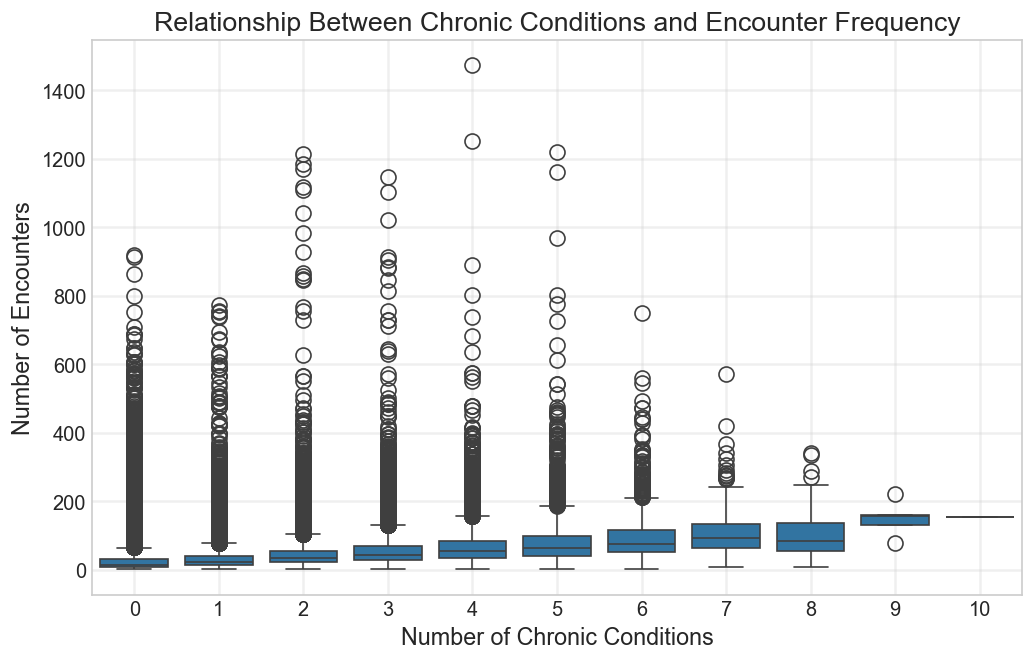

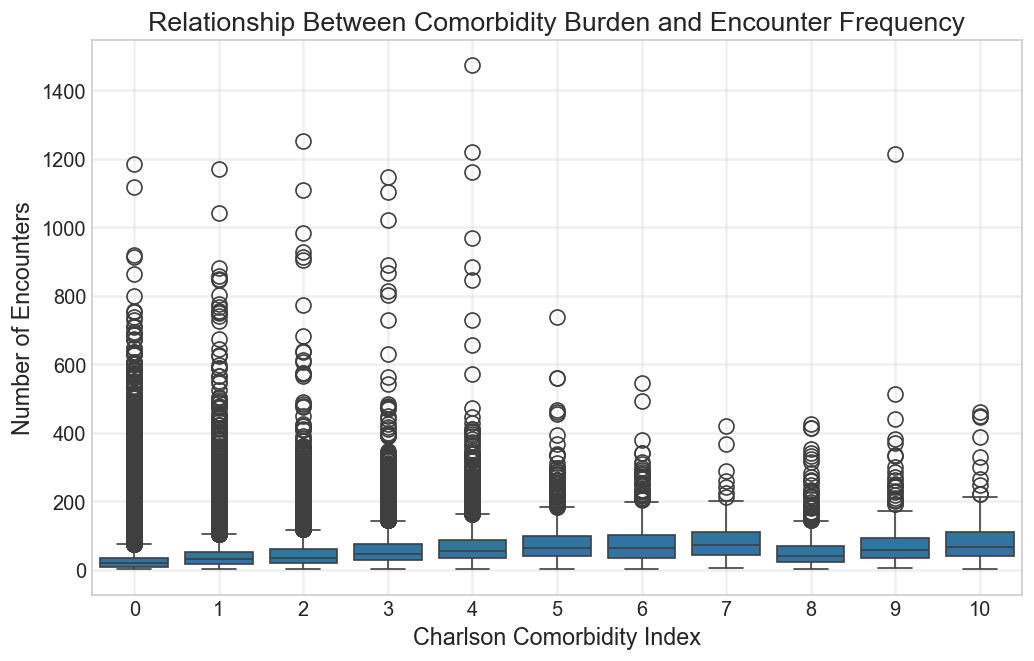

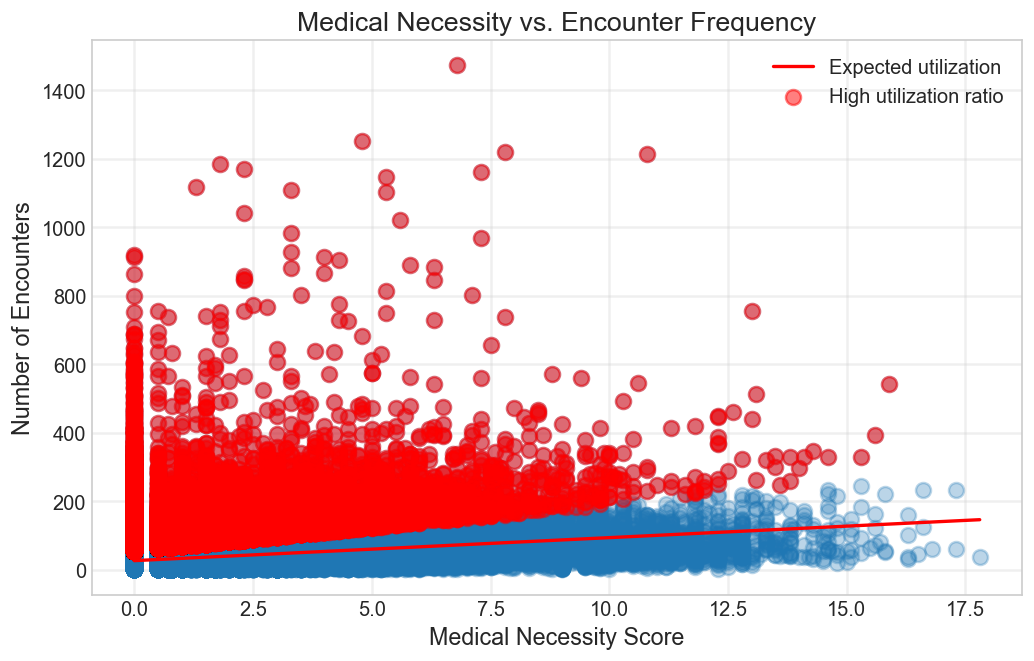

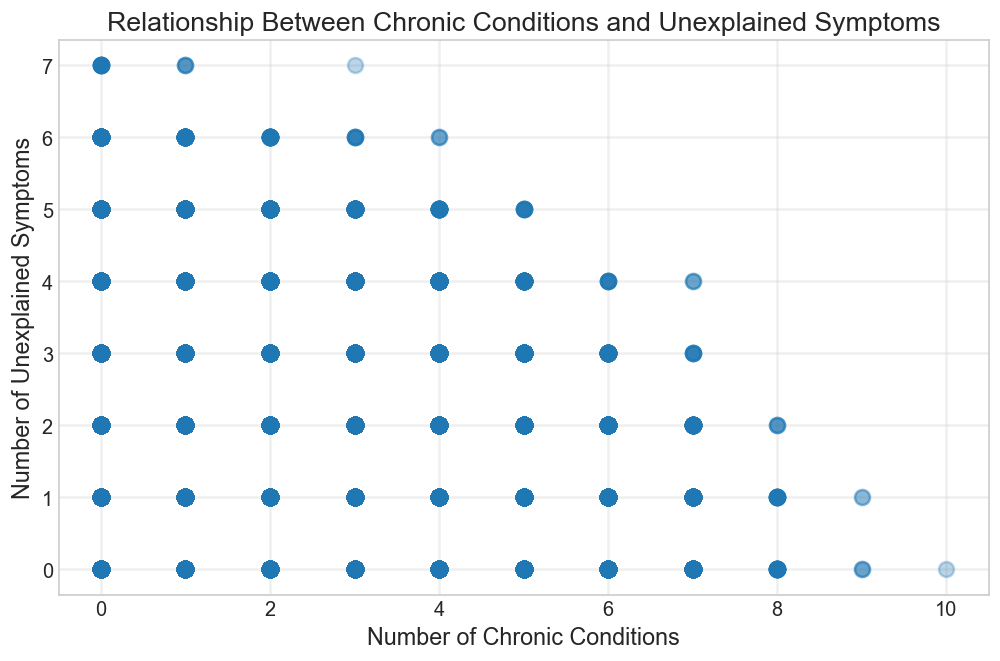

In [21]:
# ----------------------------------------------------------------------
# COMORBIDITY ANALYSIS FOR MEDICAL NECESSITY DIFFERENTIATION
# ----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from sklearn.linear_model import LinearRegression
from scipy import stats

print("\n--- Comorbidity Analysis for Medical Necessity Differentiation ---")
print("Distinguishing between medically-justified utilization and SSD-driven patterns")

# Check if we have the necessary data
if 'encdiag_df' not in globals() or not isinstance(encdiag_df, pd.DataFrame):
    print("ERROR: Encounter diagnosis data not found in globals(). Please load the dataset first.")
else:
    print(f"Encounter diagnosis table shape: {encdiag_df.shape}")
    
    # 1) Define chronic conditions using ICD codes
    # These are conditions that might justify increased healthcare utilization
    chronic_conditions = {
        'diabetes': {
            'icd9': ['^250'],
            'icd10': ['^E1[0-4]'],
            'description': 'Diabetes mellitus'
        },
        'hypertension': {
            'icd9': ['^401', '^402', '^403', '^404', '^405'],
            'icd10': ['^I1[0-5]'],
            'description': 'Hypertension'
        },
        'heart_disease': {
            'icd9': ['^39[0-3]', '^394', '^395', '^396', '^397', '^398', '^41[0-4]', '^42[0-9]'],
            'icd10': ['^I0[5-9]', '^I1[1-3]', '^I2[0-5]', '^I4[0-9]', '^I5[0-9]'],
            'description': 'Heart disease (including coronary, valvular, and heart failure)'
        },
        'asthma_copd': {
            'icd9': ['^49[0-6]', '^491', '^492', '^493', '^494', '^495', '^496'],
            'icd10': ['^J4[0-7]'],
            'description': 'Asthma and COPD'
        },
        'cancer': {
            'icd9': ['^14[0-9]', '^15[0-9]', '^16[0-9]', '^17[0-9]', '^18[0-9]', '^19[0-9]', '^20[0-9]', '^21[0-9]', '^22[0-9]', '^23[0-9]', '^234', '^235', '^236', '^237', '^238', '^239'],
            'icd10': ['^C[0-9]', '^D0', '^D1', '^D2', '^D3[0-9]', '^D4[0-8]'],
            'description': 'Cancer (malignant neoplasms and history of cancer)'
        },
        'autoimmune': {
            'icd9': ['^71[0-4]', '^725', '^710', '^714', '^720'],
            'icd10': ['^M0[5-8]', '^M3[0-6]', '^L4[0-5]'],
            'description': 'Autoimmune disorders (including rheumatoid arthritis, lupus, MS)'
        },
        'thyroid': {
            'icd9': ['^24[0-6]'],
            'icd10': ['^E0[0-7]'],
            'description': 'Thyroid disorders'
        },
        'kidney_disease': {
            'icd9': ['^58[0-9]', '^585'],
            'icd10': ['^N1[7-9]', '^N0[0-8]'],
            'description': 'Chronic kidney disease'
        },
        'liver_disease': {
            'icd9': ['^57[0-3]', '^070'],
            'icd10': ['^K7[0-7]', '^B1[5-9]'],
            'description': 'Chronic liver disease and hepatitis'
        },
        'stroke': {
            'icd9': ['^43[0-8]', '^438'],
            'icd10': ['^I6[0-9]', '^I69'],
            'description': 'Stroke and cerebrovascular disease'
        },
        'epilepsy': {
            'icd9': ['^345'],
            'icd10': ['^G40'],
            'description': 'Epilepsy and seizure disorders'
        },
        'dementia': {
            'icd9': ['^290', '^294', '^331'],
            'icd10': ['^F0[0-3]', '^G30', '^G31'],
            'description': 'Dementia and cognitive disorders'
        }
    }
    
    # Calculate Charlson Comorbidity Index weights
    charlson_conditions = {
        'myocardial_infarction': {
            'icd9': ['^410', '^412'],
            'icd10': ['^I21', '^I22', '^I25.2'],
            'weight': 1
        },
        'congestive_heart_failure': {
            'icd9': ['^428'],
            'icd10': ['^I50'],
            'weight': 1
        },
        'peripheral_vascular_disease': {
            'icd9': ['^441', '^443.9', '^785.4', '^V43.4'],
            'icd10': ['^I70', '^I71', '^I73.9', '^I79.0', '^Z95.8', '^Z95.9'],
            'weight': 1
        },
        'cerebrovascular_disease': {
            'icd9': ['^430', '^431', '^432', '^433', '^434', '^435', '^436', '^437', '^438'],
            'icd10': ['^G45', '^G46', '^I60', '^I61', '^I62', '^I63', '^I64', '^I65', '^I66', '^I67', '^I68', '^I69'],
            'weight': 1
        },
        'dementia': {
            'icd9': ['^290'],
            'icd10': ['^F00', '^F01', '^F02', '^F03', '^F05.1', '^G30'],
            'weight': 1
        },
        'chronic_pulmonary_disease': {
            'icd9': ['^490', '^491', '^492', '^493', '^494', '^495', '^496', '^500', '^501', '^502', '^503', '^504', '^505', '^506.4'],
            'icd10': ['^J40', '^J41', '^J42', '^J43', '^J44', '^J45', '^J46', '^J47', '^J60', '^J61', '^J62', '^J63', '^J64', '^J65', '^J66', '^J67'],
            'weight': 1
        },
        'rheumatic_disease': {
            'icd9': ['^710.0', '^710.1', '^710.4', '^714.0', '^714.1', '^714.2', '^714.81', '^725'],
            'icd10': ['^M05', '^M06', '^M31.5', '^M32', '^M33', '^M34', '^M35.1', '^M35.3', '^M36.0'],
            'weight': 1
        },
        'peptic_ulcer_disease': {
            'icd9': ['^531', '^532', '^533', '^534'],
            'icd10': ['^K25', '^K26', '^K27', '^K28'],
            'weight': 1
        },
        'mild_liver_disease': {
            'icd9': ['^571.2', '^571.4', '^571.5', '^571.6'],
            'icd10': ['^B18', '^K70.0', '^K70.1', '^K70.2', '^K70.3', '^K70.9', '^K71.3', '^K71.4', '^K71.5', '^K71.7', '^K73', '^K74', '^K76.0', '^K76.2', '^K76.3', '^K76.4', '^K76.8', '^K76.9', '^Z94.4'],
            'weight': 1
        },
        'diabetes_uncomplicated': {
            'icd9': ['^250.0', '^250.1', '^250.2', '^250.3', '^250.8', '^250.9'],
            'icd10': ['^E10.0', '^E10.1', '^E10.9', '^E11.0', '^E11.1', '^E11.9', '^E13.0', '^E13.1', '^E13.9', '^E14.0', '^E14.1', '^E14.9'],
            'weight': 1
        },
        'diabetes_complicated': {
            'icd9': ['^250.4', '^250.5', '^250.6', '^250.7'],
            'icd10': ['^E10.2', '^E10.3', '^E10.4', '^E10.5', '^E10.6', '^E10.7', '^E10.8', '^E11.2', '^E11.3', '^E11.4', '^E11.5', '^E11.6', '^E11.7', '^E11.8', '^E13.2', '^E13.3', '^E13.4', '^E13.5', '^E13.6', '^E13.7', '^E13.8', '^E14.2', '^E14.3', '^E14.4', '^E14.5', '^E14.6', '^E14.7', '^E14.8'],
            'weight': 2
        },
        'hemiplegia_paraplegia': {
            'icd9': ['^342', '^343', '^344.0', '^344.1', '^344.2', '^344.3', '^344.4', '^344.5', '^344.6', '^344.9'],
            'icd10': ['^G04.1', '^G11.4', '^G80.1', '^G80.2', '^G81', '^G82', '^G83.0', '^G83.1', '^G83.2', '^G83.3', '^G83.4', '^G83.9'],
            'weight': 2
        },
        'renal_disease': {
            'icd9': ['^403.01', '^403.11', '^403.91', '^404.02', '^404.03', '^404.12', '^404.13', '^404.92', '^404.93', '^582', '^583.0', '^583.1', '^583.2', '^583.3', '^583.4', '^583.5', '^583.6', '^583.7', '^585', '^586', '^588.0', '^V42.0', '^V45.1', '^V56'],
            'icd10': ['^I12.0', '^I13.1', '^N03.2', '^N03.3', '^N03.4', '^N03.5', '^N03.6', '^N03.7', '^N05.2', '^N05.3', '^N05.4', '^N05.5', '^N05.6', '^N05.7', '^N18', '^N19', '^N25.0', '^Z49.0', '^Z49.1', '^Z49.2', '^Z94.0', '^Z99.2'],
            'weight': 2
        },
        'malignancy': {
            'icd9': ['^140', '^141', '^142', '^143', '^144', '^145', '^146', '^147', '^148', '^149', '^150', '^151', '^152', '^153', '^154', '^155', '^156', '^157', '^158', '^159', '^160', '^161', '^162', '^163', '^164', '^165', '^166', '^167', '^168', '^169', '^170', '^171', '^172', '^174', '^175', '^176', '^177', '^178', '^179', '^180', '^181', '^182', '^183', '^184', '^185', '^186', '^187', '^188', '^189', '^190', '^191', '^192', '^193', '^194', '^195', '^196', '^197', '^198', '^199', '^200', '^201', '^202', '^203', '^204', '^205', '^206', '^207', '^208', '^238.6'],
            'icd10': ['^C00', '^C01', '^C02', '^C03', '^C04', '^C05', '^C06', '^C07', '^C08', '^C09', '^C10', '^C11', '^C12', '^C13', '^C14', '^C15', '^C16', '^C17', '^C18', '^C19', '^C20', '^C21', '^C22', '^C23', '^C24', '^C25', '^C26', '^C30', '^C31', '^C32', '^C33', '^C34', '^C37', '^C38', '^C39', '^C40', '^C41', '^C43', '^C45', '^C46', '^C47', '^C48', '^C49', '^C50', '^C51', '^C52', '^C53', '^C54', '^C55', '^C56', '^C57', '^C58', '^C60', '^C61', '^C62', '^C63', '^C64', '^C65', '^C66', '^C67', '^C68', '^C69', '^C70', '^C71', '^C72', '^C73', '^C74', '^C75', '^C76', '^C81', '^C82', '^C83', '^C84', '^C85', '^C88', '^C90', '^C91', '^C92', '^C93', '^C94', '^C95', '^C96', '^C97'],
            'weight': 2
        },
        'severe_liver_disease': {
            'icd9': ['^456.0', '^456.1', '^456.2', '^572.2', '^572.3', '^572.4', '^572.5', '^572.6', '^572.7', '^572.8'],
            'icd10': ['^I85.0', '^I85.9', '^I86.4', '^I98.2', '^K70.4', '^K71.1', '^K72.1', '^K72.9', '^K76.5', '^K76.6', '^K76.7'],
            'weight': 3
        },
        'metastatic_solid_tumor': {
            'icd9': ['^196', '^197', '^198', '^199'],
            'icd10': ['^C77', '^C78', '^C79', '^C80'],
            'weight': 6
        },
        'aids': {
            'icd9': ['^042', '^043', '^044'],
            'icd10': ['^B20', '^B21', '^B22', '^B24'],
            'weight': 6
        }
    }
    
    # 2) Prepare for analyzing diagnosis data
    # Check available columns
    print("\nAvailable diagnosis columns:", encdiag_df.columns.tolist())
    
    # Determine which columns to use for diagnosis codes and types
    code_col = None
    code_type_col = None
    
    # Find diagnosis code column
    for col in ['DiagnosisCode_calc', 'DiagnosisCode_orig', 'diagnosis_code', 'icd_code']:
        if col in encdiag_df.columns:
            code_col = col
            break
    
    # Find diagnosis code type column
    for col in ['DiagnosisCodeType_calc', 'DiagnosisCodeType_orig', 'code_type', 'icd_type']:
        if col in encdiag_df.columns:
            code_type_col = col
            break
    
    # 3) Function to check if a code matches patterns for a specific condition
    def match_code_to_condition(code, code_type, condition_patterns):
        if pd.isna(code) or pd.isna(code_type):
            return False
            
        code_str = str(code).strip()
        code_type_str = str(code_type).strip().upper()
        
        # Determine if it's ICD-9 or ICD-10
        if 'ICD9' in code_type_str:
            patterns = condition_patterns.get('icd9', [])
        elif 'ICD10' in code_type_str:
            patterns = condition_patterns.get('icd10', [])
        else:
            return False
        
        # Check if code matches any pattern
        for pattern in patterns:
            if re.match(pattern, code_str):
                return True
        
        return False
    
    # 4) Identify chronic conditions
    if code_col is not None and code_type_col is not None:
        print("\nIdentifying chronic conditions...")
        
        # Create flags for each chronic condition
        for condition, patterns in chronic_conditions.items():
            encdiag_df[f'is_{condition}'] = encdiag_df.apply(
                lambda row: match_code_to_condition(row[code_col], row[code_type_col], patterns),
                axis=1
            )
        
        # Create flags for Charlson comorbidity conditions
        for condition, info in charlson_conditions.items():
            encdiag_df[f'is_{condition}'] = encdiag_df.apply(
                lambda row: match_code_to_condition(row[code_col], row[code_type_col], info),
                axis=1
            )
        
        # Count diagnosed conditions
        condition_counts = {
            condition: encdiag_df[f'is_{condition}'].sum()
            for condition in chronic_conditions.keys()
        }
        
        # Print results
        print("\nChronic condition diagnoses in the dataset:")
        for condition, count in sorted(condition_counts.items(), key=lambda x: x[1], reverse=True):
            if count > 0:
                description = chronic_conditions[condition]['description']
                print(f"  - {description}: {count} diagnoses ({count/len(encdiag_df):.2%} of all diagnoses)")
        
        # 5) Patient-level analysis
        # For each patient, identify their chronic conditions and calculate Charlson Index
        patient_conditions = {}
        
        for patient_id in encdiag_df['Patient_ID'].unique():
            patient_data = encdiag_df[encdiag_df['Patient_ID'] == patient_id]
            
            # Check chronic conditions
            condition_flags = {}
            for condition in chronic_conditions.keys():
                condition_flags[condition] = patient_data[f'is_{condition}'].any()
            
            # Calculate Charlson Index
            charlson_index = 0
            charlson_flags = {}
            
            for condition, info in charlson_conditions.items():
                has_condition = patient_data[f'is_{condition}'].any()
                charlson_flags[condition] = has_condition
                
                if has_condition:
                    charlson_index += info['weight']
            
            # Count conditions
            conditions_count = sum(condition_flags.values())
            
            # Store results
            patient_conditions[patient_id] = {
                'condition_count': conditions_count,
                'conditions': [cond for cond, flag in condition_flags.items() if flag],
                'charlson_index': charlson_index,
                'charlson_conditions': [cond for cond, flag in charlson_flags.items() if flag]
            }
        
        # Analyze the distribution of chronic condition counts
        condition_count_distribution = {}
        for patient, data in patient_conditions.items():
            count = data['condition_count']
            if count not in condition_count_distribution:
                condition_count_distribution[count] = 0
            condition_count_distribution[count] += 1
        
        # Analyze Charlson Index distribution
        charlson_distribution = {}
        for patient, data in patient_conditions.items():
            score = data['charlson_index']
            if score not in charlson_distribution:
                charlson_distribution[score] = 0
            charlson_distribution[score] += 1
        
        # Total patients
        total_patients = len(patient_conditions)
        
        print(f"\nTotal patients analyzed: {total_patients}")
        print("\nDistribution of chronic conditions per patient:")
        for count, num_patients in sorted(condition_count_distribution.items()):
            print(f"  - {count} conditions: {num_patients} patients ({num_patients/total_patients:.2%})")
        
        print("\nDistribution of Charlson Comorbidity Index scores:")
        for score, num_patients in sorted(charlson_distribution.items()):
            print(f"  - Score {score}: {num_patients} patients ({num_patients/total_patients:.2%})")
        
        # Calculate patients with any chronic condition
        any_chronic_count = sum(1 for data in patient_conditions.values() if data['condition_count'] > 0)
        print(f"\nPatients with any chronic condition: {any_chronic_count} ({any_chronic_count/total_patients:.2%})")
        
        # Calculate patients with multiple chronic conditions (multimorbidity)
        multi_chronic_count = sum(1 for data in patient_conditions.values() if data['condition_count'] >= 2)
        print(f"Patients with multiple chronic conditions: {multi_chronic_count} ({multi_chronic_count/total_patients:.2%})")
        
        # Calculate patients with high comorbidity burden (Charlson ≥ 3)
        high_charlson_count = sum(1 for data in patient_conditions.values() if data['charlson_index'] >= 3)
        print(f"Patients with high comorbidity burden (Charlson ≥ 3): {high_charlson_count} ({high_charlson_count/total_patients:.2%})")
        
        # Create sets of patients for each condition
        condition_patient_sets = {}
        for condition in chronic_conditions.keys():
            condition_patient_sets[condition] = set(
                encdiag_df[encdiag_df[f'is_{condition}']]['Patient_ID'].unique()
            )
        
        # Most common conditions at patient level
        print("\nMost common chronic conditions:")
        for condition, patients in sorted(condition_patient_sets.items(), key=lambda x: len(x[1]), reverse=True):
            if len(patients) > 0:
                description = chronic_conditions[condition]['description']
                print(f"  - {description}: {len(patients)} patients ({len(patients)/total_patients:.2%})")
        
        # 6) Comorbidity-adjusted utilization analysis
        # Check if we have utilization data
        if 'utilization_features_df' in globals():
            util_df = globals()['utilization_features_df']
            
            print("\nAnalyzing utilization patterns adjusted for comorbidities...")
            
            # Create a dataframe of chronic condition counts and Charlson Index per patient
            chronic_df = pd.DataFrame({
                'Patient_ID': list(patient_conditions.keys()),
                'chronic_condition_count': [data['condition_count'] for data in patient_conditions.values()],
                'charlson_index': [data['charlson_index'] for data in patient_conditions.values()]
            })
            
            # Add individual condition flags
            for condition in chronic_conditions.keys():
                chronic_df[f'has_{condition}'] = chronic_df['Patient_ID'].isin(condition_patient_sets[condition]).astype(int)
            
            # Merge with utilization data
            combined_df = util_df.merge(chronic_df, on='Patient_ID', how='left')
            
            # Fill missing values
            combined_df['chronic_condition_count'] = combined_df['chronic_condition_count'].fillna(0)
            combined_df['charlson_index'] = combined_df['charlson_index'].fillna(0)
            
            # Analyze encounter rates by chronic condition count
            if 'encounter_count' in combined_df.columns:
                print("\nEncounter frequency by chronic condition count:")
                for count in sorted(condition_count_distribution.keys()):
                    subset = combined_df[combined_df['chronic_condition_count'] == count]
                    if len(subset) > 0:
                        mean_encounters = subset['encounter_count'].mean()
                        median_encounters = subset['encounter_count'].median()
                        print(f"  - {count} conditions: Mean = {mean_encounters:.1f}, Median = {median_encounters:.1f} encounters")
            
                # Analyze encounter rates by Charlson Index
                print("\nEncounter frequency by Charlson Comorbidity Index:")
                for score in sorted(charlson_distribution.keys()):
                    subset = combined_df[combined_df['charlson_index'] == score]
                    if len(subset) > 0:
                        mean_encounters = subset['encounter_count'].mean()
                        median_encounters = subset['encounter_count'].median()
                        print(f"  - Score {score}: Mean = {mean_encounters:.1f}, Median = {median_encounters:.1f} encounters")
                
                # Visualize relationship between chronic conditions and encounters
                plt.figure(figsize=(10, 6))
                sns.boxplot(x='chronic_condition_count', y='encounter_count', data=combined_df)
                plt.xlabel('Number of Chronic Conditions')
                plt.ylabel('Number of Encounters')
                plt.title('Relationship Between Chronic Conditions and Encounter Frequency')
                plt.grid(True, alpha=0.3)
                
                # Visualize relationship between Charlson Index and encounters
                plt.figure(figsize=(10, 6))
                sns.boxplot(x='charlson_index', y='encounter_count', data=combined_df[combined_df['charlson_index'] <= 10])
                plt.xlabel('Charlson Comorbidity Index')
                plt.ylabel('Number of Encounters')
                plt.title('Relationship Between Comorbidity Burden and Encounter Frequency')
                plt.grid(True, alpha=0.3)
            
            # 7) Calculate the "medical necessity score"
            print("\nCalculating medical necessity score...")
            
            # Define weights for medical necessity factors
            # These weights could be adjusted based on clinical expertise
            necessity_weights = {
                'charlson_index': 1.0,           # Charlson Index (already weighted)
                'chronic_condition_count': 0.5,   # Additional weight for non-Charlson conditions
                'has_cancer': 0.5,               # Additional weight beyond Charlson
                'has_heart_disease': 0.3,
                'has_autoimmune': 0.5,
                'has_diabetes': 0.2,
                'has_kidney_disease': 0.3,
                'has_liver_disease': 0.3,
                'has_dementia': 0.2
            }
            
            # Calculate the medical necessity score
            # This is a weighted sum of factors that might justify higher utilization
            combined_df['medical_necessity_score'] = 0
            
            for factor, weight in necessity_weights.items():
                if factor in combined_df.columns:
                    combined_df['medical_necessity_score'] += combined_df[factor] * weight
            
            # Summary of medical necessity scores
            print("Medical necessity score distribution:")
            print(combined_df['medical_necessity_score'].describe())
            
            # Calculate percentiles for reference
            necessity_percentiles = {
                p: np.percentile(combined_df['medical_necessity_score'], p)
                for p in [50, 75, 90, 95]
            }
            
            print("\nMedical necessity score percentiles:")
            for p, threshold in necessity_percentiles.items():
                print(f"  {p}th percentile: {threshold:.2f}")
            
            # 8) Calculate "utilization ratio" (actual vs. expected based on medical necessity)
            if 'encounter_count' in combined_df.columns:
                print("\nCalculating utilization ratio...")
                
                # Fit a simple linear model to predict expected encounters based on medical necessity
                # Prepare the data
                X = combined_df[['medical_necessity_score']].values
                y = combined_df['encounter_count'].values
                
                # Fit the model
                model = LinearRegression()
                model.fit(X, y)
                
                # Get expected encounters based on medical necessity
                combined_df['expected_encounters'] = model.predict(X)
                
                # Calculate utilization ratio (actual / expected)
                # Add a small value to avoid division by zero
                combined_df['utilization_ratio'] = combined_df['encounter_count'] / (combined_df['expected_encounters'] + 1)
                
                # Summary of utilization ratios
                print("Utilization ratio distribution:")
                print(combined_df['utilization_ratio'].describe())
                
                # Define high utilization ratio threshold (e.g., 90th percentile)
                high_ratio_threshold = np.percentile(combined_df['utilization_ratio'], 90)
                print(f"\nHigh utilization ratio threshold (90th percentile): {high_ratio_threshold:.2f}")
                
                # Flag patients with high utilization ratios
                combined_df['high_utilization_ratio'] = (combined_df['utilization_ratio'] >= high_ratio_threshold).astype(int)
                
                high_ratio_patients = combined_df[combined_df['high_utilization_ratio'] == 1]
                print(f"Patients with high utilization ratios: {len(high_ratio_patients)} ({len(high_ratio_patients)/len(combined_df):.2%})")
                
                # Save these patients
                globals()['high_utilization_ratio_patients'] = set(high_ratio_patients['Patient_ID'])
                
                # Visualize the relationship between medical necessity and encounters
                plt.figure(figsize=(10, 6))
                plt.scatter(combined_df['medical_necessity_score'], combined_df['encounter_count'], alpha=0.3)
                
                # Add the expected utilization line
                necessity_range = np.linspace(
                    combined_df['medical_necessity_score'].min(), 
                    combined_df['medical_necessity_score'].max(), 
                    100
                ).reshape(-1, 1)
                expected_range = model.predict(necessity_range)
                plt.plot(necessity_range, expected_range, 'r-', linewidth=2, label='Expected utilization')
                
                # Highlight high ratio patients
                plt.scatter(
                    high_ratio_patients['medical_necessity_score'], 
                    high_ratio_patients['encounter_count'], 
                    color='red', alpha=0.5, label='High utilization ratio'
                )
                
                plt.xlabel('Medical Necessity Score')
                plt.ylabel('Number of Encounters')
                plt.title('Medical Necessity vs. Encounter Frequency')
                plt.legend()
                plt.grid(True, alpha=0.3)
            
            # 9) Refine SSD criteria by excluding patients with justified high utilization
            print("\n--- Refined SSD Criteria Analysis ---")
            
            # Check if we have DSM-5 criteria data
            if 'combined_features_df' in globals():
                features_df = globals()['combined_features_df']
                
                # Add chronic condition data
                refined_df = features_df.merge(chronic_df, on='Patient_ID', how='left')
                
                # Fill missing values
                refined_df['chronic_condition_count'] = refined_df['chronic_condition_count'].fillna(0)
                refined_df['charlson_index'] = refined_df['charlson_index'].fillna(0)
                
                # Add utilization ratio if available
                if 'utilization_ratio' in combined_df.columns:
                    ratio_data = combined_df[['Patient_ID', 'medical_necessity_score', 'expected_encounters', 'utilization_ratio', 'high_utilization_ratio']]
                    refined_df = refined_df.merge(ratio_data, on='Patient_ID', how='left')
                
                # Define refined SSD criteria to exclude patients with justified high utilization
                dsm5_cols = [col for col in refined_df.columns if col.startswith('dsm5_')]
                
                if dsm5_cols and 'chronic_condition_count' in refined_df.columns:
                    # Create a flag for patients with serious chronic conditions that justify symptoms
                    serious_conditions = ['has_cancer', 'has_heart_disease', 'has_autoimmune', 'has_stroke']
                    refined_df['has_serious_condition'] = 0
                    
                    for condition in serious_conditions:
                        if condition in refined_df.columns:
                            refined_df['has_serious_condition'] = np.maximum(refined_df['has_serious_condition'], refined_df[condition])
                    
                    # Also flag patients with high Charlson Index (≥3) as having serious conditions
                    if 'charlson_index' in refined_df.columns:
                        refined_df.loc[refined_df['charlson_index'] >= 3, 'has_serious_condition'] = 1
                    
                    # Calculate the number of patients meeting various DSM-5 criteria
                    criteria_counts = {}
                    for col in dsm5_cols:
                        if col in refined_df.columns:
                            criteria_counts[col] = refined_df[col].sum()
                    
                    print("\nPatients meeting DSM-5 criteria before refinement:")
                    for col, count in criteria_counts.items():
                        print(f"  - {col}: {count} patients ({count/len(refined_df):.2%})")
                    
                    # Calculate refined counts excluding patients with serious medical conditions
                    refined_counts = {}
                    for col in dsm5_cols:
                        if col in refined_df.columns:
                            refined_counts[col] = refined_df[(refined_df[col] == 1) & (refined_df['has_serious_condition'] != 1)].shape[0]
                    
                    print("\nPatients meeting DSM-5 criteria after excluding serious medical conditions:")
                    for col, count in refined_counts.items():
                        print(f"  - {col}: {count} patients ({count/len(refined_df):.2%})")
                        # Calculate reduction
                        if col in criteria_counts:
                            reduction = criteria_counts[col] - count
                            print(f"    Reduction: {reduction} patients ({reduction/criteria_counts[col]:.2%} of original)")
                    
                    # Further refine based on utilization ratio if available
                    if 'utilization_ratio' in refined_df.columns:
                        very_refined_counts = {}
                        for col in dsm5_cols:
                            if col in refined_df.columns:
                                very_refined_counts[col] = refined_df[
                                    (refined_df[col] == 1) & 
                                    (refined_df['has_serious_condition'] != 1) & 
                                    (refined_df['high_utilization_ratio'] == 1)
                                ].shape[0]
                        
                        print("\nPatients meeting DSM-5 criteria AND having high utilization ratio:")
                        for col, count in very_refined_counts.items():
                            print(f"  - {col}: {count} patients ({count/len(refined_df):.2%})")
                    
                    # 10) Define the final refined SSD candidates
                    if 'dsm5_full_criteria' in refined_df.columns and 'has_serious_condition' in refined_df.columns:
                        # Tier 1: Full DSM-5 criteria, no serious conditions, high utilization ratio
                        if 'high_utilization_ratio' in refined_df.columns:
                            refined_tier1 = refined_df[
                                (refined_df['dsm5_full_criteria'] == 1) & 
                                (refined_df['has_serious_condition'] != 1) & 
                                (refined_df['high_utilization_ratio'] == 1)
                            ]
                        else:
                            refined_tier1 = refined_df[
                                (refined_df['dsm5_full_criteria'] == 1) & 
                                (refined_df['has_serious_condition'] != 1)
                            ]
                        
                        # Tier 2: Alternative DSM-5 criteria, no serious conditions
                        if 'dsm5_alt_criteria' in refined_df.columns:
                            refined_tier2 = refined_df[
                                (refined_df['dsm5_alt_criteria'] == 1) & 
                                (refined_df['dsm5_full_criteria'] != 1) & 
                                (refined_df['has_serious_condition'] != 1)
                            ]
                        else:
                            refined_tier2 = pd.DataFrame()  # Empty if not available
                        
                        # Tier 3: Some DSM-5 criteria, somatoform diagnosis, no serious conditions
                        if 'has_somatoform_dx' in refined_df.columns:
                            refined_tier3 = refined_df[
                                (refined_df['has_somatoform_dx'] == 1) & 
                                ((refined_df['dsm5_alt_criteria'] != 1) | pd.isna(refined_df['dsm5_alt_criteria'])) &
                                (refined_df['has_serious_condition'] != 1)
                            ]
                        else:
                            refined_tier3 = pd.DataFrame()  # Empty if not available
                        
                        # Print results
                        print("\nRefined SSD candidate tiers:")
                        
                        if not refined_tier1.empty:
                            print(f"  - Tier 1 (refined full criteria): {len(refined_tier1)} patients ({len(refined_tier1)/len(refined_df):.2%})")
                            globals()['refined_ssd_tier1_patients'] = set(refined_tier1['Patient_ID'])
                        
                        if not refined_tier2.empty:
                            print(f"  - Tier 2 (refined alternative criteria): {len(refined_tier2)} patients ({len(refined_tier2)/len(refined_df):.2%})")
                            globals()['refined_ssd_tier2_patients'] = set(refined_tier2['Patient_ID'])
                        
                        if not refined_tier3.empty:
                            print(f"  - Tier 3 (refined somatoform diagnosis): {len(refined_tier3)} patients ({len(refined_tier3)/len(refined_df):.2%})")
                            globals()['refined_ssd_tier3_patients'] = set(refined_tier3['Patient_ID'])
                        
                        # Calculate total refined SSD candidates
                        total_refined = len(refined_tier1) + len(refined_tier2) + len(refined_tier3)
                        print(f"\nTotal refined SSD candidates (all tiers): {total_refined} patients ({total_refined/len(refined_df):.2%})")
                        
                        # Save the complete refined dataframe
                        globals()['refined_features_df'] = refined_df
            
            # 11) Identify medically unexplained symptoms
            print("\n--- Medically Unexplained Symptoms Analysis ---")
            
            # Create a flag for each patient indicating symptoms that aren't explained by conditions
            if 'ssd_features_df' in globals():
                ssd_df = globals()['ssd_features_df']
                
                # Get symptom system columns
                symptom_system_cols = [col for col in ssd_df.columns if col.startswith('has_') and '_symptoms' in col]
                
                if symptom_system_cols:
                    print(f"Identified {len(symptom_system_cols)} symptom system columns")
                    
                    # Merge with chronic condition data
                    unexplained_df = ssd_df.merge(chronic_df, on='Patient_ID', how='left')
                    
                    # Fill missing values
                    unexplained_df['chronic_condition_count'] = unexplained_df['chronic_condition_count'].fillna(0)
                    unexplained_df['charlson_index'] = unexplained_df['charlson_index'].fillna(0)
                    
                    # Map which symptoms might be explained by which conditions
                    # This is a simplified mapping and would be refined with clinical expertise
                    symptom_condition_mapping = {
                        'has_general_symptoms': ['has_cancer', 'has_autoimmune', 'has_diabetes'],
                        'has_neurological_symptoms': ['has_stroke', 'has_epilepsy', 'has_dementia'],
                        'has_cardiovascular_symptoms': ['has_heart_disease', 'has_hypertension'],
                        'has_respiratory_symptoms': ['has_asthma_copd'],
                        'has_gastrointestinal_symptoms': ['has_liver_disease'],
                        'has_genitourinary_symptoms': ['has_kidney_disease'],
                        'has_musculoskeletal_symptoms': ['has_autoimmune'],
                        'has_skin_sensory_symptoms': ['has_autoimmune', 'has_diabetes']
                    }
                    
                    # Count unexplained symptoms for each patient
                    unexplained_df['unexplained_symptom_count'] = 0
                    
                    for symptom_col, condition_cols in symptom_condition_mapping.items():
                        if symptom_col in unexplained_df.columns:
                            # Check if the patient has this symptom
                            has_symptom = unexplained_df[symptom_col] == 1
                            
                            # Check if the patient has a condition that could explain it
                            has_explaining_condition = False
                            for condition_col in condition_cols:
                                if condition_col in unexplained_df.columns:
                                    has_explaining_condition = has_explaining_condition | (unexplained_df[condition_col] == 1)
                            
                            # If they have the symptom but no explaining condition, count it as unexplained
                            is_unexplained = has_symptom & ~has_explaining_condition
                            unexplained_df['unexplained_symptom_count'] += is_unexplained.astype(int)
                    
                    # Summary of unexplained symptoms
                    print("\nUnexplained symptom count distribution:")
                    print(unexplained_df['unexplained_symptom_count'].value_counts().sort_index())
                    
                    # Calculate patients with multiple unexplained symptoms
                    multi_unexplained = unexplained_df[unexplained_df['unexplained_symptom_count'] >= 2]
                    print(f"\nPatients with multiple (≥2) medically unexplained symptoms: {len(multi_unexplained)} ({len(multi_unexplained)/len(unexplained_df):.2%})")
                    
                    # Flag these patients
                    globals()['multi_unexplained_symptom_patients'] = set(multi_unexplained['Patient_ID'])
                    
                    # Calculate the "symptom-condition mismatch score"
                    # This is high when a patient has many symptoms but few conditions to explain them
                    unexplained_df['symptom_condition_ratio'] = 0
                    mask = unexplained_df['chronic_condition_count'] > 0
                    unexplained_df.loc[mask, 'symptom_condition_ratio'] = (
                        unexplained_df.loc[mask, 'unexplained_symptom_count'] / 
                        unexplained_df.loc[mask, 'chronic_condition_count']
                    )
                    
                    # For patients with no conditions but some symptoms, set a high ratio
                    mask = (unexplained_df['chronic_condition_count'] == 0) & (unexplained_df['unexplained_symptom_count'] > 0)
                    unexplained_df.loc[mask, 'symptom_condition_ratio'] = unexplained_df.loc[mask, 'unexplained_symptom_count'] * 2
                    
                    # Summary of the ratio
                    print("\nSymptom-condition mismatch ratio distribution:")
                    print(unexplained_df['symptom_condition_ratio'].describe())
                    
                    # Flag high mismatch patients (90th percentile)
                    high_mismatch_threshold = np.percentile(unexplained_df['symptom_condition_ratio'], 90)
                    high_mismatch = unexplained_df[unexplained_df['symptom_condition_ratio'] >= high_mismatch_threshold]
                    
                    print(f"\nPatients with high symptom-condition mismatch (>90th percentile): {len(high_mismatch)} ({len(high_mismatch)/len(unexplained_df):.2%})")
                    
                    # Save these patients
                    globals()['high_mismatch_patients'] = set(high_mismatch['Patient_ID'])
                    
                    # Visualize the relationship between conditions and symptoms
                    plt.figure(figsize=(10, 6))
                    plt.scatter(unexplained_df['chronic_condition_count'], unexplained_df['unexplained_symptom_count'], alpha=0.3)
                    plt.xlabel('Number of Chronic Conditions')
                    plt.ylabel('Number of Unexplained Symptoms')
                    plt.title('Relationship Between Chronic Conditions and Unexplained Symptoms')
                    plt.grid(True, alpha=0.3)
                    
                    # 12) Final refined SSD definition incorporating unexplained symptoms
                    print("\n--- Final Refined SSD Definition ---")
                    
                    # Check if we have all the necessary data
                    have_refined_tiers = ('refined_ssd_tier1_patients' in globals() or 
                                         'refined_ssd_tier2_patients' in globals())
                    have_unexplained = 'multi_unexplained_symptom_patients' in globals()
                    have_high_mismatch = 'high_mismatch_patients' in globals()
                    
                    if have_refined_tiers and have_unexplained and have_high_mismatch:
                        # Combine tier 1 and tier 2 refined patients
                        refined_tiers = set()
                        if 'refined_ssd_tier1_patients' in globals():
                            refined_tiers.update(globals()['refined_ssd_tier1_patients'])
                        if 'refined_ssd_tier2_patients' in globals():
                            refined_tiers.update(globals()['refined_ssd_tier2_patients'])
                        
                        # Intersect with patients having unexplained symptoms or high mismatch
                        unexplained_patients = globals()['multi_unexplained_symptom_patients']
                        mismatch_patients = globals()['high_mismatch_patients']
                        
                        # Final SSD definition:
                        # (Tier 1 or Tier 2) AND (Multiple unexplained symptoms OR High symptom-condition mismatch)
                        final_ssd_patients = refined_tiers.intersection(
                            unexplained_patients.union(mismatch_patients)
                        )
                        
                        print(f"Final refined SSD patients: {len(final_ssd_patients)} ({len(final_ssd_patients)/len(unexplained_df):.2%})")
                        
                        # Save these patients
                        globals()['final_ssd_patients'] = final_ssd_patients
                        
                        # Create a clean dataframe with just the final SSD patients and key features
                        if 'refined_features_df' in globals():
                            final_df = globals()['refined_features_df'].copy()
                            
                            # Add the final SSD flag
                            final_df['final_ssd'] = final_df['Patient_ID'].isin(final_ssd_patients).astype(int)
                            
                            # Add unexplained symptom data if available
                            if 'unexplained_symptom_count' in unexplained_df.columns:
                                unexplained_data = unexplained_df[['Patient_ID', 'unexplained_symptom_count', 'symptom_condition_ratio']]
                                final_df = final_df.merge(unexplained_data, on='Patient_ID', how='left')
                            
                            # Save this dataframe
                            globals()['final_features_df'] = final_df
                            
                            print(f"\nCreated final features dataframe with {len(final_df)} rows and {len(final_df.columns)} columns")
                            
                            # 13) Compare final SSD patients with different definitions
                            print("\n--- Comparison of Different SSD Definitions ---")
                            
                            # Check which definitions we have available
                            definitions = []
                            
                            if 'ssd_tier1_patients' in globals():
                                definitions.append(('Original Tier 1', globals()['ssd_tier1_patients']))
                            
                            if 'refined_ssd_tier1_patients' in globals():
                                definitions.append(('Refined Tier 1', globals()['refined_ssd_tier1_patients']))
                            
                            if 'dsm5_full_criteria_patients' in globals():
                                definitions.append(('DSM-5 Full Criteria', globals()['dsm5_full_criteria_patients']))
                            
                            if 'final_ssd_patients' in globals():
                                definitions.append(('Final SSD', globals()['final_ssd_patients']))
                            
                            # Print sizes
                            print("Patient counts by definition:")
                            total = len(final_df)
                            for name, patients in definitions:
                                print(f"  - {name}: {len(patients)} patients ({len(patients)/total:.2%})")
                            
                            # Calculate overlap between definitions
                            print("\nOverlap between definitions:")
                            for i, (name1, patients1) in enumerate(definitions):
                                for j, (name2, patients2) in enumerate(definitions):
                                    if i < j:  # Only print each pair once
                                        overlap = len(patients1.intersection(patients2))
                                        print(f"  - {name1} ∩ {name2}: {overlap} patients")
                                        
                                        # Calculate Jaccard similarity
                                        union = len(patients1.union(patients2))
                                        if union > 0:
                                            jaccard = overlap / union
                                            print(f"    Jaccard similarity: {jaccard:.2f}")
                            
                            # 14) Characterize the final SSD patients
                            print("\n--- Characteristics of Final SSD Patients ---")
                            
                            # Basic demographics
                            if 'is_female' in final_df.columns and 'age' in final_df.columns:
                                ssd_demographics = final_df[final_df['final_ssd'] == 1]
                                
                                if 'is_female' in ssd_demographics.columns:
                                    female_pct = ssd_demographics['is_female'].mean() * 100
                                    print(f"Gender: {female_pct:.1f}% female")
                                
                                if 'age' in ssd_demographics.columns:
                                    mean_age = ssd_demographics['age'].mean()
                                    print(f"Mean age: {mean_age:.1f} years")
                            
                            # Key characteristics
                            key_features = [
                                'encounter_count', 'recent_encounter_count', 'provider_count',
                                'somatic_system_count', 'symptom_persistence_days',
                                'unexplained_symptom_count', 'chronic_condition_count',
                                'medical_necessity_score', 'utilization_ratio',
                                'charlson_index'
                            ]
                            
                            print("\nKey characteristics:")
                            for feature in key_features:
                                if feature in final_df.columns:
                                    ssd_mean = final_df[final_df['final_ssd'] == 1][feature].mean()
                                    non_ssd_mean = final_df[final_df['final_ssd'] == 0][feature].mean()
                                    
                                    if non_ssd_mean > 0:
                                        ratio = ssd_mean / non_ssd_mean
                                        print(f"  - {feature}: SSD mean = {ssd_mean:.2f}, non-SSD mean = {non_ssd_mean:.2f}, ratio = {ratio:.2f}x")
                                    else:
                                        print(f"  - {feature}: SSD mean = {ssd_mean:.2f}, non-SSD mean = {non_ssd_mean:.2f}")
                            
                            # Most common symptoms in SSD patients
                            symptom_cols = [col for col in final_df.columns if col.startswith('has_') and '_symptoms' in col]
                            
                            if symptom_cols:
                                print("\nSymptom prevalence in SSD patients:")
                                for col in symptom_cols:
                                    if col in final_df.columns:
                                        prevalence = final_df[final_df['final_ssd'] == 1][col].mean() * 100
                                        
                                        # Get the system name for better labeling
                                        system = col.replace('has_', '').replace('_symptoms', '')
                                        
                                        # Try to find a better description
                                        description = system
                                        for system_info in symptom_systems.values() if 'symptom_systems' in globals() else []:
                                            if system in system_info.get('description', '').lower():
                                                description = system_info.get('description')
                                                break
                                        
                                        print(f"  - {description}: {prevalence:.1f}%")
                            
                            # 15) Final summary for publication
                            print("\n--- Summary for Publication ---")
                            
                            # Count final SSD patients
                            final_count = final_df['final_ssd'].sum()
                            final_pct = final_count / len(final_df) * 100
                            
                            print(f"This study identified {final_count} patients ({final_pct:.1f}%) meeting criteria for Somatic Symptom Disorder")
                            print("using DSM-5 aligned criteria and controlling for medical necessity of care.")
                            
                            print("\nKey distinguishing features of SSD patients compared to the general patient population:")
                            
                            # List top distinguishing features by ratio
                            feature_ratios = []
                            for feature in key_features:
                                if feature in final_df.columns:
                                    ssd_mean = final_df[final_df['final_ssd'] == 1][feature].mean()
                                    non_ssd_mean = final_df[final_df['final_ssd'] == 0][feature].mean()
                                    
                                    if non_ssd_mean > 0:
                                        ratio = ssd_mean / non_ssd_mean
                                        feature_ratios.append((feature, ratio))
                            
                            # Print top distinguishing features
                            for feature, ratio in sorted(feature_ratios, key=lambda x: x[1], reverse=True)[:5]:
                                ssd_mean = final_df[final_df['final_ssd'] == 1][feature].mean()
                                print(f"  - {feature}: {ratio:.1f}x higher (mean: {ssd_mean:.1f})")
    else:
        print(f"ERROR: Required columns not found. Need diagnosis code column and code type column.")

## Based on our substantial progress in aligning EHR data with DSM-5 criteria for Somatic Symptom Disorder, we can now focus on model development, causal inference, and validation. Our analyses have successfully:

### Mapped DSM-5 criteria to observable healthcare patterns
### Differentiated medically explained from unexplained symptoms
### Quantified healthcare utilization patterns consistent with SSD